# Eavesdropping detection in canali quantistici rumorosi tramite l'uso del machine learning

L'idea alla base della tesi è quella di creare uno strumento di ausilio al [test di Bell](#protocollo-e91) che sfrutta il parametro CHSH $S$ per valutare la presenza di un intercettatore. 

- purtroppo, $S$ non è sufficiente in ambienti rumorosi in quanto molto simile al parametro $S$ assunto in presenza di un intercettatore;
- ad oggi, non esistono codici di correzione dell'errore - classici o quantistici - capaci di recuperare chiavi corrotte oltre il $10\text{-}15\%$, e tipicamente, superato il $12\%$ di QBER, la chiave viene droppata, però...
    + il mio scopo è "lasciare" uno strumento capace di distinguire canali rumorosi da canali intercettati laddove il parametro CHSH non è capace di farlo;
    + in un futuro, visti gli avanzamenti tecnologi fatti dall'umanità, saremo sicuramente capaci di recuperare chiavi pesantemente corrotte (sotto il $50\%$) in canali rumorosi.

Un'importante precisazione deve essere riportata:

1. uno scambio di chiavi deve avvenire con un tasso di sicurezza quasi "certo": poiché quella chiave deve essere utilizzata sucessivamente per una comunicazione sicura, viene dato per scontato che la chiave deve essere scambiata con assoluta sicurezza;
2. un algoritmo di classificazione dovrebbe essere sofisticato al punto da avere un tasso di accuratezza superiore al $99.999\dots\%$ sui **falsi negativi**. Sui falsi positivi, si può assolutamente chiudere un occhio (si chiede troppo). Chiaramente, laddove l'accuratezza sia così alta, è un'indice di overfit sul training set.
3. De facto, tutti i sistemi di QKD (in particolare l'E91) adoperano tecniche come la **Privacy Amplification** che rendono la chiave intrinsecamente sicura dopo la generazione e la correzione degli errori. 

## Indice

1. [Installazione delle dipendenze](#installazione-delle-dipendenze)
2. [Fondamenti di Qiskit](#fondamenti-di-Qiskit)
3. [Cos'è un osservabile?](#cosè-un-osservabile)
4. [Generazione dei samples in Qiskit](#generazione-dei-samples-in-qiskit)
5. [Protocollo E91](#protocollo-e91)
6. [Ricerca di un'intercettatore nell'E91 con il machine learning](#ricerca-di-unintercettatore-nelle91-con-il-machine-learning)
7. [Filtraggio del rumore tramite auto-encoders **[idea scartata]**](#filtraggio-del-rumore-tramite-auto-encoders-idea-scartata)
8. [Simulazione e generazione dati](#simulazione-e-generazione-dati)
9. [Osservazioni](#osservazioni)

## Installazione delle dipendenze

Alcune macchine utilizzano ancora versioni di Qiskit sotto la v1 ma essendo quest'ultimo deprecato, ad oggi - nel marzo-aprile 2025 - sono utilizzate versioni superiori alla v1: tutte le antecedenti sono considerate **deprecate** e non utilizzabili. **AGGIORNAMENTO**: a giugno 2025 si migrerà alla v2 (con aggiornamenti non importanti per il codice), ma nel venv si utilizzerà ancora la v1.

Per tale ragione, è utile seguire i seguenti passaggi dalla [guida ufficiale](https://docs.quantum.ibm.com/migration-guides/qiskit-1.0-installation#create-the-new-environment), che consiglia vivamente, per evitare problemi di compatibilità con diverse versioni di Qiskit, di instanziare *ambienti Python virtuali*: un ambiente virtuale crea un "mini-ambiente" Python che isola ogni singola libreria e dipendenza dal macro-ambiente (dell'utente) di Python. \
Per creare un ambiente virtuale, si utilizza il comando `venv` di `python`.

```bash
    python -m venv "C:\...\foldername"
```
    
Si scelga un nome intuitivo, per esempio "`qiskit-1.0-venv`"
- dopo l'installazione, è necessario "attivare" l'ambiente: fondamentalmente, si può utilizzare in due modi: o tramite CLI, o (molto più bello) tramite **notebook Jupyter**. \
La cartella del `venv` sarà tipo:

    ```text
        qiskit-1.0-venv/
        ├── Include/
        ├── Lib/
        ├── Scripts/
        │   ├── ...
        │   └── Activate.ps1
        └── pyvenv.cfg
    ```
    
    Per attivare l'ambiente, basta aprire il terminale e avviare lo script `Activate.ps1`, che consente di eseguire script Python "protetti" dall'ambeinte esterno. \
    Un esempio di "output" dell'avvio dello script è il seguente:

    ```bat
        PS C:\Users\giuseppe\Documents\Qiskit\qiskit-1.0-venv\Scripts> .\Activate.ps1
        (qiskit-1.0-venv) PS C:\Users\giuseppe\Documents\Qiskit\qiskit-1.0-venv\Scripts>
    ```
    
- successivamente, si possono installare tutte le dipendenze.

Come ho già detto, però, è più conveniente utilizzare i notebook Jupyter:

- è **necessario** - perché lo richiederà VS Code - aprire la cartella di lavoro sulla stessa cartella in cui è stato installato il venv: nel nostro esempio, `qiskit-1.0-venv/`;
- dopo averlo aperto, ~~si avvia il terminale e si esegue lo script Powershell `../Scripts/Activate.ps1`~~ non è vero, non serve questo passaggio;
- infine, si sostituisce il kernel globale di Python con quello virtuale: "Seleziona un altro kernel > Ambienti Python... > qiskit-1.0-venv (Python 3.*) in Scripts\python.exe"

Nel seguente codice si verifica che l'ambiente virtuale è stato abilitato:

In [1]:
import sys ; print(f'{"Ambiente virtuale attivo." if sys.prefix != sys.base_prefix else "Ambiente virtuale NON attivo."}')

Ambiente virtuale attivo.


Per quanto concerne le dipendendenze, sono necessarie le seguenti:

In [5]:
%pip install --upgrade pip
%pip install qiskit qiskit-aer qiskit_ibm_runtime pylatexenc numpy pandas matplotlib seaborn python-dotenv
%pip install ipywidgets --user # go to the "pyvenv.cfg" file in the venv folde > set the "include-system-site-packages" to "true" and save the change

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.


L'ultima riga installa una dipendenza utilizzata in qualche pacchetto, ma è puramente opzionale.

## Fondamenti di Qiskit

### Backend

Prima di fare codice a manetta, abbiamo due opzioni: sfruttare la potenza computazionale **_reale_** dei processori IBM Quantum, o utilizzare dei simulatori. \
In particolare, utilizziamo il termine **backend** per riferirci a *entità che eseguono circuiti quantistici*, e ne distinguiamo di due tipi:

- dispositivo quantistico reale: un processore quantistico fisico fornito da IBM Quantum tramite collegamento cloud;
- simulatore quantistico: un software che *simula* il comportamento di un processore quantistico;
- simulatore matematico ideale: questi è `AerSimulator()` e ad essi vi si può aggiungere come proprietà un `NoiseModel()` che simula il rumore di un dispositivo quantistico (o altro).

#### Backend reale

Ad oggi, il channel "ibm_quantum" è deprecato, e viene utilizzato direttamente IBM Cloud: dunque, il token deve essere generato da lì. \
Dopo aver creato l'account e trovandoci nella dashboard di [Cloud IBM](cloud.ibm.com), procedere alla sezione di gestione identità [IAM](https://cloud.ibm.com/iam/overview) (da Gestisci > Accesso (IAM)). Nella barra laterale, apparirà la sezione "Chiavi API". Successivamente, ci serve anche un CRN (Cloud Resource Name), dopo aver generato un'istanza da [IBM Quantum](https://quantum.cloud.ibm.com/).

Token e CRN sono salvati nel file `.env`.

In [1]:
import os
from dotenv import load_dotenv ; load_dotenv()
from qiskit_ibm_runtime import QiskitRuntimeService # type: ignore

CRN = os.getenv('CRN')
TOKEN = os.getenv('TOKEN')

QiskitRuntimeService.save_account(
    name = "giuseppe-scibetta-ibm-cloud",
    channel = "ibm_cloud",
    instance = CRN, 
    token = TOKEN,
    set_as_default = True,
    overwrite = True
)
service = QiskitRuntimeService()

Nel caso in cui scegliessimo di utilizzare un backend reale, è utile impostare:

- `simulator = False`, sceglie solo backend reali e scarta simulatori;
- `operational = True`, prende in considerazione solo backend operativi.

Si può anche scegliere un backend reale specifico. Per esempio, `service.least_busy("ibmq_lima")` imposterà come backend il processore quantistico IBM Lima, a 5 qubit. \
**N.B.**: si osservi che per utilizzare una macchina IBM si verrà messi in coda. \
Può tornare utile conoscere alcuni attributi del backend a cui ci connettiamo:

In [2]:
backend = service.least_busy(simulator = False, operational = True)

print("Nome:", backend.name)
print("Numero di qubit:", backend.num_qubits)
print("Connettività:", backend.coupling_map)
print("Errori di gate:", backend.properties().gates)
print("Tempi di decoerenza:", backend.properties().qubits)
print(f"Simulatore: {'sì' if backend.simulator else 'no'}")

Nome: ibm_torino
Numero di qubit: 133
Connettività: [[0, 1], [0, 15], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 16], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [8, 17], [9, 8], [9, 10], [10, 9], [10, 11], [11, 10], [11, 12], [12, 11], [12, 13], [12, 18], [13, 12], [13, 14], [14, 13], [15, 0], [15, 19], [16, 4], [16, 23], [17, 8], [17, 27], [18, 12], [18, 31], [19, 15], [19, 20], [20, 19], [20, 21], [21, 20], [21, 22], [21, 34], [22, 21], [22, 23], [23, 16], [23, 22], [23, 24], [24, 23], [24, 25], [25, 24], [25, 26], [25, 35], [26, 25], [26, 27], [27, 17], [27, 26], [27, 28], [28, 27], [28, 29], [29, 28], [29, 30], [29, 36], [30, 29], [30, 31], [31, 18], [31, 30], [31, 32], [32, 31], [32, 33], [33, 32], [33, 37], [34, 21], [34, 40], [35, 25], [35, 44], [36, 29], [36, 48], [37, 33], [37, 52], [38, 39], [38, 53], [39, 38], [39, 40], [40, 34], [40, 39], [40, 41], [41, 40], [41, 42], [42, 41], [42, 43], [42, 54], [43, 42], [43, 44], [44, 35], [

Altro elemento importante da tenere a mente, per il piano gratuito:

- si possono utilizzare solo 10 minuti di potenza di calcolo mensile, che si resetta il *primo di ogni mese*;
- si possono eseguire solo 3 job contemporaneamente: se si dovessero eseguire più job, verrà ritornato l'errore `#3458`.

#### Backend simulato

Un overview della [libreria](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/fake_provider) mostra una serie di "fake provider" che sostuiranno il backend originale e simuleranno difatto il rumore dei calcolatori quantistici nel modo più fedele possibile, basandosi su test di anni fa.
I fake provider simulano:

1. rumore fisico del dispositivo reale:
    - errori di gate (sia a 1 che a 2 qubit);
    - errori di misura (readout error);
    - decoerenza (tempi $T_1, T_2$).

1. Connettività e restrizioni hardware:
    - la topologia del dispositivo reale;
    - i gate permessi su specifici qubit.

Sviluppare algoritmi o testare protocolli per un dispositivo specifico utilizzando direttamente un fake provider è sufficiente. \
Il simulatore che verrà utilizzato è `FakeAldamedenV2` in quanto basato sul backend reale IBM Quantum Almaden.

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2 # type: ignore
backend = FakeAlmadenV2()

### Creazione di un circuito

Per creare un circuito si utilizza il modulo `QuantumCircuit` che mette a disposizione diverse funzioni, classi e metodi abbastanza intuitivi (meglio vedere e usare per capire.)

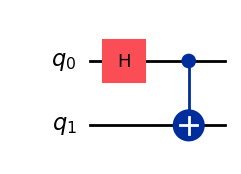

In [27]:
from qiskit import QuantumCircuit # type: ignore

# si crea un circuito quantistico di due qubit
example = QuantumCircuit(2)
 
# si aggiunge una porta H al qubit 0
example.h(0)
 
# si fa una CNOT (nota anche come C-X, o CX) al qubit 1, controllato dal qubit 0
example.cx(0, 1)

# N.B.: non effettuiamo misurazioni attualmente perché abbiamo altri interessi: ovvero, calcolare il valore atteso di alcuni osservabili (vedremo cosa sono)

# stampa l'immagine del circuito tramite MatPlotLib ("mpl")
example.draw("mpl")

### Traspilatore

Il modulo `qiskit.transpiler` è il modulo responsabile della **traspilazione**, cioè il processo di traduzione e ottimizzazione di un circuito quantistico per adattarlo a un dispositivo quantistico specifico: lo si può vedere come la fase di ottimizzazione di codice assembly in un compilatore classico. Il traspilatore interfaccerà allo specifico backend con il codice ad alto livello scritto da noi, per generare un'ISA apposita per quel backend (cioè, per quella architettura).

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # type: ignore
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()
pm = generate_preset_pass_manager(backend = backend, optimization_level = 1) # ci sono diversi livelli di ottimizzazione, dove 2 è un bilancio tra qualità e velocità (di compilazione) e 3 è ottimizzazione aggressiva

Creo un circuito di esempio che crea lo stato di bell $\ket{\beta_{00}}$:

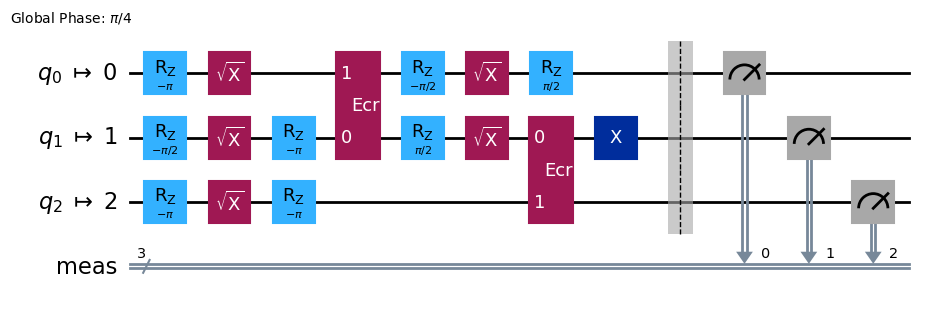

In [ ]:
from qiskit import QuantumCircuit

# circuito di esempio
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()

# lo ottimizzo con il traspilatore
qc_isa_circuit = pm.run(qc)

# stampa l'immagine del circuito ISA
qc_isa_circuit.draw("mpl", idle_wires = False)

### Primitive

Meglio vederle dopo, con la pratica. Sono fondamentalmente funzioni utilizzate per eseguire gli esperimenti, e se ne distinguono due macro-categorie:

- `EstimatorV2`: calcola il valore atteso di un osservabile;
- `SamplerV2`: calcolare la distribuzione dei dati di un circuito.

## Cos'è un osservabile?

**N.B.**: informazioni estratte anche da quantumcomputing.stackexchange [\[1\]](https://quantumcomputing.stackexchange.com/questions/39020/what-is-the-use-of-sparsepauliop-in-qiskit-and-how-to-use-it) [\[2\]](https://quantumcomputing.stackexchange.com/questions/38976/relation-between-expectation-value-and-counts-in-reference-to-qiskit/38981#38981).

### Definizione base

Come ben sappiamo, i calcolatori quantistici producono risultati probabilistici, perciò è importante fare una serie di esperimenti sui risultati, eseguendo il circuito più e più volte. Sul nostro circuito possiamo fondamentalmente fare due tipi di analisi:

- valore atteso degli **osservabili**: ovvero, $\braket{O}$;
- distribuzione di probabilità dei **risultati**: ovvero, una stima degli output del circuito, per vedere quanto efficientemente funziona. È necessaria una **misura** preliminare, e tipicamente si esegue rispetto alla base computazionale (vedi dopo).

Quello che risultano meno intuitivi sono i così detti **osservabili**: in meccanica quantistica un osservabile $O$ è una matrice hermitiana, duque tale che $O = O^\dagger$, che per il teorema di decomposizione spettrale ammette una decomposizione diagonale in una base di vettori ortonormali, in particolare i suoi autovettori; siano i suoi autovalori e autovettori rispettivamente $\lambda_i$ e $\ket{\lambda_i}$.

- dato uno stato quantico $\ket{\psi}$, è possibile misurarlo rispetto all'osservabile $O$ definito - come citato poco prima - da una base di vettori ortonormali detti i suoi autostati $\ket{\lambda_i}$. \
Dunque, è possibile rappresentare lo stato del sistema $\ket{\psi}$ come combinazione lineare degli autostati di $O$, ovvero:
    $$
    \ket{\psi} = \sum_i c_i \ket{\lambda_i}
    $$
    Dove $c_i = \braket{ \lambda_i | \psi}$.
- il **risultato della misura** è uno degli autovalori $\lambda_i$ dell'osservabile $O$;
- la **probabilità** di ottenere una determinata misura $\lambda_i$ è definita da:
  $$
  \Pr\{ i \} = \lvert \braket{\psi | \lambda_i} \rvert^2
  $$

Abbiamo quindi intuito che, fondamentalmente, una misura è una PROIEZIONE dello stato $\ket{\psi}$ nell'autospazio di $O$. \
Argomenti correlati agli osservabili sono i **proiettori** e gli **stati post-misura**.

- il proiettore $P$ dell'autostato $\ket{\lambda_i}$ è un operatore definito come la matrice che consente di proiettare uno stato $\ket{\psi}$ nell'autospazio dell'osservabile $O$:
$$
P_{\ket{\lambda_i}} = \ket{\lambda_i}\bra{\lambda_i} 
$$
- dopo la misura, lo stato **collassa** in uno degli autostati dell'osservabile. Più in particolare, viene **proiettato** in uno di essi: mediante un proiettore, possiamo valutare lo stato post-misura (che è, di fatto, una proiezione nell'autospazio) dello stato del sistema:

$$
\ket{\psi_{\text{post}}} = \frac { P_{\ket{\lambda_i}}\ket{\psi} } { \lVert \Pr\{ i \} \rVert }
$$

Come norma si da per scontata la norma $2$:

$$
\lVert \Pr\{ i \} \rVert _2 = \lVert \braket{\psi | \lambda_i} \rVert _2 = \sqrt{ \braket{\psi | P_{\ket{\lambda_i}} | \psi} }
$$

### Composizioni di osservabili

Quali sono gli osservabili più comuni? Tipicamente si sceglie di utilizzare $n$ matrici di Pauli concatenate $Z_1Z_2 \dots Z_n$ per $n$ qubit:

$$
Z = P_{\ket{0}} - P_{\ket{1}} = \ket{0}\bra{0} - \ket{1}\bra{1}
$$

Si osservi che gli autovalori di questa macro-matrice non sono altro che la **base computazionale** con cui abbiamo sempre lavorato:

$$
\ket{0 \dots 00}, \ket{0 \dots 01},\ket{0 \dots 10}, \dots, \ket{1 \dots 11}
$$

La comodità sta nel fatto che uno stato quantico $\ket{\psi}$ può essere facilmente codificato nella sua "codifica binaria classica". In particolare, è comodo perché la probabilità di ottenere un risultato è data dal modulo quadro del coefficiente di $\ket{\psi}$.
Per esempio, si supponga di voler misurare, rispetto alla base $Z$:

$$
\ket{\psi} = \frac{\ket{0} + \ket{1}}{\sqrt{2}}
$$

Misurando rispetto alla matrice di Pauli $Z$, otteniamo due possibili outcomes:
- probabilità di ottenere il qubit $\ket{0}$ con autovalore $1$ è $\Pr\{ 1 \} = \lvert \braket{\psi | 0} \rvert^2 = \lvert \braket{ \frac{\ket{0} + \ket{1}}{\sqrt{2}} | 0} \rvert^2 = \frac{1}{2}$
- probabilità di ottenere il qubit $\ket{1}$ con autovalore $-1$ è $\Pr\{ -1 \} = \lvert \braket{\psi | 1} \rvert^2 = \frac{1}{2}$

La funzione di nostro interesse è `qiskit.quantum_info.SparsePauliOp`: essa produce una matrice $2^n \times 2^n$ costitruita come combinazione lineare di matrici di Pauli ($I$, $X$, $Y$, $Z$): nell'utilizzo della funzione si usa una specifica notazione. Per esempio, si consideri un osservabile $O$:

$$
O =
\begin{bmatrix}
-32 & 0 & \frac{1}{2} & 0 \\
0 & 32 & 0 & \frac{1}{2} \\
\frac{1}{2} & 0 & -32 & 0 \\
0 & \frac{1}{2} & 0 & 32
\end{bmatrix}
= \frac{1}{2} I_1 X_0 - 32 I_0 Z_1
= \frac{1}{2} I ⊗ X - 32 I ⊗ Z 
$$

L'ultima uguaglianza è una decomposizione in matrici di Pauli, e il pedice $0, 1, \dots$ sotto le matrici - tipo $Z_0$ - intende dire "applico il gate $Z$ al qubit 0, cioè il LSqB". Si da per scontato in questo contesto, infatti, che il prodotto tra ogni matrice sia in *prodotto tensoriale* $⊗$.

---
***Dal sito ufficiale di Qiskit***

Here, something like the `ZZ` operator is a shorthand for the tensor product $Z ⊗ Z$, which means measuring $Z$ on qubit 1 and $Z$ on qubit 0 together, and obtaining information about the **correlation** between qubit $1$ and qubit $0$. Expectation values like this are also typically written as:

$$
\mathbb{E}[Z_1 Z_0] = \braket{Z_1 \otimes Z_0} := \braket{\psi \rvert Z_1 Z_0 \lvert \psi}
$$
If the state is *entangled*, then the measurement of $\braket{Z_1 Z_0}$ should be 1.

---

Dunque, sintetizzando:

- la misura di un osservabile $O$ è una proiezione di $\ket{\psi}$ nel suo autospazio, le conclusioni si sono viste sopra circa le misure e le probabilità;
- un'osservabile generico è sempre demponibile come combinazione lineare delle matrici di Pauli $P = {I, X, Y, Z}$;
$$
O = c_I I + c_X X + c_Y Y + c_Z Z
$$
- si consideri uno stato $\ket{\psi}$ di $n$ qubit: $n$ qubit sono rappresentati come un prodotto tensoriale, e di conseguenza anche l'osservabile si descrive come prodotto tensoriale di $n$ gates - buona parte saranno $I$: si vuole capire come questi gates siano **correlati** tra di loro;
- misurare il valore atteso $\braket{\cdot}$ di un osservabile $O$ significa misura il grado di **correlazione** tra i $j$-esimi qubit dello stato $\ket{\psi}$ che vengono proiettati nei corrispondenti autospazi delle matrici di pauli $P_j$ con cui viene costruito l'osservabile $O$.

Ma perché il valore atteso $\braket{O}$ denota una correlazione? Si considerino due gate $A$ e $B$ che agiscono su due qubit ciascuno, ovvero:

$$
O = A ⊗ B
$$

$A$ agisce sul primo, $B$ sul secondo. \
Allora possono accadere due casi:

- non correlazione (indipendenza statistica): gli stati sono indipendenti, e di conseguenza è possibile fattorizzare $\braket{O}$ come il prodotto dei valori attesi:

$$
\braket{O} = \braket{A} \cdot \braket{B}
$$

- entanglement (dipendenza statistica): gli stati dipendono l'uno dall'altro, e NON è possibile fattorizzare. Si può provare misurando lo stato di Bell su $ZZ$. 

In [18]:
from qiskit.quantum_info import SparsePauliOp # type: ignore

# The from_list method expects a list of tuples of length 3:
# - the first element being the Pauli word;
# - the second one being the qubits on which the letters apply
# - the last one being the coefficient
# It also needs the number of qubits so that it knows how many "I"s it should add to complete the sparse matrix.
example_observable = SparsePauliOp.from_sparse_list([
    ("X", [0], 1/2),
    ("Z", [1], -32)
], num_qubits = 2)

example_observable

SparsePauliOp(['IX', 'ZI'],
              coeffs=[  0.5+0.j, -32. +0.j])

Capito dunque come funzionano - e cosa sono - gli osservabili, generiamo una serie di osservabili su cui fare esperimenti. \
Tra questi osservabili generiamo $ZZ$, la base computazionale.

In [19]:
from qiskit.quantum_info import SparsePauliOp # type: ignore

labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in labels]
observables

[SparsePauliOp(['IZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['XI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['XX'],
               coeffs=[1.+0.j])]

### Proiezione sugli osservabili

#### Proiezione della direzione di spin

Abbiamo appena visto cosa sono gli osservabili: operatori hermitiani associati a quantità fisiche misurabili. \
Si consideri una **direzione di spin** $\vec{n} = (n_x, n_y, n_z)$: la **misura**, che come abbiamo visto è rappresentato dalla proiezione negli autospazi. \
Una rappresentazione della misura di $\vec{n}$ è l'osservabile:

$$
\vec{n} \cdot \vec{\sigma} = n_x X + n_y Y + n_z Z,
$$

Per esempio, tre direzioni che ci torneranno utili a seguire per il protocollo E91 sono le seguenti:

- $\vec{a}_1 = (1, 0, 0)$, cioè l'asse $x$, l'osservabile è $X$;  
- $\vec{a}_2 = \left(\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}\right)$, direzione intermedia tra $x$ e $z$, l'osservabile è:
    $$
    W = \frac{1}{\sqrt{2}}(Z + X)
    $$
- $\vec{a}_1 = (0, 0, 1)$, cioè l'asse $z$, l'osservabile è $Z$.

Il problema si pone ora nella misura degli osservabili qui sopra.
`!important`: ogni misura avviene sempre rispetto alla base computazionale $Z$: dunque, se si vuole misurare rispetto una direzione arbitraria $\vec{n}$, è necessario **ruotare la base di misura** per allinearla a $Z$. Per esempio:

- misura di $X$: prima di misurare sulla base computazionale, si applica una porta di Hadamard in modo che gli autostati di $X$, che sono $\ket{+}, \ket{-}$, vengano ruotati in $\ket{0}, \ket{1}$: cos', la misura di $X$ diventa equivalente alla misura in $Z$;
- misura di $W$: richiede una serie di gate per eseguire la misura nella base computazionale, e sono i gate $S\to H\to T\to H$.

    $$
    S = \begin{pmatrix} 1 & 0 \\ 0 & i \end{pmatrix} \qquad S^\dagger = \begin{pmatrix} 1 & 0 \\ 0 & -i \end{pmatrix} \qquad T = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{pmatrix}
    $$

    Dove:

    - $S$ introduce una rotazione di $90^\circ$ intorno l'asse $Z$;
    - $T$ introduce una rotazione di $45^\circ$ intorno l'asse $z$;
    - $H$ mette il qubit in superposizione e sposta l'asse da $Z$ a $X$.
    
    Considerando il qubit $\ket{0}$:
    
    - $S$ non ha effetto, essendo il qubit $\ket{0}$ già posizionato massimalmente su $Z$ (vedi sfera di Bloch);
    - $H$ impone la superposizione sul qubit, $H\ket{0} = \ket{+}$, che ora si trova spostato massimamente sull'asse $X$ ed è tra il punto $\ket{0}$ e $\ket{1}$;
    - $T$ ruota il qubit di $45^\circ$ intorno l'asse $Z$ - l'angolo $\varphi$ nella convenzione della sfera di Bloch;
    - $H$ sposta la base da $X$ a $Z$.
    
    Il perché funzioni, verrà mostrato a seguire.

Per dimostrare matematicamente come la sequenza di porte $S\to H\to T\to H$ consenta di misurare nella base computazionale $Z$, analizziamo l'effetto complessivo della sequenza su un generico stato quantistico. Le porte coinvolte sono:

$$
S = \begin{pmatrix} 1 & 0 \\ 0 & i \end{pmatrix} \qquad S^\dagger = \begin{pmatrix} 1 & 0 \\ 0 & -i \end{pmatrix} \qquad T = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{pmatrix}
$$

Dove:

- $S$ introduce una rotazione di $90^\circ$ intorno l'asse $Z$;
- $T$ introduce una rotazione di $45^\circ$ intorno l'asse $z$;
- $H$ mette il qubit in superposizione e sposta l'asse da $Z$ a $X$.

**N.B.**: matematicamente, la sequenza $S\to H\to T\to H$ corrisponde all'operatore composito $U_{\text{tot}}$:  

$$
U_{\text{tot}} = H \cdot T \cdot H \cdot S
$$

Calcoliamo passo-passo le matrici:

$$
H \cdot T = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \cdot \begin{bmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & e^{i\pi/4} \\ 1 & -e^{i\pi/4} \end{bmatrix}
$$

$$
(H \cdot T) \cdot H = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & e^{i\pi/4} \\ 1 & -e^{i\pi/4} \end{bmatrix} \cdot \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} = \frac{1}{2} \begin{bmatrix} 1 + e^{i\pi/4} & 1 - e^{i\pi/4} \\ 1 - e^{i\pi/4} & 1 + e^{i\pi/4} \end{bmatrix}
$$

$$
U_{\text{tot}} = \frac{1}{2} \begin{bmatrix} 1 + e^{i\pi/4} & 1 - e^{i\pi/4} \\ 1 - e^{i\pi/4} & 1 + e^{i\pi/4} \end{bmatrix} \cdot \begin{bmatrix} 1 & 0 \\ 0 & i \end{bmatrix} = \frac{1}{2} \begin{bmatrix} 1 + e^{i\pi/4} & i(1 - e^{i\pi/4}) \\ 1 - e^{i\pi/4} & i(1 + e^{i\pi/4}) \end{bmatrix}
$$

Nella sua interpretazione fisica, la sequenza $H \cdot T \cdot H \cdot S$ realizza una **rotazione composta** che allinea la base arbitraria $W$ alla base computazionale $Z$. \
Ora, il nostro obiettivo è misurare lo spin lungo la direzione $\vec{n}$ - nel nostro caso, $W$ -, e ciò equivale a:

- ruotare lo stato per allineare $\vec{n}$ all'asse $Z$.  
- misurare in $Z$.

La base $W$ è definita dagli autostati dell'osservabile $W = \frac{1}{\sqrt{2}}(X + Z)$, che sono:  

$$
|w_+\rangle = \cos\left(\frac{\pi}{8}\right)|0\rangle + \sin\left(\frac{\pi}{8}\right)|1\rangle
\qquad |w_-\rangle = -\sin\left(\frac{\pi}{8}\right)|0\rangle + \cos\left(\frac{\pi}{8}\right)|1\rangle
$$

Provando ad applicare l'operatore di rotazione $U_{\text{tot}}$ a $|w_+\rangle, |w_-\rangle$:  

$$
U_{\text{tot}} |w_+\rangle = |0\rangle \qquad U_{\text{tot}} |w_-\rangle = |1\rangle
$$  

Dopo la sequenza, lo stato $|w_+\rangle$ viene mappato in $|0\rangle$, permettendo di misurare $|0\rangle$ in $Z$. \
Fondamentalmente, dunque, la sequenza $S \rightarrow H \rightarrow T \rightarrow H$ **trasforma gli autostati di** $W$ negli autostati di $Z$, e misurare in $Z$ *dopo* questa sequenza equivale a misurare nella base $W$ *prima* della sequenza. Matematicamente:

$$
\text{Misurazione in } Z \text{ dopo } U_{\text{tot}} \equiv \text{Misurazione in } W \text{ prima di } U_{\text{tot}}
$$

Più sotto, un esempio di codice che mostra come "misurare" l'osservabile $X$.
Sarà necessario anticipare il concetto di **primitiva** in Qiskit, perciò si prendano alcune funzioni per come sono: fondamentalmente, eseguono il circuito e raccolgono i risultati.

In [32]:
import numpy as np
from qiskit import QuantumCircuit # type: ignore
from qiskit_aer import AerSimulator # type: ignore
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # type: ignore
from qiskit_ibm_runtime import SamplerV2 as Sampler # type: ignore

qc = QuantumCircuit(1, 1)

# si prepara uno stato, ad esempio |+⟩
qc.h(0) # rimuovere questa riga ci consente di misurare X su altri stati, ad esempio |0⟩: in quel caso, otteniamo al 50% "0" e al 50% "1"

# per allineare X alla base Z, si applica H prima della misura
qc.h(0)

# misura
qc.measure(0, 0)

# esecuzione e raccolta dati
backend = AerSimulator()
sampler = Sampler(mode = backend)
pm = generate_preset_pass_manager(backend = backend)
counts = sampler.run([(pm.run(qc))]).result()[0].data.c.get_counts()

print(f"Risultati della misurazione di X: {counts}")

Risultati della misurazione di X: {'0': 1024}


Per misurare invece l'osservabile $W$:

In [ ]:
import numpy as np
from qiskit import QuantumCircuit # type: ignore
from qiskit_aer import AerSimulator # type: ignore
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # type: ignore
from qiskit_ibm_runtime import SamplerV2 as Sampler # type: ignore

qc = QuantumCircuit(1, 1)

# opzionale: si può preparare uno stato specifico (es. |w_+⟩)
# qc.ry(np.pi/4, 0) # prepara lo stato |w_+⟩: se si prepara e si esegue il codice, si otterrà al quasi 100% "0"

# si prepara uno stato, ad esempio |+⟩
qc.s(0)
qc.h(0)
qc.t(0)
qc.h(0)

# Misurazione nella base Z (ora equivalente a W)
qc.measure(0, 0)

# esecuzione e raccolta dati
backend = AerSimulator()
sampler = Sampler(mode = backend)
pm = generate_preset_pass_manager(backend = backend)
counts = sampler.run([(pm.run(qc))]).result()[0].data.c.get_counts()

print(f"Risultati della misurazione di X: {counts}")

Risultati della misurazione di X: {'0': 876, '1': 148}


Fondamentalmente, nel codice ci sono tre fasi:
1. preparazione dello stato:  
   - se si vuole misurare $X$ su $|+\rangle$, si lascia `qc.h(0)` prima della misurazione;  
   - Per misurare $X$ su altri stati (es. $|0\rangle$), si rimuove la prima `qc.h(0)`.

2. allineamento alla base $Z$: la seconda `qc.h(0)` trasforma gli autostati di $X$, cioè $|+\rangle, |-\rangle$, negli autostati di $Z$ $|0\rangle, |1\rangle$.

3. l'Interpretazione dei risultati è molto semplice:  
   - `0` corrisponde a $|+\rangle$, autovalore $+1$.  
   - `1` corrisponde a $|-\rangle$, autovalore $-1$.

Scegliendo di proiettare (cioè, misurare) $W$ sullo stato $\ket{0}$, si vedrà una distribuzione probabilistica di circa:

$$
P(\ket{w_+}) = \lvert \langle w_+ \vert 0 \rangle \rvert ^ 2 = \cos^2 \frac{\pi}{8} \approx 0.85
$$
$$
P(\ket{w_-}) = \lvert \langle w_- \vert 0 \rangle \rvert ^ 2 = \sin^2 \frac{\pi}{8} \approx 0.15
$$

Misurandolo sullo stato $\ket{w_+}$, essendo allineato, si otterrà `0` quasi al $100\%$. \
Sulla sfera di Bloch:

- $\ket{0}$ è lungo l'asse $+Z$
- gli autostati $\ket{w_+}$ e $\ket{w_-}$ sono orientati di $\pm 45^\circ$ rispetto a $Z$;
- dunque, la misurazione in $W$ corrisponde a proiettare $\ket{0}$ lungo queste direzioni oblique, risultando in una distribuzione $85/15$.

#### Rotazioni tramite le porte $RY$

Un modo molto più semplice ed equivalente per eseguire rotazioni è mediante la porta $RY$: per esempio, nel caso della misura di $W$, questa mappa $\ket{0} \to \ket{w_+}$ e la misura in $Z$ dopo $RY(\pi / 4)$, che equivale a misurare in $W$. \
$RY$ per definizione esegue una rotazione **intorno** l'asse $y$, tenendo questi fissato: ovvero, è una rotazione nel piano $X$-$Z$ dell'angolo $\theta$ (nella convenzione della sfera di Bloch).

$$
RY(\theta) = e^{-i \frac{\theta}{2} Y} =
\begin{bmatrix}
\cos(\theta/2) & -\sin(\theta/2) \\
\sin(\theta/2) & \cos(\theta/2)  
\end{bmatrix}
$$

Per quanto la matrice possa "confondere" coi mezzi angoli, la porta $RY(\theta)$ esegue una rotazione di esattamente $\theta$ radianti intorno l'asse $y$. \
Il codice più sotto mostra come un angolo di input pari a $\pi$ esegua una rotazione piatta da $\ket{0}$ a $\ket{1}$ applicando $RY(\pi)\ket{0}$.

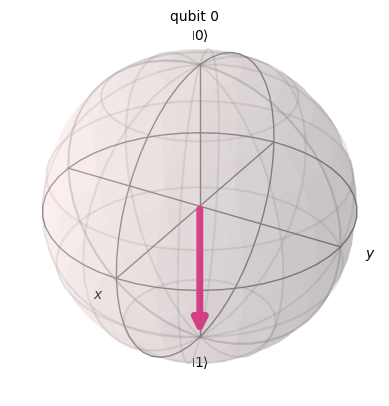

In [22]:
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

qc = QuantumCircuit(1)
qc.ry(np.pi, 0) # ruota di pi attorno a Y

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

A livello matematico:

In [23]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

angles = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]

for theta in angles:
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    state = Statevector.from_instruction(qc)
    print(f"θ = {theta:.2f} rad → Stato finale: {np.round(state.data, 3)}")

θ = 0.00 rad → Stato finale: [1.+0.j 0.+0.j]
θ = 1.57 rad → Stato finale: [0.707+0.j 0.707+0.j]
θ = 3.14 rad → Stato finale: [0.+0.j 1.+0.j]
θ = 4.71 rad → Stato finale: [-0.707+0.j  0.707+0.j]
θ = 6.28 rad → Stato finale: [-1.+0.j  0.+0.j]


Dove:

- $θ = 0.00$ corrisponde a $[1, 0]$, cioè $\ket{0}$
- $θ = 1.57$ corrisponde a $[0.707, 0.707]$, cioè $\ket{+}$, ed equivale a una rotazione di $90^\circ$
- $θ = 3.14$ corrisponde a $[0, 1]$, cioè $\ket{1}$, ed equivale a una rotazione di $180^\circ$
- $θ = 4.71$ corrisponde a $[-0.707, 0.707]$, cioè $-1 \cdot \ket{-} = e^{i \pi}\ket{-} \equiv \ket{-}$ (la fase globale non ha effetti nello stato) ed equivale a una rotazione di $270^\circ$
- $θ = 6.28$ corrisponde a $[-1, 0]$, cioè $-1 \cdot \ket{0} \equiv \ket{0}$

## Generazione dei samples in Qiskit

Come detto in precedenza, vogliamo collezionare tutti risultati **casuali** degli esperimenti eseguendo più volte il circuito: utilizziamo a tale scopo le due primitive della classe `qiskit_ibm_runtime`, che sono `EstimatorV2` e `SamplerV2`, che verranno eseguito solo tramite la funzione `.run()`. Un input importante delle due primitive è un'array di *primitive unified bloc* (PUB): un PUB è una struttura dati - una tupla, in particolare - che contiene sinteticamente le informazioni necessarie all'`EstimatorV2` o al `SamplerV2` per dire alla QPU quale job svolgere, su cosa svolgerlo e come svolgerlo.

### Stima del valore atteso: uso di `EstimatorV2`

L'`EstimatorV2` è progettato per calcolare **valori attesi** $\langle H \rangle$ di un'osservabile rispetto a uno stato quantistico prodotto da un circuito quantistico.

- prende come input:
  - un **circuito quantistico** $ U $, che prepara lo stato $|\psi\rangle = U|0\rangle $.
  - una o più **osservabili** $ H $, come matrici di Pauli (ad esempio, $ Z \otimes Z, X $, etc.).
- restituisce:
  - il valore atteso dell'osservabile $H$:
    $$
    \langle H \rangle = \langle \psi | H | \psi \rangle
    $$

Si usa tipicamente quando ci interessa ottenere **valori medi** di osservabili per un dato circuito quantistico, ed è utilizzato in algoritmi come VQE (Variational Quantum Eigensolver), dove il valore atteso di un Hamiltoniano descrive l'energia dello stato. \
Consideriamo quindi di utilizzare nell'esercizio uno stimatore.

In [35]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator # type: ignore
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2 # type: ignore
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # type: ignore

# circuito di esempio
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

# lo ottimizzo con il traspilatore
backend = FakeAlmadenV2()
pm = generate_preset_pass_manager(backend = backend)
qc_isa_circuit = pm.run(qc)

estimator = Estimator(mode = backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000 # gli "shots" sono il numero di esperimenti che verranno fatti col circuito

# .apply_layout serve ad applicare un layout ottenuto dal traspilatore agli osservabili: praticamente, li ottimizza per l'ISA specifica
mapped_observables = [observable.apply_layout(qc_isa_circuit.layout) for observable in observables]
 
# otteniamo il job, e nella funzione .run() inseriamo il PUB: il circuito (traspilato) e gli osservabili mappati
job = estimator.run([(qc_isa_circuit, mapped_observables)])
 
# otteniamo il job ID
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: eb70c8e3-491d-4fc8-b2ab-8f9d46f9b092


Un "job", fondamentalmente, è il "lavoro" che vogliamo che il nostro calcolatore quantistico faccia, e viene identificato da un ID. \
Soffermandoci su backend reali:

- si può visualizzare il job nel proprio account IBM Quantum;
- il metodo `.run(...)` definisce solo i *parametri* del job, tramite il PUB di input;
- il vero job viene eseguito nel momento in cui si utilizza il comando `.result()`.

**N.B.**: consiglio di eseguire i job di tarda sera (dopo le 23:00), non ci sono code.

In [36]:
# estraiamo i risultati del job con .result()
job_result = job.result()
pub_result = job.result()[0]
example_expected_values = pub_result.data.evs

print(f'>>> PUB result: {pub_result}')

>>> PUB result: PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'target_precision': 0.01414213562373095, 'shots': 5000, 'circuit_metadata': {}})


Estraiamo i valori attesi con `.evs`, oppure le deviazioni standard con `.stds`.

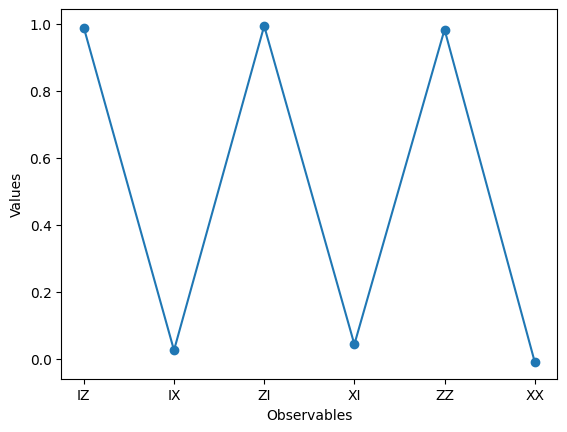

In [37]:
from matplotlib import pyplot as plt # type: ignore

plt.plot(labels, example_expected_values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

#### Interpretazione del risultato

Come si interpreta questo risultato?
Innanzitutto, si osservi che in $IZ, IX, ZI, XI$ la porta $I$ equivale a "in questo qubit non applico un gate" - dato che $I$ non ha alcun effetto. \
Si osservi la presenza di un po' di rumore sul primo qubit: se si utilizza un simulatore, è... *necessario* che `qiskit-aer` sia installato, altrimenti verrà ritornato il seguente warning:

```bash
    RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.`
```

Dato che non sarà attendibile il risultato. \
Sulla base di ciò, osserviamo che:

- valori attesi individuali per $X$ e $Z$: per ciascun qubit $Q_0$ e $Q_1$, il valore atteso di $X$ (operatore di Pauli-$X$, che rappresenta una rotazione attorno all'asse $x$ della sfera di Bloch) e $Z$ (operatore d Pauli-$Z$, che misura l'asse $z$) è $\braket{X} = \braket{Z} = 0$.

- valori attesi correlati per $XX$ e $ZZ$: le correlazioni tra i qubit $XX$ e $ZZ$ sono $1$.

Ma cosa significa?

- valori attesi individuali nulli: per un qubit ($X$ e $Z$ sono applicate a un solo qubit come si nota nei primi $4$ punti delle ascisse), questo implica che il suo stato non ha una componente preferenziale lungo gli assi $x$ o $z$ (si pensi sempre alla sfera di Bloch). È quindi in una sovrapposizione equilibrata e non polarizzata su uno stato particolare, come $\ket{0}$ o $\ket{1}$.

- correlazioni perfette: i qubit sono **entangled**, e i loro stati non possono essere descritti indipendentemente. Cioè, una misura lungo $X$ o $Z$ di uno dei due qubit determina immediatamente il risultato della misura dell'altro, con una correlazione perfetta.

Un esempio concreto è lo stato Bell:

$$
\ket{\Phi^{+}} = \frac{\ket{00} + \ket{11}}{\sqrt{2}}
$$

Infatti osserviamo che:

1. è una superposizione perfetta dei due stati $\ket{00}$ e $\ket{11}$: ciò significa che *ENTRAMBI* i qubit devono essere $\ket{0}$ o $\ket{1}$.
2. proprietà dello stato:
   - **stati individuali**: il singolo qubit dello stato, preso appunto "da solo" senza l'altro, oscilla nello stato $\ket{0}$ o $\ket{1}$ con probabilità del 50%, e dunque $\braket{X} = \braket{Z} = 0$;
   - però, le correlazioni tre i **due qubit** sono perfette:
     - se misuriamo $Z$ su entrambi, il risultato è sempre lo stesso $\braket{ZZ} = 1$.
     - se misuriamo $X$ su entrambi, il risultato è ancora correlato $\braket{XX} = 1$.

Ma andando più nello specifico... cosa fa $ZZ$? \
L'operatore $ZZ$ è definito come il prodotto tensoriale:
$$
ZZ = Z \otimes Z = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$
L'operatore $ZZ$ applicato a due qubit agisce sugli stati della base come segue:
$$
ZZ|00\rangle = +1 \cdot |00\rangle, \quad ZZ|11\rangle = +1 \cdot |11\rangle,
$$
$$
ZZ|01\rangle = -1 \cdot |01\rangle, \quad ZZ|10\rangle = -1 \cdot |10\rangle.
$$

Quindi, $ZZ$ misura **quanto i due qubit siano allineati** o **anti-allineati** lungo l'asse $Z$:
- la misura sarà +1 se sono entrambi $|0\rangle$ o entrambi $|1\rangle$;
- invece, sarò $-1$ se sono $|01\rangle$ o $|10\rangle$.

Per calcolare il valore atteso lungo l'osservabile $ZZ$, si utilizza la solita formula:
$$
\langle ZZ \rangle = \langle \Phi^+ | ZZ | \Phi^+ \rangle
$$

Con:
$$
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$
Calcoliamo:
$$
\langle ZZ \rangle = \left( \frac{|00\rangle + |11\rangle}{\sqrt{2}} \right)^\dagger ZZ \left( \frac{|00\rangle + |11\rangle}{\sqrt{2}} \right)
$$

Espandendo il prodotto scalare:
$$
\langle ZZ \rangle = \frac{1}{2} \left[ \langle 00 | ZZ | 00 \rangle + \langle 00 | ZZ | 11 \rangle + \langle 11 | ZZ | 00 \rangle + \langle 11 | ZZ | 11 \rangle \right]
$$

E semplificando:
1. $\langle 00 | ZZ | 00 \rangle = 1$, cioè entrambi $|0\rangle$;
2. $\langle 11 | ZZ | 11 \rangle = 1$ cioè entrambi $|1\rangle$;
3. $\langle 00 | ZZ | 11 \rangle = \langle 00 | 11 \rangle = 0$ e analogamente $\langle 11 | ZZ | 00 \rangle = \langle 11 | 00 \rangle = 0$, stati ortogonali.

Quindi:
$$
\langle ZZ \rangle = \frac{1}{2} (1 + 1) = 1.
$$

Il valore atteso $\langle ZZ \rangle = 1$ significa ch lo stato $|\Phi^+\rangle$ ha una **correlazione perfetta lungo $Z$**: entrambi i qubit sono sempre nello stesso stato, $|00\rangle $ o $|11\rangle$, quando misurati lungo l'asse $Z$, e non esiste alcuna probabilità che uno sia $|0\rangle$ e l'altro $|1\rangle$, o viceversa.

### Estensione dell'esperimento $n$ qubit

In questo esempio viene utilizzato il backend di IBM Quantum.

In [38]:
# riprendo tutti gli import
from qiskit import QuantumCircuit # type: ignore
from qiskit.quantum_info import SparsePauliOp # type: ignore
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions, QiskitRuntimeService # type: ignore
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # type: ignore
import matplotlib.pyplot as plt # type: ignore

# funzione copia-incollata dalla guida di Qiskit, crea uno stato di Bell generalizzato, cioè uno stato GHZ
def get_GHZ_state(n: int) -> QuantumCircuit:
    
    """
    This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        n (int): Number of qubits in the n-qubit GHZ state
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """

    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("Error: n should be an integer.")
    return qc

n = 100
qc = get_GHZ_state(n)

# ZZII...II, ZIZI...II, ... , ZIII...IZ
operator_strings = ["Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)]
operators = [SparsePauliOp(operator) for operator in operator_strings]
print('>>>', operators[0])
print('>>>', operators[1])
print('>>>', operators[2])
print('>>>', operators[3])
print('>>> ...')
print('>>>', operators[-1])

>>> SparsePauliOp(['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
>>> SparsePauliOp(['ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
>>> SparsePauliOp(['ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
>>> SparsePauliOp(['ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
>>> ...
>>> SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[1.+0.j])


In [ ]:
# utilizzo il backend di IBM Quantum
service = QiskitRuntimeService(channel = "ibm_quantum", token = "ff18c76fe2d2b6755501c823de21301519c2a091a4a1e777ee0ed66f447de5f8b7b08a1035a5ace038e0caf5c6d40e225a721adadcf9e18dd61ba6f6f4cb1d86")
backend = service.least_busy(simulator = False, operational = True)
print("Backend name:", backend.name)

Possiamo generalizzare il codice precedente con:

```python
    backend = service.least_busy(simulator = False, operational = True, min_num_qubits = n)
```

Per quanto segue: in Qiskit, il valore predefinito di `EstimatorV2.options.default_shots` è `1024`. Questo significa che, a meno che non venga esplicitamente specificato un diverso numero di "shots", l'`EstimatorV2` eseguirà $1024$ esperimenti.

Potrebbe esserci un po' di rumore (outlier), dipende tutto dal calcolatore quantistico utilizzato.
Nel codice della guida ufficiale, normalizza gli EVS degli operatori per osservare meglio il modo in cui decadono. 

### Stima *dopo* una misura?

In effetti, qualcosa che ancora non abbiamo visto è il concetto di **misura** in Qiskit, in particolare il metodo `QuantumCircuit.measure(QuantumRegister, ClassicalRegister)`, oppure il metodo `.measure_all()` che effettua una misura di tutti i qubit. \
Abbiamo infatti visto che una misura in meccanica quantistica corrisponde a una proiezione dello stato del sistema $\ket{x}$ nell'autospazio di "ciò con cui si osserva", cioè l'osservabile $O$: ma di fatto, qual è questo autospazio rispetto a cui misuriamo? Come anticipato e visto più volte, Qiskit misura rispetto alla **base computazionale**, ovvero ripetto all'osservabile $Z^{\otimes n}$, detti $n$ il numero di qubit misurati:

- non a caso, la base computazionale $Z$ è costituita dagli autostati $\ket{0}$ e $\ket{1}$ con autovalori $1$ e $-1$, e alla misura di un qubit $\ket{x} = \alpha \ket{0} + \beta \ket{1}$ lo stato viene proiettato in uno dei due autostati. \
In particolare, si può verificare che lo stato post-misura ha modulo unitario:
$$
\ket{x_\text{post}} = \frac{\alpha}{\rvert \alpha \lvert} \ket{0} = \ket{0} \quad \text{oppure} \quad \ket{x_\text{post}} = \ket{1} 
$$
- è quindi anche matematicamente conveniente utilizzare questa base per effettuare misure;
- inoltre, le scelte implementative sono volte anche a una maggior compatibilità con i calcolatori classici: infatti, i risultati della misura (che sono $0$ o $1$) possono essere salvati facilmente nei bit classici.

Fatto questo preambolo, calcolare il valore atteso degli osservabili DOPO una misura.

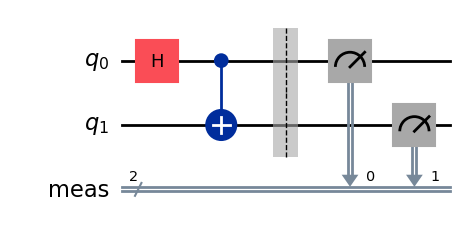

In [6]:
from qiskit import QuantumCircuit # type: ignore

bell_state_example = QuantumCircuit(2)
bell_state_example.h(0)
bell_state_example.cx(0, 1)
bell_state_example.measure_all()
bell_state_example.draw("mpl")

In [7]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2 # type: ignore
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # type: ignore

backend = FakeAlmadenV2()
pm = generate_preset_pass_manager(optimization_level = 1, backend = backend)
isa_bell_state_example = pm.run(bell_state_example)

In [8]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator # type: ignore
from qiskit.quantum_info import SparsePauliOp # type: ignore

estimator = Estimator(mode = backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in labels]
mapped_observables = [observable.apply_layout(isa_bell_state_example.layout) for observable in observables]

bell_state_example_expected_values = estimator.run([(isa_bell_state_example, mapped_observables)]).result()[0].data.evs
bell_state_example_expected_values

array([0.9816, 0.0784, 0.9748, 0.126 , 0.9564, 0.03  ])

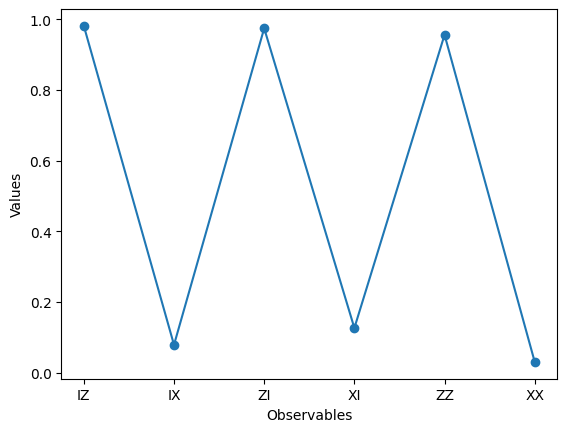

In [9]:
from matplotlib import pyplot as plt # type: ignore

plt.plot(labels, bell_state_example_expected_values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

Si faccia una bella distinzione! 

- la *MISURA* si fa sempre (quasi, almeno) rispetto alla base computazionale - cioe, le $n$ matrici di pauli-$Z$;
- dunque, DOPO la misura, lo stato $\ket{\Phi^+}$ può collassare solo in $\ket{00}$ o in $\ket{11}$.

Rispetto al caso precedente, si è dunque fatta *anche* una misura preliminare, e ora si vuole valutare il valore atteso di alcuni osservabili. Banalmente, cambierà il risultato perché lo stato è collassato.
Si considerino:

- osservabili singoli (su un solo qubit):
    + $IZ$ oppure $ZI$ (consideriamo il primo caso): lo stato di Bell può collassare, con equiprobabilità, negli stati post-misura $\ket{00}$ e $\ket{11}$. \
        Valutiamone dunque il valore atteso:
        $$
        \braket{IZ} = \braket{00|IZ|00} = \bra{00} \cdot IZ \ket{00}
        $$
        Osserviamo che:
        $$
        IZ \ket{00} = I \ket{0} \otimes Z \ket{0} = \ket{0} \otimes \ket{0} = \ket{00}
        $$
        Dunque:
        $$
        \braket{IZ} = \braket{00|IZ|00} = \bra{00} \cdot IZ \ket{00} = \braket{00|00} = 1
        $$s
        Analogamente quanto visto vale se lo stato collassa in $\ket{11}$;
    + $IX$ oppure $XI$:  
        $$
        \braket{IX} = \braket{00|IX|00} = \bra{00} \cdot IZ \ket{00}
        $$
        Osserviamo che:
        $$
        IX \ket{00} = I \ket{0} \otimes X \ket{0} = \ket{0} \otimes \ket{1} = \ket{01}
        $$
        Dunque:
        $$
        \braket{IX} = \braket{00|IX|00} = \bra{00} \cdot IZ \ket{00} = \braket{00|01} = 0
        $$
        Analogamente quanto visto vale se lo stato collassa in $\ket{11}$.
- osservabili composti (su più qubit): seque gli stessi principi, mi secca...

### Stima delle distribuzioni di probabilità degli stati: uso di `SamplerV2`


Il `SamplerV2` è usato per ottenere la **distribuzione delle probabilità** degli stati misurati dopo l'esecuzione di un circuito quantistico.

- prende come input:
  - un **circuito quantistico** $U$, che genera uno stato quantistico $|\psi\rangle$.
- Restituisce:
  - la **distribuzione delle probabilità** degli stati misurati nella base computazionale:
    $$
    P(|x\rangle) = |\langle x | \psi \rangle|^2,
    $$
    Dove $|x\rangle$ è uno stato della base computazionale (ad esempio $|00\rangle, |01\rangle, \dots$).
- effettua un numero definito di **campionamenti** simulando misurazioni multiple.

Si usa quando vogliamo sapere **quanto spesso** si verificano determinati risultati (ad esempio $|00\rangle$ o $|11\rangle$), ed è utile per ottenere distribuzioni empiriche e verificare che il circuito **funzioni come atteso**. \
Consideriamo il seguente circuito (Esercizio 4.36 da "Quantum computation and quantum information: 10th anniversary edition"), che esegue una somma tra due numeri modulo $4$: praticamente, fa una somma con solo due qubit.
$$
\ket{x, y} \to \ket{x, x + y \,\text{mod}\, 4}
$$

**N.B.**: gli stati sono sempre di DEFAULT inizializzati a $\ket{0}$: è dunque necessario che NOI li impostiamo "casuali". \
Il modo più semplice è settando delle porte di Hadamard per ogni input.

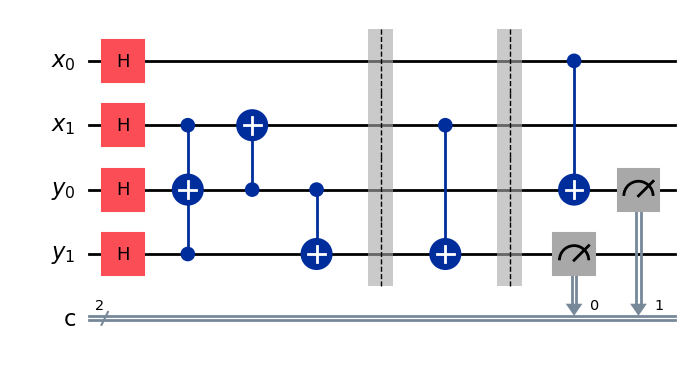

In [10]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit # type: ignore
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # type: ignore

# N.B.: la nomenclatura per MSqB e LSqB è "al contrario", cioè: x0x1 e y0y1 (vedasi che x1 e y1 sono i LSqB)

x = QuantumRegister(2, name = "x")
y = QuantumRegister(2, name = "y")
c = ClassicalRegister(2, name = "c")

adder = QuantumCircuit(x, y, c)

# randomizza gli input, che di defualt sono tutti |0⟩
for i in range(4):
    adder.h(i)

adder.ccx(x[1], y[1], y[0]) # carry a sinistra se x1 = y1 e poi reset dei registri
adder.cx(y[0], x[1])
adder.cx(y[0], y[1])
adder.barrier()

adder.cx(x[1], y[1]) # somma i LSqB se NON sono uguali
adder.barrier()

adder.cx(x[0], y[0]) # somma mod 4 tra i MSqB

adder.measure(y[0], c[1]) # c[1], bit classico più significativo
adder.measure(y[1], c[0]) # c[0], bit classico meno significativo

# ottimizzazione con traspilazione
pm = generate_preset_pass_manager(optimization_level = 1, backend = backend)
isa_adder = pm.run(adder)

adder.draw("mpl")

In [11]:
from qiskit_ibm_runtime import SamplerV2 as Sampler # type: ignore
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2 # type: ignore
import numpy as np # type: ignore

backend = FakeAlmadenV2()
sampler = Sampler(mode = backend)
sampler.options.default_shots = 5000 # gli "shots" sono il numero di esperimenti che verranno fatti col circuito

sampler_pub = sampler.run([(isa_adder)]).result()[0]

A seconda dei circuiti che verranno creati - ma ancora siamo in casi semplici -, la riga di codice:

```python
    adder_parameter_values = np.random.rand(adder.num_parameters)
```

Crea una lista di parametri casuali compresa tra $0$ e $1$, utile solo se il circuito ha parametri *variabili* (ad esempio, per porte come $R_z, R_x$, o porte parametriche).

In [12]:
data = sampler_pub.data
data.c

BitArray(<shape=(), num_shots=5000, num_bits=2>)

Notasi come l'attributo `data` del PUB non sia "`meas`" ma `data.c`: il motivo è dovuto al fatto che `meas` è un attriuìbuto generato in automatico da Qiskit con `.measure_all()`, mentre `c` rappesenta il "**c**lassical bit" su cui facciamo misure specifiche. 

Tra il `SamplerV1` e il `SamplerV2`, il formato del PUB è differente (e non si capisce un cazzo). \
Per accedere alle quasi-distribuzioni, nel V1 si utilizzava il metodo `.quasi_dists[0]`, in [`V2`](https://docs.quantum.ibm.com/guides/get-started-with-primitives#4-invoke-the-sampler-and-get-results), beh... \
Fondamentalmente, avrò quattro output: $00, 01, 10, 11$. Voglio vedere quante volte questi output sono usciti e... dovrebbero essere equivalenti.

In [13]:
print(f"Counts for the 'c' output register: {data.c.get_counts()}")

Counts for the 'c' output register: {'11': 1190, '01': 1224, '00': 1333, '10': 1253}


Per una miglior visualizzazione...

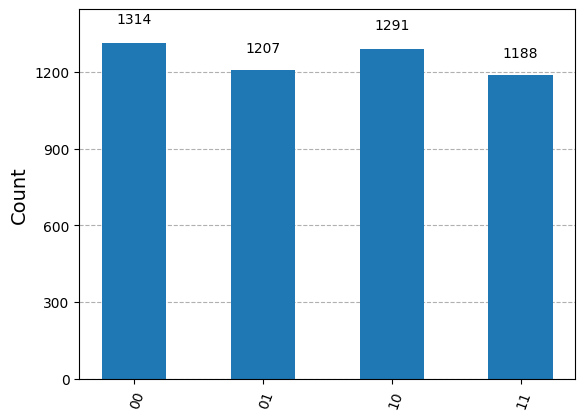

In [ ]:
from qiskit.visualization import plot_histogram # type: ignore

plot_histogram(data.c.get_counts())

Si supponga di voler misurare gli outcomes di uno stato di Bell, ci aspettiamo che siano MOLTO più probabili gli stati $\ket{00}$ e $\ket{11}$, e infatti: 

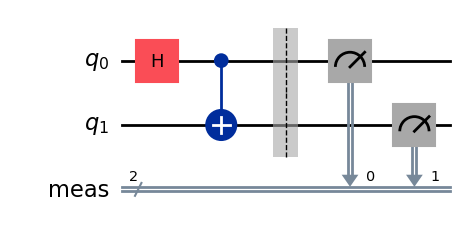

In [14]:
from qiskit import QuantumCircuit # type: ignore

bell_state = QuantumCircuit(2)
bell_state.h(0)
bell_state.cx(0, 1)
bell_state.measure_all()
isa_bell_state = pm.run(bell_state)
bell_state.draw("mpl")

In [15]:
sampler = Sampler(mode = backend)
sampler.options.default_shots = 5000
data = sampler.run([(isa_bell_state)]).result()[0].data

print(f"Counts for the 'meas' output register: {data.meas.get_counts()}")

Counts for the 'meas' output register: {'00': 2499, '11': 1975, '10': 164, '01': 362}


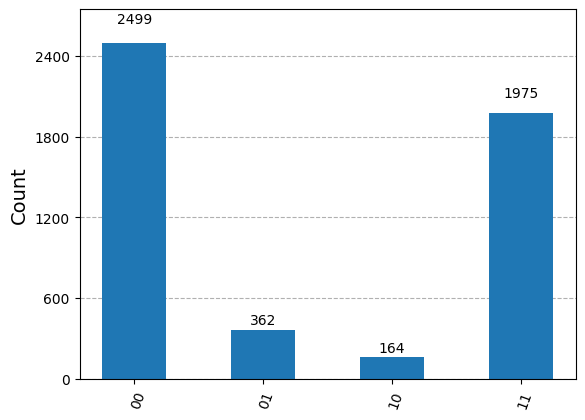

In [16]:
from qiskit.visualization import plot_histogram # type: ignore

plot_histogram(data.meas.get_counts())

## Protocollo E91

Prima di discutere del protocollo, è necessario introdurre alcuni concetti molto importanti.

### Paradosso di Einstein-Podolsky-Rosen

Il paradosso EPR - così chiamato in nome degli autori Einstein, Podolsky e Rosen - è un esperimento mentale che nacque come critica nei confronti della "nuova visione" della fisica del '900, ovvero la meccanica quantistica: secondo Albert Einstein, autore principale del così detto *EPR paper*, quest'ultima non è una teoria completa per descrivere la natura; scopo del paper fu quello individuare delle "falle", quali elementi della realtà che ci circondano, che non sono inclusi nella meccanica quantistica. \
Definiamo le seguenti quantità, che ci serviranno immediatamente dopo:

- $P_Q$: con esso intendiamo la "proprietà fisica" su cui andremo a effettuare la misura. Ma che si intende con "proprietà fisica"? \
Per esempio, se $Q = Z$, la proprietà fisica è la misura dell'**angolo** rispetto all'asse $z$ (nel caso di un fotone) o dello spin (nel caso di una particella) che può essere $\pm \frac{1}{2}$: per semplicità, dato che tratteremo particelle, imporremo come esito della misura $\pm 1$;
- $Q$: è l'elemento a noi già noto come **osservabile** (o "proprietà oggettiva") - come $Z$, nel caso precedente - associato alla proprietà fisica $P_Q$, su cui è possibile eseguire la misura della proprietà fisica: come già detto, può solo assumere valore $\pm 1$;
- considereremo due utenti comunicanti, Alice e Bob:
    + ad Alice associamo le proprietà fisiche $P_Q, P_S$;
    + a Bob le proprietà fisiche $P_R, P_T$;
    + un terzo utente, Charlie, preparerà a priori una particella per Alice e una particella per Bob.

Senza addentrarci troppo nei dettagli, due importanti assunzioni vengono eseguite per l'esecuzione dell'esperimento mentale, che sono quelli di **realtà** e **località**:

- realtà: le proprietà fisiche $P_Q, P_S, P_R, P_T$ assumono valori definiti $Q, S, R, T$ che esistono in maniera indipendente dall'**osservazione**. Per esempio, il lancio di una monetà è "reale" in quanto le proprietà "testa" / "croce" di una moneta esistono a priori dal lancio;
- località: la misurazione effettuata da Alice **non influenza** la misurazione effettuata da Bob.

Come vedremo, di fatto queste assunzioni verranno violate dalla meccanica quantistica, utilizzando come esempio un *spin singlet*:

$$
\ket{\psi^-} = \frac{\ket{01} - \ket{10}}{\sqrt{2}}
$$

### Disuguaglianza di Bell

La disuguaglianza di Bell nasce come **conseguenza** del paradosso EPR. \
A priori è di nostro interesse individuare come le misure di Alice e Bob sia tra loro correlate: sappiamo, per esempio, che $Q = \pm 1$ e $S = \pm 1$, e rappresentano per esempio la polarizzazione lungo un certo angolo. Se $Q = 1$ e $R = -1$, il prodotto ci dice in che modo le misure di Alice e Bob sono **correlate** o **anti-correlate**:

$$
Q \cdot S = 1 \cdot (-1) = -1 
$$

Ora, possiamo sommare le diverse correlazioni di tutte le misure effettuate da Alice e Bob:

$$
QS + RS + RT - QT = S (R + Q) + T (R - Q)
$$

---

Possiamo notare che l'ultimo addendo è negativo:

- la scelta non è casuale, ed è fatto imposto "sperimentalmente" per porre un tetto massimo alla correlazione tra particelle, almeno secondo le assunzioni fatte da EPR della fisica classica di realtà e località;
- il fatto che $QT$ sia negativo rende le correlazioni tra particelle più "sensibili" alle **correlazioni quantistiche**:
    + questo perché, come vedremo, lo spin singlet $\ket{\psi}$ viola (e deve violare) la disuguaglianza di Bell per un valore pari a $2 \sqrt{2}$ - e vedremo che il valore massimo sarà pari a $2$;
    + però, se il valore massimo fosse "incrementato" da un $QT$ positivo, allora lo spin singlet non risulterebbe correlato;

In pratica, il segno meno rende le **violazioni quantistiche** più evidenti. 

---

Fatta questa digressione, essendo $R, Q = \pm 1$ possiamo notare che dei due fattori $R + Q$ e $R - Q$ almeno uno dei deve essere nullo, e l'altro sarà invece $2$: dunque, possiamo dire che la precedente espressione è pari a:

$$
QS + RS + RT - QT = \pm 2
$$

Vogliamo ora calcolarne il valore atteso. \
Ponendo $Q = q, R = r, S = s, T = t$:

$$
\langle QS + RS + RT - QT \rangle = \sum_{qrst} p(q, r, s, t) \cdot (qs + rs + rt - qt) \le \sum_{qrst} p(q, r, s, t) \cdot 2 = 2 
$$

Inoltre, notiamo che:

$$
\langle QS + RS + RT - QT \rangle = \sum_{qrst} p(q, r, s, t) \cdot (qs + rs + rt - qt) = \\
\sum_{qrst} p(q, r, s, t) \cdot qs + \sum_{qrst} p(q, r, s, t) \cdot rs + \sum_{qrst} p(q, r, s, t) \cdot rt - \sum_{qrst} p(q, r, s, t) \cdot qt = \\
\langle QS \rangle + \langle RS \rangle + \langle RT \rangle - \langle QT \rangle
$$

Mescolando le precedenti, otteniamo la disuguaglianza di Bell o **disuguaglianza CHSH**:

$$
\langle QS \rangle + \langle RS \rangle + \langle RT \rangle - \langle QT \rangle \le 2
$$

Funziona la disuguaglianza su uno spin singlet? \
Consideriamo la situazione iniziale: Charlie prepara lo stato quantico:


$$
\ket{\psi} = \frac{\ket{01} + \ket{10}}{\sqrt{2}}
$$

E passa il primo qubit ad Alice a il secondo qubit a Bob:

- Alice eseguirà misure degli osservabili:
$$
Q = Z_1 \qquad R = X_1
$$
- Bob eseguirà misure degli osservabili:
$$
S = \frac{- Z_2 - X_2}{\sqrt{2}} \qquad T = \frac{Z_2 - X_2}{\sqrt{2}}
$$

I loro valori attesi sono:

$$
\langle QS \rangle = \frac{1}{\sqrt{2}} \quad \langle RS \rangle = \frac{1}{\sqrt{2}} \quad \langle RT \rangle = \frac{1}{\sqrt{2}} \quad \langle QT \rangle = \frac{1}{\sqrt{2}}
$$

E la disuguaglianza di Bell viene, di fatto, **violata**:

$$
\langle QS \rangle + \langle RS \rangle + \langle RT \rangle - \langle QT \rangle = 2 \sqrt{2} \not\le 2
$$

In generale, questa relazione evidenzia che due particelle sono in massimo entanglement se il **test di Bell** (rappresentato dalla somma dei valori attesi) è pari a $2 \sqrt{2}$:

$$
\boxed{
    \text{Bell}(Q, S, R, T) = \langle QS \rangle + \langle RS \rangle + \langle RT \rangle - \langle QT \rangle = 2\sqrt{2} \to \text{entanglement}
}
$$

### Canali quantum sicuri

Adesso, mostreremo una metrica generica per misurare quanto "sicuro" sia un canale di comunicazione quantico. \
Questa metrica, vedremo, è il così detto **quantum coherent information** $I(\rho, \mathcal{E})$, e misura quanto il messaggio trasmesso rimane inaccessibile a un attaccante: è una metrica fondamentale per valutare la sicurezza di una QDK.

- $\rho$: è una **mistura di stati** espressa sotto forma di matrice di densità $\rho$:
    $$
    \rho = \sum_i p_i \rho_i \qquad \rho_i = \lvert \psi_i \rangle \langle \psi_i \rvert
    $$
    Dove $p_i$ è la probabilità associata al singolo stato $\ket{\psi_i}$. \
    N.B.: uno stato quantico puro è uno stato che può essere descritto da un singolo vettore ket, mentre uno stato quantico misto è un insieme statistico di stati puri, come quello sopra;
- $\mathcal{E}$: denota una generica *operazione quantica*. Nel contesto trattato, questa "operazione" sarebbe la trasmissione di uno stato $\rho$ da un punto $A$ a un punto $B$ attraverso un canale non ideale soggetto a rumore o **intercettazioni** da parte di un **eavsdropper** ("ascoltatore", ho voluto usare il termine inglese perché l'origliatore si chiama Eve di fatto), dunque $\mathcal{E}$ è l'operazione di "trasmissione rumorosa e/o non sicura".

Si consideri la seguente situazione, dove vi sono due parti comunicanti - Alice e Bob - e un intercettatore Eve:

- Alice prepara uno dei possibili stati puri $\rho_i^A, i = 0, 1, \dots$ e lo trasmette nel canale di comunicazione $\mathcal{E}$;
- quando Bob lo riceve, lo stato ricevuto è qualcosa del tipo $\rho_i^B = \mathcal{E}(\rho_i^A) \neq \rho_i^A$, per quanto detto sopra.

Adesso, valutaremo adesso il **limite di Holevo**:

- è un upper bound per la mutua-informazione quantica $H$ tra uno stato $\rho^X$ (detta $X$ una variabile aleatoria) e una delle sue possibili misure $Y$;
- l'upper bound è una quantità $\chi$ che prende il nome di **informazione di Holevo** o **quantità $\chi$ di Holevo**, ed è definito come:

    $$
    \chi^Y = S(\rho^X) - \sum_i p_i S(\rho_i^X)
    $$

    Il fattore di Holevo ci dice quanta informazione classica può essere **estratta** da un sistema quantistico. \
    Detta $S(\cdot)$ l'entropia di Von Neumann dello stato $\rho^X$:

    $$
    S(\rho^X) = - \text{Tr}\, \rho^X \log_2 \rho^X
    $$

Nel nostro contesto, il limite di Holevo tra Alice e Bob è:

$$
H_{\text{Alice:Bob}} \le S(\rho^B) - \sum_i p_i S(\rho_i^B)
$$

Analogamente, il limite di Holevo tra Alice e l'intercettatore Eve è:

$$
H_{\text{Alice:Eve}} \le S(\rho^E) - \sum_i p_i S(\rho_i^E)
$$

Date queste definizioni, estraiamo il così detto fattore di privacy:

$$
\mathcal{P} = \sup \big[ H_{\text{Alice:Bob}} - H_{\text{Alice:Eve}} \big]
$$

La sua interpretazione è molto semplice: calcola il **margine di sicurezza** tra Alice e Bob rispetto a Eve. Si osservi che se $\mathcal{P} > 0$, significa che il canale è - teoricamente - sicuro poiché la mutua-informazione tra Alice e Bob è superiore a quella tra Alice e Eve: se è così, è possibile utilizzare tecniche di **privacy amplification** per sfruttare quei pochi bit a Eve non noti per rafforzare la sicurezza della chiave - e si dimostra essere possibile.

- inoltre, si può dimostrare che:
    + Alice e Bob posso implementare strategie tali che $H_{\text{Alice:Bob}} = \chi^B$;
    + Eve può, al più, implementare strategie tali per cui $H_{\text{Alice:Eve}} \le \chi^E$.
- dunque:
    $$
    \mathcal{P} \ge \chi^B - \chi^E = S(\rho^B) - \sum_i p_i S(\rho_i^B) - \big[ S(\rho^E) - \sum_i p_i S(\rho_i^E) \big] =  S(\rho^B) - S(\rho^E) + \sum_i p_i \big[ S(\rho_i^B) - S(\rho_i^E) \big]
    $$
- inoltre, si dimostra, che il lower bound per il fattore di privacy $\mathcal{P}$ si può ottenere assumendo che gli stati inviati da Alice sono tutti *stati puri* $\rho_i^A = \lvert \psi_i^A \rangle \langle \psi_i^A \rvert$:
    + si osservi che, banalmente, all'inizio tutti gli stati di Alice $\rho_i^A$ *NON* possiedono alcuna correlazione con gli stati di Eve - che supponiamo essere anch'essi puri, e li inizializziamo a $\ket{0^E}$ - poiché Eve non possiede alcuna conoscenza degli stati di Alice finché non li trasmette nel canale di comunicazione;
    + il canale di comunicazione tra Alice e Bob includerà, come detto in principio, rumore ambientale e rumore introdotto dalle intercettazioni di Eve: supponendo che il rumore provenga principalmente da Eve, lo stato $\ket{\psi}$ del sistema inviato da Alice che verrà ricevuto da Bob e Eve si può descrivere come il seguente stato congiunto:
        $$
        \ket{\psi^{BE}} = \ket{\psi^{B}} \ket{\psi^{E}} = U \ket{\psi^{A}_i} \ket{0^E}
        $$
        Che rappresenta appunto un sistema composto $B \otimes E$ (Bob e Eve).
    + si osservi che essendo $\ket{\psi^{BE}}$ prodotto tensoriale di due stati puri, è anch'esso puro: in particolare, le **matrici di densità ridotte** dei sottostati $\rho^B_i$ e $\rho^E_i$ avranno gli **stessi autovalori** (si dimostra, ma è per semplice definizione strutturale e conseguenza della **traccia parziale**): di conseguenza, anche la loro entropia di Von Neumann sarà la stessa, $S(\rho^B_i) = S(\rho^E_i)$, e il fattore di privacy $\mathcal{P}$ si può scrivere come:
        $$
        \mathcal{P} \ge S(\rho^B) - S(\rho^E) + \sum_i p_i \cancel{ \big[ S(\rho_i^B) - S(\rho_i^E) \big] } =  S(\rho^B) - S(\rho^E) = I(\rho, \mathcal{E})
        $$

Dunque, dalla precedente otteniamo un'importante relazione per il fattore di privacy di un canale di comunicazione:

$$
\boxed{
    \mathcal{P} \ge I(\rho, \mathcal{E}) > 0
}
$$

Ovvero, la privacy in un canale $\mathcal{E}$ è garantita se viene rispettato questo limite inferiore.

### Protocollo E91

#### L'algoritmo definito da Ekert

Il protocollo E91, sviluppato da Artur Ekert nel 1991, è un protocollo di **Quantum Key Distribution** (QKD) centralizzato, anche se il suo scopo è, più nello specifico, quello di generare per entrambe le parti una chiave crittografica sicura. Inoltre, è il primo protocollo che può, di fatto, definirsi anche un prototipo di [**Device-Independent QKD**](https://quantumcomputing.stackexchange.com/questions/38446/do-we-consider-the-entangled-based-protocol-e91-to-be-a-device-independent-proto), seppur non nasca come tale. \
Il protocollo è composto dai seguenti passaggi:

1. una sorgente $\mathcal{S}$, chiamata Charlie, prepara una coppia di qubit entangled, per esempio lo spin singlet $\ket{\psi^-} = \frac{\ket{01} - \ket{10}}{\sqrt{2}}$, inviando il primo qubit ad Alice e il secondo a Bob. Questo è ciò che rende il protocollo centralizzato;

2. Alice e Bob scelgono, independentemente l'uno dall'altro, le loro basi per misurare i loro qubit. Ognuna di queste basi è differentemente allineata nella sfera di Bloch di un fattore $\pi/4$. Dunque:
    - Alice sceglie una delle tre basi di misura: $\{ a_1, a_2, a_3 \}$.
    - Bob sceglie una delle tre basi di misura: $\{ b_1, b_2, b_3 \}$. 

    **N.B.:** le basi sono scelte in modo che solo alcune - non tutte - siano ***compatibili*** per la generazione diretta della chiave, altre per il rilevamento dell'attaccante Eve:
    - due basi compatibili se banalmente $a_i = b_i$: tipicamente le basi compatibili sono $a_2 = b_1, a_3 = b_2$ (due per utente);
    - due basi incompatibili se $a_i \neq b_i$: tipicamente le basi compatibili sono $a_1 \neq b_3$ (una sola per utente);

    Di fatto, queste basi sono gli osservabili $Z$ (base computazionale) e $X$ (base di Hadamard) e una loro combinazione lineare chiamata $W$ (ruotata di $45^\circ$ rispetto a $Z$).

3. Sia Alice che Bob misurano i rispettivi qubit nelle basi scelte:
    - le misurazioni producono risultati binari, come $\pm 1$;
    - i risultati sono anticorrelati - a causa dell'entanglement - tra loro nel momento in cui le misurazioni vengono effettuate in **basi compatibili**, ovvero basi come $a_2$ e $b_1$.

4. Alice e Bob comunicano in un canale pubblico, per **ogni qubit**, con quali basi hanno effettuato le misure, ma **NON RIVELANO** il risultato delle misure:
    - se le basi utilizzate sono *compatibili* (ad esempio, $a_2$ e $b_1$), essi **mantengono** i risultati della misura per la generazione della chiave;
    - se le basi sono incompatibili, i risultati vengono scartati.

5. test di Bell: Alice e Bob utilizzano un sottoinsieme di risultati delle loro misure provenienti dalle **basi scartate** per eseguire un test di Bell:
    - calcolano la disuguaglianza di Bell/CHSH per valutare il grado di correlazione quantistica;
    - una violazione del test di Bell è indice della presenza di entanglement, e ciò significa che le misure non sono state manomesse dall'attaccante Eve;
    - `!important`: è necessario, per eseguire il test, che Alice venga a conoscenza delle misure di Bob e viceversa e... l'unico modo per farlo è un **annuncio pubblico su un canale autenticato**. Questo presuppone che Alice e Bob possiedano una **pre-shared key** o che i messaggi contenenti le misure siano stati comunicati mediante **MAC**. 

6. generazione delle chiave: i risultati delle misurazioni delle basi compatibili vengono utilizzati per generare la **chiave segreta condivisa**. Questi risultati sono massimamente casuali e sicuri grazie al no-cloning theorem;

7. la cifratura del messaggio avviene tipicamente, come previsto originariamente dal protocollo, mediante una semplice operazione di XOR (come un cifrario di Vernam), ma poiché si limita alla generazione di chiave, si è liberi di utilizzare qualunque tipo di cifrario.

Passaggi ulteriori che si potrebbero - e si dovrebbero - fare sono quelli di:

- error correction: le comunicazioni avvengono inevitabilmente all'interno di canali rumorosi, e i Quantum Error Correction Codes (QECC) e gli Error Correction Codes (ECC) ci vengono in contro per correggere le discrepanze nelle chiavi di Alice e Bob causate dal rumore; 
- privacy amplification: algoritmi che riducono la quantità di informazione che l'attaccante Eve può avere sulla chiave finale.

L'utilizzo degli ECCs e della privacy amplification non sarà oggetto di studio.

#### Implementazione Qiskit del protocollo

Per implementare l'E91, deve esserci una fonte centralizzata fidata, che chiameremo Charlie, che distribuisca un singoletto ad Alice e a Bob. \
I passaggi del protocollo si sono già visualizzati, ma... quali basi utilizzare? \
Alice e Bob hanno tre possibili scelte, che sono gli **osservabili** $\Set{Z, W, X}$ per Alice e $\Set{W, X, V}$ per Bob, dove:

$$
W = \frac{Z + X}{\sqrt{2}} \quad V = \frac{Z - X}{\sqrt{2}}
$$

La misura della proiezione di spin del loro qubit varierà a seconda dell'osservabile scelto. \
Piccolo ripasso su osservabili e proiezione di spin:

- gli **osservabili** sono operatori hermitiani associati a quantità fisiche misurabili;
- la **proiezione di spin** lungo la direzione spaziale tridimensionale $\vec{n} = (n_x, n_y, n_z)$ è definita da:
    $$
    A(\vec{n}) = \vec{n} \cdot \vec{\sigma} = n_x X + n_y Y + n_z Z
    $$

Le direzioni di nostro interesse sono:

$$
\vec{n}_X = (1, 0, 0) \quad \text{osservabile $X$}
$$
$$
\vec{n}_W = \bigg( \frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}} \bigg) \quad \text{osservabile $W$}
$$
$$
\vec{n}_Z = (0, 0, 1) \quad \text{osservabile $Z$}
$$

Infatti, applicando l'operatore A(\vec{n}) a $\vec{n}_W$, otteniamo $W$:

$$
A(\vec{n}_W) = \vec{n}_W \cdot \vec{\sigma} = \frac{1}{\sqrt{2}} X + 0 + \frac{1}{\sqrt{2}} Z = \frac{Z + X}{\sqrt{2}}
$$

Sono state scritte due versioni del codice: una che utilizza le rotazioni con porta $RY$, l'altra che utilizza le rotazioni discrete. Il problema dell'utilizzo di $RY$ risiede, principalmente, nella traspilazione su hardware fisico, in quanto non tutti i calcolatori la implementano perfettamente. \
Utilizzeremo il simulatore ideale `qiskit_aer.AerSimulator`, che ci consente di ricreare un canale di comunicazione privo di rumore la cui unica fonte può solo essere Eve.

- se utilizziamo $RY$, è chiaro che avremo il set di angoli da dare in pasto a $RY$ per eseguire le rotazioni equivalenti di $X, Z, W, V$: un esempio di angoli sono $A = \{ 0, \pi/4, \pi/2 \}$ e $B = \{ \pi/4, \pi/2, 3\pi/4 \}$ e ci interessa capire quanto questi angoli siano correlati o anti-correlati.
    + siano $\theta_{a_i}, \theta_{b_j}$ gli angoli scelti da Alice e Bob per misurare le loro basi tramite il gate $RY$, e si consideri l'osservabile $A(\vec{n})$ definito differentemente:
    
        $$
        A(\vec{n_A}) = \vec{n_A} \cdot \vec{\sigma} = \sin \theta_A \cdot \sigma_x + \cos \theta_A \cdot \sigma_z
        $$

        La differenza è che $\vec{n}$ è scomposto nella sua componente angolare nella sfera di Bloch, essendo un vettore ruotante, del piano $X\text{-}Z$: praticamente ogni rotazione avviene intorno $Y$; infatti, si osserva che la componente $Y$ di Pauli è assente (come anche nel caso degli osservabili precedenti). \
        **N.B.**: $\theta$ è l'angolo azimuth, cioè quello verticale. Per visualizzare meglio, si osservi la sfera di Bloch:

        <img src = "images/bloch_sphere.png" style = "display: block; margin: 0 auto; width: 400px" />
    
    + per definire quanto gli angoli siano correlati o anti-correlati, il miglior *coefficiente di correlazione delle misure* è definito come:

        $$
        \langle \vec{a}_i , \vec{b}_j \rangle = \langle \psi^- \vert A(\vec{n_A}) \otimes A(\vec{n_B}) \vert \psi^- \rangle = - \cos (\theta_{n_A} - \theta_{n_B})
        $$

        Per esempio, un angolo è perfettamente correlato con se stesso e darà $-1$:

        $$
        \mathbb{E}(a_2, b_1) = - \cos \Big( \frac{\pi}{4} - \frac{\pi}{4} \Big) = -1
        $$

- la meccanica quantistica prevede che i risultati siano discordi per le coppie che hanno lo stesso orientamento, ovvero $\langle \vec{a}_i , \vec{a}_i \rangle = -1$. \
**Osservazione:** noi eseguiremo il test con i **risultati delle misure scartate**, quindi è sufficiente eseguire il prodotto dei risultati (vedi introduzione alla disuguaglianza di Bell).

La porta $RY$, che esegue una rotazione intorno l'asse $y$, ovvero nel piano $X$-$Z$ dell'angolo $\theta$:

$$
RY(\theta) =
\begin{bmatrix}
\cos(\theta/2) & -\sin(\theta/2) \\
\sin(\theta/2) & \cos(\theta/2)  
\end{bmatrix}
$$

La porta $RY(\theta)$ esegue una rotazione di $\theta$ radianti intorno l'asse $y$, non di $\theta / 2$ come potrebbe fare confondere la definizione. \
Useremo le porte discrete, e per capire quali rotazioni sono necessarie per ottenere $W$ (vedi la sezione "[Cos'è un osservabile](#cosè-un-osservabile)"), vediamo tramite rotazioni nella sfera di Bloch. Per ottenere $W$, che è ruotato di $45^\circ$ rispetto a $Z$, si devono applicare $4$ porte (come visto in quella sezione): vediamo passo passo.

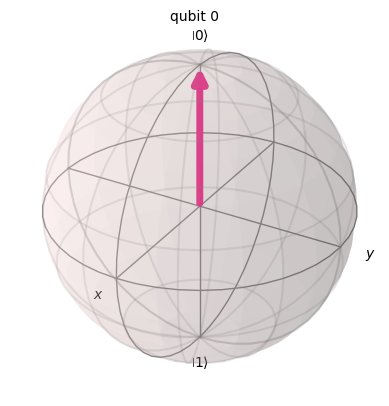

In [14]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

qc = QuantumCircuit(1)
qc.s(0)
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

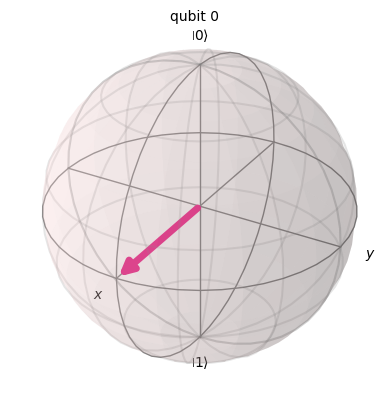

In [15]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

qc = QuantumCircuit(1)
qc.s(0)
qc.h(0)
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

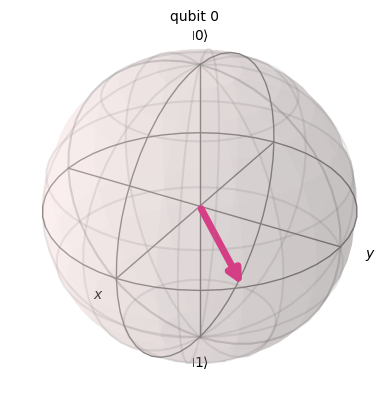

In [16]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

qc = QuantumCircuit(1)
qc.s(0)
qc.h(0)
qc.t(0)
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

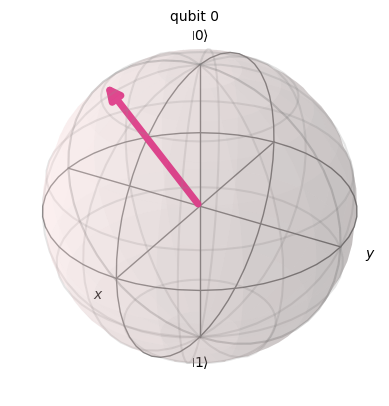

In [17]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

qc = QuantumCircuit(1)
qc.s(0)
qc.h(0)
qc.t(0)
qc.h(0)
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

Banalmente, $X$ si ottiene con una porta di Hadamard (non a caso, si chiama anche base di Hadamard), mentre $Z$ - essendo base computazionale - non necessita alcun allineamento.

**N.B.**: se si dovesse ricevere l'errore:

```bash
    PanicException: called Result::unwrap() on an Err value: TargetKeyError { message: "[PhysicalQubit(31)] not in Target" }
```

Significa che il traspilatore o il suo backend sta tentando di utilizzare un qubit (ovvero, `PhysicalQubit(31)`) non mappato nel backend o nella configurazione hardware; tipicamente apèpare quando nel circuito vengono inseriti più qubit logici di quelli che il backend supporta, o - più raramente -, non c'è una mappatura corretta tra il layout fisico dei qubit nel backend fisico e quelli del circuito. \
Inoltre, il quantum state vector per $n$ qubit richiede $2^n$ amplitudes complesse. For $30$ qubits:
$$
\text{Memory} = 16 \cdot 2^{30} = 16 \,\text{GiB} 
$$
Per $28$ qubits:
$$
\text{Memory} = 16 \cdot 2^{28} = 4 \,\text{GiB} 
$$
Cioè, una quadruplicazione della memoria, non supportabile su tutti i sistemi: motivo per cui è molto probabile che possa verificarsi errore. \
Infine, dal seguente frammento di codice, scopriamo (solo a posteriori...) che Aer utilizza al più $29$ qubit.

In [2]:
from qiskit_aer import AerSimulator # type: ignore

AerSimulator().configuration().to_dict()

{'backend_name': 'aer_simulator',
 'backend_version': '0.17.0',
 'n_qubits': 29,
 'basis_gates': ['ccx',
  'ccz',
  'cp',
  'crx',
  'cry',
  'crz',
  'cswap',
  'csx',
  'cu',
  'cu1',
  'cu2',
  'cu3',
  'cx',
  'cy',
  'cz',
  'diagonal',
  'ecr',
  'h',
  'id',
  'mcp',
  'mcphase',
  'mcr',
  'mcrx',
  'mcry',
  'mcrz',
  'mcswap',
  'mcsx',
  'mcu',
  'mcu1',
  'mcu2',
  'mcu3',
  'mcx',
  'mcx_gray',
  'mcy',
  'mcz',
  'multiplexer',
  'p',
  'pauli',
  'r',
  'roerror',
  'rx',
  'rxx',
  'ry',
  'ryy',
  'rz',
  'rzx',
  'rzz',
  's',
  'sdg',
  'store',
  'swap',
  'sx',
  'sxdg',
  't',
  'tdg',
  'u',
  'u1',
  'u2',
  'u3',
  'unitary',
  'x',
  'y',
  'z',
  'break_loop',
  'continue_loop',
  'delay',
  'for_loop',
  'if_else',
  'initialize',
  'kraus',
  'qerror_loc',
  'quantum_channel',
  'reset',
  'roerror',
  'save_amplitudes',
  'save_amplitudes_sq',
  'save_clifford',
  'save_density_matrix',
  'save_expval',
  'save_expval_var',
  'save_matrix_product_state',
 

Ecco, dunque, una prima implementazione del protocollo E91, ispirato anche a questo [codice](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/e91_qkd/e91_quantum_key_distribution_protocol.ipynb), che fa uso delle basi classiche.

In [ ]:
from package import E91 # vedi nel package dedicato, per simularlo vai nella sezione "Simulazione"

Nell'implementazione del protocollo si utilizza il simulatore matematico `AerSimulator` che, per quanto avanzato, possiede comunque alcune limitazioni intrinseche legate al suo funzionamento e all'approccio computazionale alla simulazione di sistemi quantistici. \
Questi limiti possono influire sugli esperimenti:

1. precisione numerica: usa la rappresentazione a precisione finita `float64` dei numeri reali e complessi, il che significa che:
    - operazioni come le somme, le moltiplicazioni e i calcoli trigonometrici accumulano errori di rounding;
    - la precisione può influire sulla simulazione delle correlazioni nei test CHSH, soprattutto quando il numero di qubit o di iterazioni cresce.
    - dunque: piccoli errori nei calcoli di $\mathbb{E}(a, b)$ o nel parametro $S$ possono causare oscillazioni oltre il valore $2\sqrt{2}$.

2. sampling probabilistico: `AerSimulator` non simula direttamente le ampiezze di probabilità: invece, genera campioni da distribuzioni probabilistiche simulate, che introduce:
    - errori statistici: anche con un alto numero di ripetizioni (2048 o più), i risultati possono fluttuare;
    - fluttuazioni nei risultati discreti: poiché i campioni sono interi $\pm 1$, le medie calcolate possono discostarsi dal valore teorico atteso.
    - dunque: il risultato delle misure discrete $\pm 1$ potrebbe non convergere esattamente al valore teorico $1/\sqrt{2}$ senza un numero estremamente elevato di campioni: solo per un numero di campioni $N \to \infty$ otterremmo il valore teorico.

3. mancanza di simulazione del "rumore fisico naturale": `AerSimulator` assume, di default, un sistema **ideale** senza rumore:
    - tuttavia, i dispositivi reali presentano fenomeni come decoerenza o dephasing, che influenzano i risultati del test CHSH;
    - anche in modalità rumorosa, il modello di rumore può non rappresentare accuratamente un sistema fisico realistico.
    - dunque... i risultati potrebbero essere più ideali rispetto a ciò che accadrebbe su hardware quantistico reale, oppure divergenti in situazioni specifiche.

4. gate non supportati o conversione automatica:
    - utilizzando gate non nativi (come rotazioni arbitrariamente definite), `AerSimulator` può tentare di decomporli in gate standard (come $U3$ e $CX$);
    - questa decomposizione potrebbe introdurre errori aggiuntivi;
    - dunque: se le basi sono rappresentate da rotazioni complesse, il simulatore potrebbe approssimarle, influenzando le misure.

#### Loopholes

In circa il $50\%$ degli esperimenti eseguiti senza rumore il parametro $S$ supera il valore di massimo entanglement $2 \sqrt{2}$: ed effettivamente, sembra esserci qualcosa che non va. Queste fluttuazioni prendono il nome di **loopholes** (ovvero, *lacune*), in quanto mostra come, sperimentalmente parlando, siano presenti delle lacune di "un qualche tipo" che non rendono coerente i risultati pratici con quelli teorici. In realtà, in questi esperimenti è più che normale la presenza di fluttuazioni statistiche. \
Le cause di un loophole possono essere parecchie:

- loophole statistico (derivante dal **finite sample loophole**): per quanto **numerosi** possano essere i campioni utilizzati nell'esperimento, questi campioni (le misure di Alice e Bob) sono comunque limitati ai fini del calcolo di $\mathbb{E}(a_i, b_j)$:
   + inevitabilmente, essendo finito il campionamento, si introducono fluttuazioni statistiche che possono produrre valori di $S > 2 \sqrt{2}$;
   + banalmente, per $N \to \infty$ queste fluttuazioni vengono mitigate. Poiché non esiste tipicamente un ampio pool di risultati, è possibile utilizzare tecniche statische per stimare la **significatività** della violazione, per esempio il *p-value* o gli *intervalli di confidenza*;  
- si ricordi che, inoltre, le misure sono soggette a ulteriori fluttuazioni statistiche a causa di `AerSimulator`.

In particolare, ci può interessare valutare gli **intervalli di confidenza**: questo è definito dalla formula:
$$
CI = \mathbb{E}(X) \pm z \cdot \text{SEM}
$$
Dove:

- $\text{SEM}$: errore standard della media, definita come $\sigma / \sqrt{N}$ 
- $\mathbb{E}(X)$ è la media del campione $X$
- $N$ è il numero di campioni
- $\sigma$ è la deviazione standard
- $z$ è il valore della distribuzione cumulativa, valore tabellato (o individuabile tramite calcolatore).

Un tipico esercizio per l'individuamento del $CI$ è per esempio:
$$
P \bigg( -z \le \frac{\mathbb{E}(X) - \mu}{\sigma / \sqrt{n}} \le z \bigg) = 1 - \alpha = 0.95
$$
Dove si cerca un intervallo di confidenza al $95\%$ per $\mu$: utilizzando le tabellature delle distribuzioni normali, si cercano i valori di $z$ per $\mathcal{N}(\mu; \sigma^2)$ che forniscono il valore $0.95$. \
Consideriamo ora le due definizioni:

- stima puntuale: è lo specifico valore assunto da una statistica, calcolata in corrispondenza dei dati campionari e che viene utilizzata per stimare il vero valore non noto di un parametro di una popolazione;
- stimatore per intervallo: è un intervallo costruito attorno allo stimatore puntuale, in modo tale che sia nota e fissata la **probabilità** che il parametro appartenga all'intervallo stesso: questa probabilità prende il nome di **livello di confidenza**;
- livello di confidenza: detta anche copertura, è il complemento a uno del **livello di significatività** $\alpha$: ad esempio, un intervallo di confidenza al $1 - \alpha = 0.95$ corrisponde a un livello di significatività pari a $\alpha = 0.05$;
- significatività: è la "possibilità rilevante" che compaia un determinato valore. Più in particolare, è la probabilità che il parametro si trovi al di fuori dell'intervallo di confidenza.

Quindi, la confidenza è il grado di fiducia che l'intervallo possa contenere effettivamente il parametro di interesse.

In [29]:
from package import E91 
import numpy as np # type: ignore
from scipy.stats import sem, norm # type: ignore

def E91_Confidence_Interval(number_of_singlets: int, eavesdropper: bool = False, confidence: float = 0.95, verbose: bool = True) -> list:
    """
    Calcola l'intervallo di confidenza (default 95%) per il parametro CHSH dall'E91.
    Ritorna: [chsh_value, (lower_bound, upper_bound)]
    """

    def __homogenize_samples__(chsh_samples) -> np.ndarray:
        """
        Accetta:
          - chsh_samples: dict (es. {(0,0): [...], ...}) oppure list of lists
        Ritorna:
          - numpy array shape (n_settings, min_length) con dtype float
        """

        # convert to list of lists
        if isinstance(chsh_samples, dict):
            lists = list(chsh_samples.values())
        elif isinstance(chsh_samples, (list, tuple, np.ndarray)):
            lists = list(chsh_samples)
        else:
            raise TypeError("chsh_samples deve essere dict o lista di liste")

        if len(lists) == 0:
            raise ValueError("chsh_samples vuoto")

        # ensure all elements are sequences
        lists = [list(l) for l in lists]

        # find minimum length and trim all lists to that length
        min_length = min(len(l) for l in lists)
        if min_length == 0:
            raise ValueError("Almeno una lista in chsh_samples è vuota")

        trimmed = [l[:min_length] for l in lists]
        return np.array(trimmed, dtype=float)

    # --- run protocol (assumo che E91 e .run() siano definiti altrove) ---
    protocol = E91(number_of_singlets = number_of_singlets, eavesdropper = eavesdropper, verbose = verbose)
    results = protocol.run()

    # attenzione: uso il parametro results["chsh_samples"]
    reduced_chsh_samples = __homogenize_samples__(chsh_samples = results["chsh_samples"])

    # calcolo SEM per riga (per setting)
    std_err_per_setting = sem(reduced_chsh_samples, axis=1)
    total_std_err = np.sqrt(np.sum(std_err_per_setting ** 2))

    percentile = norm.ppf((1 + confidence) / 2.0)

    chsh_value = float(results["chsh"])
    margin = percentile * total_std_err
    lower_bound = chsh_value - margin
    upper_bound = chsh_value + margin

    if verbose:
        print("\n>>> Analisi statistica\n")
        print(f"- numero di campioni: {number_of_singlets}")
        print(f"- margine di errore statistico: {margin:.6f}")
        print(f"- intervallo di confidenza al {confidence * 100:.0f}%: [{lower_bound:.6f}, {upper_bound:.6f}]")

    return [chsh_value, (lower_bound, upper_bound)]


Si nota come gli intervalli di confidenza siano uno strumento potente per dimostrare che un esperimento abbia o meno violato il realismo locale in modo significativo, e che i risultati non superano il limite quantistico $2\sqrt{2}$. \
Passo passo vediamo come verificare le due cose:

1. verifica della violazione del realismo locale:

   - si controlla l'intervallo di confidenza: se l'intervallo di confidenza al $95\%$ (o altro livello di significatività) **non include $S = 2$**, allora possiamo affermare con confidenza che il sistema ha violato il realismo locale;
   - anche se il valore calcolato di $S$ può essere soggetto a errori di rounding, fluttuazioni statistiche o altri fattori, l'intervallo di confidenza **tiene conto** di queste incertezze;
   - consideriamo il seguente output:

        ```python
            Numero di campioni: 10000
            Parametro CHSH: -2.863158
            Intervallo di confidenza al 95%: [-2.946395, -2.779920]
            Differenza dal valore teorico: 0.034730
        ```

       Analizzandolo, osserviamo che:
       + l'intervallo di confidenza è $[-2.946395, -2.779920]$
       + e che $S \notin [-2.946395, -2.779920]$, quindi possiamo concludere che c'è stata una violazione significativa di realismo locale.

2. verifica che $S$ non superi il limite quantistico: confermare che il sistema si comporta coerentemente con la teoria quantistica $|S| \leq 2\sqrt{2}$.
   - controllo dell'intervallo di confidenza: se l'**intervallo di confidenza include** $2\sqrt{2} \approx 2.828$, allora il risultato è coerente con i limiti teorici quantistici.
   - consideriamo il precedente output:

        ```python
            Numero di campioni: 10000
            Parametro CHSH: -2.863158
            Intervallo di confidenza al 95%: [-2.946395, -2.779920]
            Differenza dal valore teorico: 0.034730
        ```

       Analizzandolo, osserviamo che:
       + l'intervallo di confidenza è $[-2.946395, -2.779920]$
       + e che $-2\sqrt{2} \in [-2.946395, -2.779920]$
          - ovvero, l'esperimento è considerabile valido con un grado di confidenza del 95%;
          - in particolare, possiamo notare che il limite superiore dell'intervallo, cioè $-2.773487$, è maggiore di $- 2\sqrt{2} \approx - 2.828$, quindi il risultato è coerente.

Vediamo come funzionano gli intervalli di confidenza: 

In [30]:
values = E91_Confidence_Interval(number_of_singlets = 512, eavesdropper = False, verbose = True)

Progresso: 100.0%
>>> Report dell'esperimento

- valori attesi:                                -0.7333, 0.6471, -0.6786, -0.7200
- parametro CHSH:                               -2.778963585434173
- chiave di Alice:                              0001010000001000010111001001101101001000100001010110110110110001101010100000101001101011000110100010111000000101010
- chiave di Bob:                                0001010000001000010111001001101101001000100001010110110110110001101010100000101001101011000110100010111000000101010
- esito del test di Bell:                       ✓ realismo locale violato: nessuna presenza di un intercettatore

>>> Informazioni aggiuntive

- frequenza delle basi di Alice e Bob:          {'W': 54, 'Z': 61}
- lunghezza della chiave di Alice e Bob:        115
- efficienza della chiave di Alice e Bob:       22.4609%
- bit di chiave differenti tra Alice e Bob:     0
- Quantum Bit Error Rate (QBER):                0.0000%
- coincidence counting:                         363

Un esperimento che si è verificato è stato:

```python
    >>> Analisi statistica
    
    - numero di campioni: 512
    - margine di errore statistico: 0.439489
    - intervallo di confidenza al 95%: [-3.218453, -2.339474]
```

Che è totalmente invalidato e deve essere scartato, essendo il limite superiore minore di $-2 \sqrt{2}$: dovrebbe necessariamente includere il valore limite. \
Sono situazioni che possono tranquillamente verificarsi a causa di oscillazioni statistiche.

### Indici di misura classici

Delle volte, per quanto un canale possa essere rumoroso, è possibile adottare codici di correzione dell'errore (come i **Low-Density Parity-Check** codes), però è necessario capire quanto ne "valga la pena": ristabilire più volte una sessione può essere oneroso e se può essere possibile, senza ledere alla sicurezza delle parti comunicanti, stabilire che la "*connessione è sicura*", allora è utile individuare **metri di misura** di questo tipo. \
Oltre al parametro CHSH, uno di questi l'abbiamo già visto, ed è il fattore di privacy $\mathcal{P}$, però estendiamo la definizione e le metriche sulla base del rumore del canale e della presenza di un intercettatore.

#### QBER
Il QBER (**Q**u**B**it **E**rror **R**ate) è una metrica che evidenzia il tasso di errore medio presente nel canale, ed è indice di un canale sicuro e "pulito". \
Il QBER per una simulazione è il rapporto - approssimativo, essendo ottenuto da un numero finito di esperimenti - tra il numero di bit chiave discordanti tra Alice e di Bob e il numero di qubit totali *ricevuti* (che sono quelli di chiave, nella fattispecie).

$$
\text{QBER} = \frac{\text{mismatching bits between Alice and Bob}}{\text{key length}}
$$

#### Fattore di privacy

Il fattore di privacy è una metrica analizzata già in precedenza che ci dice se un canale quantum $\mathcal{E}$ possa definirsi o meno sicuro. \
Fondamentalmente, è un limite superiore $\mathcal{P} \ge I(\rho, \mathcal{E})$ che si serve della quantum coherent information (estesa più sotto per più facile comprensione).

$$
I(\rho, \mathcal{E}) = S(\rho^B) - S(\rho^E) = - \text{Tr}\, \rho^B \log_2 \rho^B + \text{Tr}\, \rho^E \log_2 \rho^E
$$

Ovvero, la privacy è assicurata se:

$$
\mathcal{P} \ge - \text{Tr}\, \rho^B \log_2 \rho^B + \text{Tr}\, \rho^E \log_2 \rho^E
$$

L'entropia di Von Neumann è possibile calcolarla tramite il modulo apposito `qiskit.quantum_info.entropy`.

In [ ]:
from numpy import sqrt # type: ignore
from qiskit.quantum_info import Statevector, entropy # type: ignore

sv = Statevector([1 / sqrt(2), 0, 0, - 1 / sqrt(2)])
s = entropy(sv)
s

Definiamo dunque una funzione che possa calcolare la coherent information: sarà nulla per stati puri, e $\log_2 N$ per stati massimamente entropici. \
**P.S.**: questa metrica è più utile, in realtà, per protocolli come BB84.

#### Tempo di esecuzione

Il tempo di esecuzione dell'algoritmo è anche un indice dell'efficienza del protocollo (certo, poi dipende da quanto bene o meno sia scritto il codice...) e un modo semplice per misurarlo è il module `time` di Python.

In [ ]:
import time

start_time = time.time()

# codice...
for _ in range(1000000):
    pass
# codice...

print(f'Execution time: {time.time() - start_time}\n')

In effetti, più del tempo di esecuzione - che è molto "vago" e poco preciso - è più utile calcolare il **costo computazionale**.

## Ricerca di un'intercettatore nell'E91 con il machine learning

### Installazione delle dipendenze

Si consideri che quanti più sono i dati raccolti, quante più informazioni si possono estrapolare sul "funzionamento tipo" del protocollo in determinate situazioni: ambiente ideale, rumore e intercettazione. \
Prima, installiamo i moduli necessari (utilizzeremo anche [XGBoost](https://xgboost.readthedocs.io/en/stable/get_started.html), invece [qui](https://www.nvidia.com/en-us/glossary/xgboost/) una breve spiegazione di cosa sia):

In [ ]:
%pip install --upgrade pip
%pip install scikit-learn xgboost

Si faranno una serie di esperimenti dove, con casualità:

- si sceglieranno i parametri di ingresso (che devono essere salvati) per esempio `eavsdropper`: $0$ per `no`, $1$ per `yes`. Per ora ci concentreremo solo sul caso "intercettazione";
- i risultati che verranno salvati sono per esempio il parametro $S$ e il QBER.

Dopo aver raccolto i dati, si eseguirà l'addestramo su un algoritmo di machine learning tramite i dati di input ($S$, QBER, Mismatched bits), cercando di individuare correttamente il target (in questa situazione non nota, c'è un'intercettazione oppure no?). \
In tutto l'esperimento, i parametri di input saranno tali che il protocollo sarà o sotto attacco, o all'interno di un canale fortemente rumoroso.

### Esperimenti più vicini al mondo reale

#### Modelli di rumore

Finora, i dati raccolti hanno rispecchiato un tipo di rumore molto "semplice", ovvero:

```python
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ["cx"])
    error_meas = pauli_error([("X", 0.1), ("I", 1 - 0.1)]) # con il 10% di probabilità, applica un bit-flip X (NOT) prima della misura, e con il probabilità 90%, applica il gate I (non fare nulla). 
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    backend = AerSimulator(noise_model = noise_model)
```

Che sono rispettivamente:

- errori di depolarizzazione;
- errore di misura, modellato in modo che nel $10\%$ dei casi, si esegua un bit-flip (ecco a che serve la porta $X$);
- ...entrambi gli errori sono applicati a TUTTI i qubit, `.add_all_qubit_quantum_error()`.

Ma noi vogliamo utilizzare, possibilmente, un processore IBM, però... 10 minuti al mese non sono sufficienti, e il simulatore di processore è molto lento (simula abbastanza fedelmente un processore e impiega 10-15 minuti per 512 singoletti): dunque, tentiamo di estrarre le caratteristiche rumorose di `FakeAlmadenV2` per inserirle nel modello di `AerSimulator`.

Tipici errori sono quelli di **readout**, **termico** (o di decoerenza) e di gate:

- l'errore di **readout**, o di misura, si verifica a causa di dispositivi mal calibrati o difettati: in fase di misura, quando un qubit collassa in $0$ o $1$, la misura avvien in maniera errata:
    
    + tipicamente, $M(\ket{0}) = 0$ e $M(\ket{1}) = 1$;
    + invece, $M(\ket{0}) = 1$ e $M(\ket{1}) = 0$ con una certa probabilità $p$.
  
    Matematicamente parlando, questo si esprime per esempio come:
        $$
        \begin{bmatrix}
            P(0|0) & P(1|0) \\ 
            P(0|1) & P(1|1)
        \end{bmatrix}
        =
        \begin{bmatrix}
            1 - p_0 & p_0 \\ 
            p_1 & 1 - p_1
        \end{bmatrix}
        = 
        \begin{bmatrix}
            0.98 & 0.02 \\ 
            0.03 & 0.97
        \end{bmatrix}
        $$
        
    Che a livello di codice, è descritto dalle variabili:
        
    + probabilità di misurare $1$, quando dovrebbe essere $0$, `prob_meas1_prep0 = 0.02`;
    + probabilità di misurare $0$, quando dovrebbe essere $1$, `prob_meas1_prep1 = 0.03`. 

    Un esempio di codice è il seguente:

    ```python
        from qiskit_aer.noise import ReadoutError

        # definizione delle probabilità di readout error
        p0 = 0.02 # probabilità di flippare 0 in 1
        p1 = 0.03 # probabilità di flippare 1 in 0

        # creazione della readout error matrix
        readout_error = ReadoutError([
            [1 - p0,    p0],
            [p1,    1 - p1]
        ])

        # applicazione al qubit 0 nel noise model
        noise_model.add_readout_error(readout_error, [0])
    ```

    Si osservi che, essendo un errore di lettura (da parte di dispositivi fisici), di fatto, **non modifica lo stato quantistico del qubit prima della misura**, ma ne cambia il valore misurato. \
    Piccola digressione: se volessimo simulare un **errore quantistico** - che non simula rumore nel canale, ma più rumore di dispositivi di misura -, si può anche utilizzare:

    ```python
        from qiskit_aer.noise import pauli_error

        error_meas = pauli_error([("X", 0.1), ("I", 0.9)])
        noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    ```

    Come visto in principio (i suoi effetti li abbiamo già analizzati).

- l'errore **termico**, per spiegarlo, necessita l'introduzione della **decoerenza**. \
    La decorenza si verifica quando un qubit "perde" il suo stato quantico originale nel corso del tempo, e succede quando il qubit (un fotone) **interagisce** con l'ambiente circostante, **_perdendo (non volutamente) energia_**. \
    Però, come si verifica la decoerenza? In due modi possibili:

    + **amplitude damping** (smorzamento) o energy relaxation $T_1$: rappresenta la "velocità" (il tempo impiegato) con cui un qubit perde la sua energia e cade nel ground state $\ket{0}$;
    + **phase damping** o dephasing (sfasamento) $T_2$: rappresenta la velocità con cui si perde lo stato di superposizione. \
        Questo è molto più particolare in quanto più "quantum-related": fondamentalmente, dato un qubit:
        $$
        \ket{\psi} = \alpha \ket{0} + \beta \ket{1}
        $$
        Dice quanto velocemente $\alpha, \beta$ perdono la loro **relazione di fase**. \
        Com'è noto, uno stato si può anche scrivere nella forma:
        
        $$
        \ket{\psi} = \cos \frac{\theta}{2} \ket{0} + e^{i \phi} \sin \frac{\theta}{2} \ket{1}
        $$
        
        E qui...
            
        - $\theta$ determina la probabilità di misurare $0$ o $1$;
        - $\phi$ determina la fase relativa, e influisce sull'**_interferenza_**. Cosa significa?
            + un basso $T_2$ significa che $\phi$ cambia randomicamente (a causa delle interazioni con l'ambiente);
            + il qubit, dunque, rimane sì in superposiziopne, ma perde "coerenza di fase": cioè, le operazioni quantiche sono meno affidabili.
       
        Il modello matematico del phase damping, utilizzando una density matrix $\rho$ come:
        
        $$
        \rho = \frac{1}{2}
        \begin{bmatrix}
            1 & e^{i \phi} \\ 
            e^{- i \phi} & 1
        \end{bmatrix}
        $$
        
        Dopo un certo tempo $t$, a causa del dephasing $T_2$, si evolve in: 

        $$
        \rho' = \frac{1}{2}
        \begin{bmatrix}
            1 & e^{-\frac{1}{T_2} + i \phi} \\ 
            e^{-\frac{1}{T_2} - i \phi} & 1
        \end{bmatrix}
        $$

        Possiamo notare che quanto maggiore è $T_2$, quanto minore è l'effetto della decoerenza: però, se è molto piccolo, i valori antidiagonali nel sistema tendono a $0$ e perdono coerenza di fase. \
        Nel mondo reale, i qubit superconduttivi hanno un fattore $T_2 \approx 100 \,\mu s$, mentre per gli ioni intrappolati $T_2 \approx s$, utile per calcoli a lungo termine.

    Si osservi che:

    + se $T_1$ è basso, il qubit decresce velocemente a $\ket{0}$;
    + se $T_2$ è basso, la superposizione è molto meno affidabile.

    Un esempio di codice è il seguente:
    
    ```python
        from qiskit_aer.noise import thermal_relaxation_error
        
        # definiamo i tempi T1, T2 (in microsecondi): il gate time rappresenta il tempo in cui viene esecuguito il gate, e determina quanto T1 e T2 occorre durante un singolo gate 
        T1 = 50e-6 # 50 ms
        T2 = 40e-6 # 40 ms
        gate_time_single = 50e-9 # si assume 50 ns di gate time
        gate_time_cx = 300e-9 # si assume 300 ns di gate time per CX
        
        # applica l'errore di decoerenza al gate identità
        thermal_noise_single_qubit = thermal_relaxation_error(T1, T2, gate_time_single)
        noise_model.add_quantum_error(thermal_noise_single_qubit, ["id"], [qubit])

        # applica l'errore di decoerenza al gate CX
        thermal_noise_cx = thermal_relaxation_error(T1, T2, gate_time_cx)
        noise_model.add_quantum_error(thermal_noise_cx, ["cx"], [qubit])
    ```

    È possibile **stimare** gli errori di altri gate, come per esempio $\text{CX}$, nel seguente modo:

    ```python
        backend_properties = fake_almaden_backend.properties()
        for gate in backend_properties.gates:
            if gate.gate == "cx":  # Check CX gate
                print(f"CX gate time: {gate.parameters[0].value} seconds")
    ```
    
    Altrimenti, si possono utilizzare i valori approssimati $50 \,ns$ per gate a singolo qubit e $300 \,ns$ per il gate $\text{CX}$.

- l'errore di **gate**, o Quantum Gate Imperfections, è un tipo di errore che si verifica intrinsecamente quando gli operatori quantici come $X, H, \text{CX}, $ etc. non si eseguono perfettamente.
    
    + in un computer quantistico, $X\ket{0} = \ket{1}$ ma la presenza di imperfezioni induce una probabilità $p$ che ciò non si verifichi;
    + distinguiamo, in particolare, due tipi di errore:
        - errore di **depolarizzazione**: un gate ha una piccola probabilità $p$ di trasformare lo stato $\rho$ in uno stato **totalmente misto** $I/2$ (si verifica a causa di impulsi di controllo *imprecisi*);
        - errore di **sovrarrotazione**: invece di ruotare rispetto a un angolo $\theta$, la rotazione avviene di un angolo $\theta + \varepsilon$, e si può accumulare se i gate sono tanti.
    
    Un esempio di codice è il seguente:

    ```python
        from qiskit_aer.noise import depolarizing_error

        # si definisce la probabilità di depolarizzazione, in particolare del 0.5%
        p = 0.005

        # si crea rumore di depolarizzazione per gate a single-qubit
        single_qubit_gate_error = depolarizing_error(p, 1)

        # si applica a tutti i gate U3
        noise_model.add_quantum_error(single_qubit_gate_error, ["u3"])
    ```

    La depolarizzazione è il tipo di errore che più si avvicina alla simulazione di rumore ed errori trasmessi in un canale.

#### Come estrarre le proprietà di un backend reale?

La struttutra delle proprietà di un backend è la seguente:

```python
    {
        "backend_name": "ibmq_almaden",
        "backend_version": "1.4.6",
        "last_update_date": "2020-08-10T02:28:54Z",
        "qubits": [...]
        "gates": [...],
        "general": [...],
    }
```

E le proprietà sugli errori sono conservati nelle key `qubits` e `gates`. \
La successiva funzione ci aiuta a estrarre e dumpare in JSON le informazioni sopra elencate. 

In [ ]:
from package import noise_model_to_json # vedi nel package dedicato

Supponiamo di voler estrarre le proprietà di diversi backend reali: già siamo in possesso delle proprietà di IBM Quantum Brisbane. \
In primis, ci colleghiamo ai servizi cloud IBM:

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService # type: ignore

TOKEN = "ff18c76fe2d2b6755501c823de21301519c2a091a4a1e777ee0ed66f447de5f8b7b08a1035a5ace038e0caf5c6d40e225a721adadcf9e18dd61ba6f6f4cb1d86"
service = QiskitRuntimeService(channel = "ibm_quantum", token = TOKEN)

`QiskitRuntimeService().backends()` ritorna tutti i backend accessibili dall'account:

In [ ]:
backends = service.backends(simulator = False, operational = True)
backends

In [ ]:
from package import noise_model_to_json

for backend in backends:
    noise_model_to_json(backend = backend)

E il codice analogo che ci consente di "caricare" un modello di rumore dal medesimo file JSON.

In [ ]:
from package import noise_model_from_json # vedi nel package dedicato

Riscrivo in maniera ancora più efficiente il codice del protocollo E91 in modo che questi sia capace di accogliere un backend a libera scelta.

In [ ]:
from package import E91

#### **Digressione**: analisi del costo computazione del protocollo

Il loop principale è:

```python
    # [...]: import e assegnazioni, tutte di costo unitario O(1)

    for i in range(number_of_singlets):

        circuit = create_singlet() # O(1)
        circuit = apply_bases(qc = circuit, alice_basis = alice_measurement_bases[i], bob_basis = bob_measurement_bases[i]) # O(1)

        if eavesdropper: # abilitato o meno, è O(1) 
            eve_basis_to_alice, eve_basis_to_bob, eve_result_to_alice, eve_result_to_bob = __eve_intercepts__(qc = circuit, cr = eve_classical_register, input_bases = input_bases) # O(1)

        circuit.measure(0, 0) # O(1)
        circuit.measure(1, 1)

        alice_result, bob_result = __extract_results__(qc = circuit) # O(1): è l'unica funzione cruciale che dipende FORTEMENTE dal backend utilizzato (o meglio, dal rumore presente nel backend)

        if eavesdropper:
            # [...] serie di confronti, tutte operazioni che richiedono O(1) 

        if alice_measurement_bases[i] == bob_measurement_bases[i]:
            # [...] serie di confronti, tutte operazioni che richiedono O(1) 
        
        elif (alice_measurement_bases[i], bob_measurement_bases[i]) in chsh_bases_test:
            # [...] serie di confronti, tutte operazioni che richiedono O(1) 

    # [...] solamente la funzione __compute_evs__(chsh_samples = chsh_samples) è "rilevante" in quanto cicla su un numero di elementi chsh_samples < number_of_singlets AL DI FUORI del ciclo for: dunque, il costo finale della funzione è O(number_of_singlets) + O(chsh_samples) = O(number_of_singlets)
```

Analizziamo i passaggi principali:

- la parte preliminare di codice (import, assegnazioni) hanno costo unitario e trascurabile, quindi ci si può concentrare nel loop `for i in range(number_of_singlets)`;
- la parte finale di codice, fuori dal ciclo for, ha al più una funzione di calcolo degli EVs che cicla su un numero di elementi minore di `number_of_singlets`, quindi trascurabile;
- in mezzo al codice, l'unico elemento "sospetto" è la funzione `__extract_results__(qc = circuit)`, in quanto al suo interno viene eseguito il sampling tramite il `qiskit_ibm_runtime.SamplerV2`: essendo però il numero di shot impostati a $1$, di fatto è un $O(1)$:
    + l'operazione `pm.run(qc)` è un $O(1)$ per circuiti piccoli, come il singoletto di input;
    + l'operazione `sampler.run()`, invece, può alterarsi a seconda di potenziale rumore nel backend. È l'operazione che fondamentalmente è **sensibile al backend** e può rallentare l'esecuzione: se il backend fosse `AerSimulator()` senza rumore, è approssimabile a $O(1)$;
    + le operazioni di `.get_counts()` e di iterazione su `counts.items()` sono entrambe $O(1)$, la seconda in particolare essendo un dizionario di solo $4$ elementi $00, 01, 10, 11$ su cui iterare (quindi, l'iterazione è fissa).

Dunque, detto $n$ il numero di singoletti in input, il costo della funzione è (la presenza di interecettazione è abbastanza indifferente):

- $O(n)$ per un canale ideale;
- $O(n) + O(\varepsilon)$ per un canale con errore di readout e di decoerenza;
- $k \cdot O(n) + O(\varepsilon)$, per un canale con errore di readout, di decoerenza e di gate: stima personale e basata sugli esperimenti fatti, $k \approx 12$-$15$.

#### **Digressione**: perché l'errore di gate induce una latenza così alta?

Gli **errori di gate** introducono modificano direttamente **ogni operazione quantistica** e aumentano la complessità computazionale della simulazione, inducendo conseguentemente un'alta latenza: per questo motivo hanno un impatto molto maggiore rispetto agli errori di readout o decoerenza sulla velocità di esecuzione di un esperimento.

Innazitutto, come già introdotto, gli errori di gate introducono degli stati misti: quando in un backend simulato è presente un errore di gate, ogni operazione quantistica può trasformare lo stato del sistema da $\rho$ a $I/2$. Quali sono le differenze principali tra una simulazione ideale e non?

- la simulazione ideale utilizza **vettori di stato**, che scalano **polinomialmente** con il numero di qubit;  
    + in questo caso, si mantiene la dimensione dello stato in $2^n$.
- la simulazione con errori di gate deve usare **matrici densità** o **metodi Monte Carlo**, che hanno scalabilità **esponenziale**.
    + poiché deve simulare stati misti, che richiedono **matrici densità**, lo stato aumenta a $4^n$ (lo spazio degli stati cresce quadraticamente).

Dunque, il costo computazionale aumenta di **_almeno_** un fattore $O(4^n)$ invece di $O(2^n)$. \
Qual è la grossa differenza tra i tre tipi di errori?

| Tipo di Errore  | Effetto Computazionale | Impatto sulla Latenza |
|-----------------|----------------------|------------------|
| **Gate error**  | Converte stati puri in misti, richiede simulazione con **matrici densità**. | **Molto alto ($6$ min)** |
| **Readout error** | Applicato **solo alla fine**, modifica i risultati classici senza alterare lo stato quantistico. | **Basso ($30$-$40$ s)** |
| **Decoerenza** $(T_1, T_2)$ | Si applica con **errori di rilassamento termico**, ma spesso con bassi tassi di errore: **spesso è ignorabile** nel simulatore. | **Basso ($30$-$40$ s)** |

Dunque, osserviamo che:
- errore di readout: si applica dopo le misure, quindi influisce solo sulla statistica dei risultati ma non sulla propagazione dello stato;
- errore di eecoerenza: è legato ai tempi di rilassamento $T_1, T_2$, e se i tempi sono lunghi rispetto al gate time, l'effetto è inoltre **trascurabile**;
- errori di gate: colpiscono **_OGNI_** operazione quantistica, moltiplicando il numero di stati da simulare.

Dunque, errore di readout e di decoerenza hanno un impatto minore, e disabilitare gli errori di gate riduce drasticamente la latenza perché la simulazione può rimanere nello spazio degli **stati puri** anziché gestire **stati misti**.

---

Ora, però, la domanda sorge spontanea: perché il metodo matriciale è più oneroso del metodo vettoriale? \
La **differenza di impatto** tra i due metodi nella simulazione quantistica deriva da come crescono le dimensioni dello stato quantistico e dalla complessità delle operazioni richieste per aggiornarlo.  

- una simulazione vettoriale (stati puri, senza errori di gate) cresce come $O(2^n)$;
- una simulazione matriciale (stati misti, con errori di gate) cresce come $O(4^n)$.  

Ma questo, era già stato detto. Facciamo retrofront. 

1. simulazione con stati puri (metodi vettoriali): se non ci sono errori di gate, la simulazione può utilizzare il formato di vettore di stato. Uno stato quantistico di $n$ qubit è un vettore complesso di dimensione $2^n$:
    
    $$
    \ket{\psi} = \begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \vdots \\ \alpha_{2^n - 1} \end{bmatrix}
    $$

    Come evolve il sistema?   
    Come sappiamo, ogni gate (o operazione quantistica) è rappresentato da una matrice unitaria $U$ di dimensione $2^n \times 2^n$, detto $n$ il numero di qubit, che agisce sul vettore:

    $$
    \ket{\psi'} = U \ket{\psi}
    $$

    Qual è il costo computazionale?

    - moltiplicare una matrice per un vettore ha costo $O(2^n);
    - il **simulatore vettoriale** è quindi **lineare** nel numero di operazioni ma **esponenziale** nel numero di qubit;  
    - per esempio, per $n = 10$ qubit, il vettore di stato ha dimensione $2^{10} = 1024$ elementi.


2. simulazione con stati misti (metodi matriciali): quando sono presenti errori di gate, il sistema può **perdere coerenza** e non può più essere descritto con un singolo vettore di stato. Invece, dobbiamo descrivere lo stato come una **matrice densità** $\rho$ di dimensione $2^n \times 2^n$:

$$
\rho = \sum_i p_i \ket{\psi_i} \bra{\psi_i}
$$

Come evolve il sistema, questa volta?

- l'evoluzione di uno stato misto non è più $\ket{\psi'} = U \ket{\psi}$;  
- ora dobbiamo **trasformare la matrice densità**:

    $$
    \rho' = U \rho U^\dagger
    $$

    E dunque, il suo costo computazionale sarà differente:  
    
    + la matrice $\rho$ ha $2^n \times 2^n$ elementi, (ovvero $4^n$ dimensioni);
    + e qui, il prodotto è tra due **matrici** - che ha costo $O(4^n)$ - non più tra matrice e vettore;
    + per esempio, per $n = 10$ qubit, la matrice di densità ha $2^{10} \times 2^{10} = 1024 \times 1024 = 1 048 576 $ (un bel po'...).

Dunque, i palesi svantaggi della simulazione matriciale sono:  

- maggior richiesta di memoria essendo la matrice densità **quadratica** nel numero di elementi rispetto al vettore;  
- complessità computazionale maggiore - $O(4^n$ invece di $O(2^n$ -, quindi diventa rapidamente impraticabile;  
- già solo per $10$ qubit servono **$1000$ volte più operazioni** rispetto alla simulazione vettoriale.


Mettendo a paragone gli effetto sul tempo di simulazione...

| **Numero di qubit** $n$ | **Dim. vettore di stato (stati puri)** $2^n$ | **Dim. matrice densità (stati misti)** $4^n$ | **Differenza di memoria** |
|-----------------|----------------------------|----------------------------|----------------|
| $5$ qubit | $32$ elementi | $1024$ elementi | **$32$ volte più grande** |
| $10$ qubit | $1024$ elementi | $1.048.576$ elementi | **$1024$ volte più grande** |
| $15$ qubit | $32.768$ elementi | $\approx 1$ miliardo di elementi | **$1$ milione di volte più grande** |

### Generazione degli esperimenti

Per la generaizone degli esperimenti, vogliamo ottenere quanto più informazioni possibili dai dati: per esempio, la skewness, la kurtosis e l'anticorrelazione dei samples. \
È utile estrarre informazioni oltre il parametro CHSH se l'ambiente è troppo rumoroso in quanto il solo parametro potrebbe confondersi con potenziali interecettazioni, dunque altre features potrebbero aiutare. 

#### Analisi del dataset tramite `pymfe` (Python Meta-Feature Extractor)

Un package molto utile per l'estrazione di features è `pymfe`: questa ci consente di estrarre delle così dette **meta-features**, cioè informazioni che descrivono le proprietà intrinseche di un dataset. Esempi sono:

- dimensione del dataset: numero di campioni e numero di feature;
- **distribuzione statistica**: medie, varianze, skewness, kurtosis delle feature;
- densità e percentuale di dati mancanti: informazioni sulla completezza dei dati;
- distribuzione delle classi: in problemi di classificazione multiclasse, ad esempio, il bilanciamento tra le diverse classi;
- metriche di complessità: ad esempio, la correlazione tra le variabili, la dimensionalità intrinseca o la dispersione dei dati.

Queste meta-features possono essere utilizzate per capire la natura del problema e per aiutare a scegliere il modello o la strategia di apprendimento più adeguata

In [ ]:
%pip install -U pymfe

Qui sotto un esempio con un codice:

In [ ]:
from pymfe.mfe import MFE # type: ignore

mfe = MFE(groups = ["statistical"])
mfe.fit([[0, 1, 2, 38, 2, 3], [0, 20, 20, 2, 3, 66]]) # se si addestra anche sul target, si ottengono altre meta-features
ft = mfe.extract(suppress_warnings = True)

print("\n".join("{:50} {:30}".format(x, y) for x, y in zip(ft[0], ft[1])))

Conserveremo gli indici delle posizioni di alcune features:

- 18: MAD.mean (Mean Absolute Deviation, utile per misurare di quanto i valori di ciascuna feature variano dalla mediana, calcolata su tutte le features), il .mean indica che si calcola poi la media sul valore di MAD valutato: questo varrà per ogni altra meta feature;
- 16: kurtosis.mean;
- 38: skewness.mean;

#### Media, varianza, skewness e kurtosis

Utilizziamo librerie come `scipy.stats` per ottenere skewness (asimmetria) e kurtosis (appiattimento).

In [ ]:
from package import get_chsh_samples_statistics # vedi nel package dedicato

#### Anticorrelazione nel test di Bell

Il test di Bell si esegue sulle basi non compatibili, e i risultati delle misure devono essere altamente anti-correlate per indicare l'assenza di un intercettatore: dunque, il risultato $-1$ indica una anticorrelazione, $+1$ indica una situazione di correlazione. \
Una discriminante è quanto questi valori oscillano dal loro valore atteso $1/\sqrt{2}$.

**Osservazione**: non tutti le basi del test di Bell sono anti-correlate: infatti, si ricorda che uno degli addendi viene invertito di segno per bilanciare la disuguaglianza CHSH. \
Si consideri il set di basi da noi utilizzato, $\Set{0, \pi/4, \pi/8}, \Set{\pi/4, \pi/8, 3\pi/8}$, il cui sottoinsieme per il test di Bell è:

$$
(0, \pi/8),
(0, 3\pi/8),
(\pi/8, \pi/4),
(\pi/8, 3\pi/8)
$$

Il secondo set, $(0, 3\pi/8)$, è l'unico a non essere anti-correlato ma correlato: cià significato che nel suo `chshs_samples`, saranno più presenti `1` che `-1`, e ciò significa che le misure di Alice e Bob non erano anti-correlate ma correlate (entrambi $+1$, o entrambi $-1$, e il prodotto produce $+1$). \
Dalla meccanica quantistica sappiamo che la **_MASSIMA CORRELAZIONE_** ideale tra due angoli è data da:

$$
\mathbb{E}(0, 3\pi/8) = - \cos 2 (0 - 3\pi/8) = \frac{1}{\sqrt{2}}
$$

Ma, a noi, interessano i valori anti-correlati. Detto $p(-1)$ la probabilità di ottenere valori anti-correlati, e $p(+1)$ la probabilità di ottenere valori correlati:

$$
p(-1) + p(+1) = 1 \qquad p(-1) + p(+1) = \mathbb{E} 
$$

Dunque:

$$
p(-1) = \frac{1 - \mathbb{E}}{2} = \frac{1 - 0.7071}{2} \approx 0.1464 = 14.64\%
$$

Ciò significa che, mentre le altre basi devono tendere al $70.71\%$, questa base deve tendere al $14.64\%$.

In [ ]:
from package import get_anticorrelation_distribution # vedi nel package dedicato

#### Generazione dei dataset

Ora, ci concentreremo sulla generazione del un nuovo dataset. \
Qui sotto, la funzione `experiments`, necessaria per generare il dataset di training e di test:

In [ ]:
from package import experiments # vedi nel package dedicato

Qui sotto la generazione dei dati di train:

In [ ]:
from package import experiments

experiments.generate(n = 10000, probability_range = [0.01, 0.20], output = "train_data.csv")

Separatamente, la generazione dei dati di test, che prevede anche l'assenza di rumore di depolarizzazione.

In [ ]:
from package import experiments

experiments.generate(n = 10000, probability_range = [0.00, 0.20], output = "test_data.csv")

Qualche volta, a causa delle oscillazioni statistiche di `AerSimulator`, potranno generarsi outlier - dati il cui CHSH è nullo o maggiore di $2\sqrt{2}$ - e quei dati verranno scartati. \
Qui sotto una vista di uno dei due dataset.

In [ ]:
import pandas as pd # type: ignore
import numpy as np
from package import utils

df = pd.read_csv("train_data.csv")
df = utils.extract(df = df)
df

Si osservi che (escluso il target, ovviamente), le colonne "Alice/Bob and Eve mismatched bits" andranno scartate in quanto sono informazioni correlate al target (essendo inaccessibili, danno implicitamente informazioni sulla presenza o meno di un intercettatore: cioè, **data leakage**). \
Al contrario, QBER e bit differenti tra Alice e Bob non sono privati (Charlie li può conoscere con la pre-shared key).

**N.B.**: la nomenclatura `CHSH samples mean (avg)`, `CHSH samples variance (avg)`, etc. fa riferimento ai samples utilizzati per il calcolo del parametro CHSH, non a parametri estratti da quest'ultimo: dunque, non sono dati dipendenti dalla colonna `CHSH`.

#### Tentativi di ottimizzazione del dataset

Più sotto una visualizzazione del dataset base.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # type: ignore
from package import utils

df = utils.extract(df = pd.read_csv("train_data.csv"))
sns.pairplot(data = df, hue = "Eavesdropper", palette = "tab10")
plt.show()

Applicando la Principal Component Analysis, vediamo qual è il numero di componenti più efficiente. 

In [ ]:
from sklearn.decomposition import PCA # type: ignore
from sklearn.model_selection import GridSearchCV # type: ignore
import pandas as pd # type: ignore
from package import experiments
import warnings

warnings.filterwarnings(
    "ignore",
    message = "Scoring failed",
    category = UserWarning
)

warnings.filterwarnings(
    "ignore",
    message = "One or more of the test scores are non-finite",
    category = UserWarning
)

# applichiamo la PCA solo alle feature e preserviamo la colonna target
df           = experiments.extract(df = pd.read_csv("train_data.csv"))
y            = df["Eavesdropper"]
X            = df.drop(columns = ["Eavesdropper"], axis = 1)

# utilizzo la grid search
parameters   = {'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
pca          = PCA()
gridsearchcv = GridSearchCV(pca, parameters)
gridsearchcv.fit(X)
print(f"Parametri migliori: {gridsearchcv.best_params_}")

Dunque, conviene usare un PCA con $8$ componenti.

In [ ]:
import pandas as pd # type: ignore
from package import experiments
from sklearn.decomposition import PCA # type: ignore

n_components = 8 # fissato essendo quello più efficiente per questo dataset
pca = PCA(n_components = n_components)

# applichiamo la PCA solo alle feature e preserviamo la colonna target
y   = df["Eavesdropper"]
X   = df.drop(columns = ["Eavesdropper"], axis = 1)
X   = pca.fit_transform(X)
X   = pd.DataFrame(X, columns = [f'PC{i}' for i in range(n_components)])

X["Eavesdropper"] = y.values ; df = X # ricreiamo il dataframe, e cambio il nome della variabile nuovamente a "df"
df

In [ ]:
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

sns.pairplot(data = df, hue = "Eavesdropper", palette = "tab10")
plt.show()

Diciamo che non ne vale tanto la pena...

### Metriche

Verranno utilizzate diverse metriche per valutare l'efficienza di un classificatore. \
Nelle equazioni che seguono, $\text{TP}$ è il numero di veri positivi, $\text{TN}$ il numero di veri negativi, $\text{FP}$ il numero di falsi positivi e $\text{FN}$ il numero di falsi negativi (quelli che, tipicamente, vorremmo evitare: classificare "*non intercettato*" un canale che in realtà lo è).

#### Accuracy

La metrica standard e più comunque, e nella classificazione binaria è definita come:

$$
\text{Accuracy} = \frac{ \text{TP} + \text{TN} }{ \text{TP} + \text{TN} + \text{FP} + \text{FN} } 
$$

È un rapporto che ci dice quante volte abbiamo "centrato" la classificazione.

#### Mean Absolute Error (MAE) 

È la somme delle la differenza in valore assoluto tra la previsione $\hat{y}$ e il valore da predire $y$: se tende a $0$, la classificazione è buona.

$$
\text{MAE} = \frac{1}{N} \sum_{i = 1}^N |\hat{y} - y|
$$

#### $F_1$ score

È definito come la media armonica di **precision** e **recall**, quest'ultimi a loro volta definiti come:

- precision: rapporto tra i veri positivi $\text{TP}$ e la somma di veri positivi e falsi positivi $\text{FP}$:

    $$
    \text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
    $$
  
- recall: rapporto tra i veri positivi $\text{TP}$ e la somma di veri positivi e falsi negativi $\text{FN}$:

    $$
    \text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
    $$

    Quanto maggiori sono i falsi negativi $\text{FN}$ - ed è la situazione indesiderata -, quanto più basso è il recall.

La formula dell'$F_1$ score è:

$$
F_1 = \frac{2}{ \text{precision}^{-1} + \text{recall}^{-1} } =
2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} =
\frac{2\text{TP}}{2\text{TP} + \text{FP} + \text{FN}}
$$

Quindi, l'$F_1$ score sintetizza in un'unica misura la capacità del modello di ottenere contemporaneamente un'elevata precisione (basso numero di falsi positivi) e un elevato recall (basso numero di falsi negativi).

#### $F_\beta$ score

È definito come:

$$
F_\beta = (1 + \beta^2) \cdot \frac{\text{precision} \cdot \text{recall}}{(\beta^2 \cdot \text{precision}) + \text{recall}}
$$

Se $\beta = 2$, diventa l'$F_2$ score, noto per dare maggior perso ai falsi negativi (importante nell'anomaly detection):

$$
F_2 = 5 \cdot \frac{\text{precision} \cdot \text{recall}}{(4 \cdot \text{precision}) + \text{recall}}
$$

#### Matthews Correlation Coefficient (MCC)

L'MCC è un coefficiente molto più preciso rispetto alle precedenti in quanto da un maggior preso alla presenza di falsi positivi e falsi negativi nella classificazione: in sostanza è un coefficiente di correlazione tra le classificazioni binarie osservate e previste, e restituisce un valore compreso tra $−1$ e $+1$.

- un coefficiente pari a $+1$ rappresenta una previsione perfetta;
- un coefficiente pari a $0$ rappresenta un classificatore che esegue previsioni in maniera totalmente casuale;
- un coefficiente pari $−1$ indica un disaccordo totale tra previsione e osservazione.

L'MCC è definito come:

$$
\text{MCC} = \frac{ \text{TP} \cdot \text{TN} - \text{FP} \cdot \text{FN} }{ \sqrt{(\text{TP} + \text{FP}) (\text{TP} + \text{FN}) (\text{TN} + \text{FP}) (\text{TN} + \text{FN})} } 
$$

Se una delle quattro somme nel denominatore è $0$, il denominatore può essere impostato $1$. \
**N.B.**: nel caso in cui due o più somme siano pari a $0$ (sia le label che le previsioni del modello sono tutte positive o negative), il limite non esiste.

### Training e testing di un modello per il riconoscimento di un'intercettatore in un canale rumoroso

Definisco le funzioni di addestramento e test. Questo package farà da wrapper per i classificatori sklearn e le reti neurali PyTorch.

In [ ]:
from package import classifiers # vedi nel package dedicato

Si mirerà molto all'uso delle random forest, essendo molto robuste, per quanto l'SVM sia anche piuttosto efficiente.

In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
from sklearn.preprocessing import RobustScaler # type: ignore
from sklearn.impute import SimpleImputer # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from package import classifiers, extract

# Step 1: instanzio i modelli
datatransformer = classifiers.DataTransformer(imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean'), scaler = RobustScaler())
rf              = classifiers.Classifier(clf = RandomForestClassifier())
svm             = classifiers.Classifier(clf = SVC(probability = True))
sgd             = classifiers.Classifier(clf = SGDClassifier(loss = "log_loss"))
ada             = classifiers.Classifier(clf = AdaBoostClassifier())

print("=============== Training ===============")

# Step 2: carico il dataset di training
df              = extract.process(df = pd.read_csv("data/training/train_set.csv")).dropna()
X               = df.drop(columns = ["Eavesdropper"], axis = 1)
X               = datatransformer.fit_transform(X)
y               = df["Eavesdropper"]

# Step 3: valutazione delle performance del modello su dataset in fase di training
rf_scores       = rf.fit(X = X, y = y, verbose = True)
svm_scores      = svm.fit(X = X, y = y, verbose = True)
sgd_scores      = sgd.fit(X = X, y = y, verbose = True)
ada_scores      = ada.fit(X = X, y = y, verbose = True)

=============== Training ===============

>>> Performance

Classifier:	RandomForestClassifier
Accuracy:  	0.9467
Precision: 	0.9589
Recall:    	0.9333
F1-Score:  	0.9467
F2-Score:  	0.9383
MCC:       	0.8937

>>> Performance

Classifier:	SVC
Accuracy:  	0.9500
Precision: 	0.9530
Recall:    	0.9467
F1-Score:  	0.9500
F2-Score:  	0.9479
MCC:       	0.9000

>>> Performance

Classifier:	SGDClassifier
Accuracy:  	0.9567
Precision: 	0.9660
Recall:    	0.9467
F1-Score:  	0.9567
F2-Score:  	0.9505
MCC:       	0.9135

>>> Performance

Classifier:	AdaBoostClassifier
Accuracy:  	0.9367
Precision: 	0.9517
Recall:    	0.9200
F1-Score:  	0.9366
F2-Score:  	0.9262
MCC:       	0.8738


Salvataggio dei modelli: in questo modo, potranno essere riutilizzati.

In [2]:
datatransformer.save_model(dir = "data/models")
rf.save_model(dir = "data/models")
svm.save_model(dir = "data/models")
sgd.save_model(dir = "data/models")
ada.save_model(dir = "data/models")

Valutazione in un test set:

In [4]:
import pandas as pd # type: ignore
from package import classifiers

print("=============== Testing ===============")

datatransformer = classifiers.DataTransformer(imputer = "data/models/imputer_SimpleImputer.pkl", scaler = "data/models/scaler_RobustScaler.pkl")

rf              = classifiers.Classifier(clf = "data/models/model_RandomForestClassifier.pkl")
svc             = classifiers.Classifier(clf = "data/models/model_SVC.pkl")
sgd             = classifiers.Classifier(clf = "data/models/model_SGDClassifier.pkl")
ada             = classifiers.Classifier(clf = "data/models/model_AdaBoostClassifier.pkl")

# Step 4: carico il dataset di test
df              = extract.process(df = pd.read_csv("data/training/test_set.csv")).dropna()
X               = df.drop(columns = ["Eavesdropper"], axis = 1)
X               = datatransformer.transform(X)
y               = df["Eavesdropper"]

# Step 5: valutazione delle performance del modello su dati non noti
rf_scores       = rf.evaluate(X = X, y = y, verbose = True)
svm_scores      = svm.evaluate(X = X, y = y, verbose = True)
sgd_scores      = sgd.evaluate(X = X, y = y, verbose = True)
ada_scores      = ada.evaluate(X = X, y = y, verbose = True)

=============== Testing ===============

>>> Performance

Classifier:	RandomForestClassifier
Accuracy:  	0.9350
Precision: 	0.9560
Recall:    	0.9120
F1-Score:  	0.9350
F2-Score:  	0.9205
MCC:       	0.8709

>>> Performance

Classifier:	SVC
Accuracy:  	0.9480
Precision: 	0.9609
Recall:    	0.9340
F1-Score:  	0.9480
F2-Score:  	0.9393
MCC:       	0.8964

>>> Performance

Classifier:	SGDClassifier
Accuracy:  	0.9510
Precision: 	0.9708
Recall:    	0.9300
F1-Score:  	0.9510
F2-Score:  	0.9379
MCC:       	0.9028

>>> Performance

Classifier:	AdaBoostClassifier
Accuracy:  	0.9400
Precision: 	0.9622
Recall:    	0.9160
F1-Score:  	0.9400
F2-Score:  	0.9249
MCC:       	0.8810


### Cross-validazione del modello

A seguire la cross-validazione.

In [24]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
from sklearn.preprocessing import RobustScaler # type: ignore
from sklearn.impute import SimpleImputer # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from package import classifiers, extract

# Step 1: caricamento dei modelli
datatransformer = classifiers.DataTransformer(imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean'), scaler = RobustScaler())
rf              = classifiers.Classifier(clf = RandomForestClassifier())
svm             = classifiers.Classifier(clf = SVC(probability = True))
sgd             = classifiers.Classifier(clf = SGDClassifier(loss = "log_loss"))
ada             = classifiers.Classifier(clf = AdaBoostClassifier())

# Step 2: caricamento del dataset di training
df              = pd.read_csv("data/training/train_set.csv")
df              = extract.process(df = df)
df              = df.dropna()
X               = df.drop(columns = ["Eavesdropper"], axis = 1)
X               = datatransformer.fit_transform(X)
y               = df["Eavesdropper"]

# Step 3: cross-validazione 
scores = rf.cross_val_score(X = X, y = y, cv = 5, verbose = True)
scores = svm.cross_val_score(X = X, y = y, cv = 5, verbose = True)
scores = sgd.cross_val_score(X = X, y = y, cv = 5, verbose = True)
scores = ada.cross_val_score(X = X, y = y, cv = 5, verbose = True)


>>> CV scores

Classifier:	RandomForestClassifier
Accuracy:  	[0.955 0.945 0.94  0.945 0.925]
Precision: 	[0.9406 0.9789 0.9314 0.9406 0.9057]
Recall:    	[0.94 0.94 0.95 0.95 0.96]
F1-Score:  	[0.9596 0.9538 0.9406 0.9406 0.9282]
ROC-AUC:   	[0.9848 0.9904 0.979  0.9879 0.9869]

>>> CV scores

Classifier:	SVC
Accuracy:  	[0.95  0.945 0.945 0.94  0.935]
Precision: 	[0.9592 0.9684 0.9495 0.9314 0.8991]
Recall:    	[0.94 0.92 0.94 0.95 0.98]
F1-Score:  	[0.9495 0.9436 0.9447 0.9406 0.9378]
ROC-AUC:   	[0.9803 0.9901 0.9895 0.9889 0.9918]

>>> CV scores

Classifier:	SGDClassifier
Accuracy:  	[0.94  0.91  0.95  0.945 0.955]
Precision: 	[0.9592 0.9787 0.94   0.9495 0.9074]
Recall:    	[0.95 0.92 0.95 0.94 0.99]
F1-Score:  	[0.9206 0.9326 0.9604 0.9333 0.9333]
ROC-AUC:   	[0.9903 0.9914 0.9893 0.99   0.9919]

>>> CV scores

Classifier:	AdaBoostClassifier
Accuracy:  	[0.935 0.93  0.945 0.955 0.93 ]
Precision: 	[0.9485 0.9479 0.9495 0.9417 0.8981]
Recall:    	[0.92 0.91 0.94 0.97 0.97]
F1-Sco

Notiamo che i più robusti ai falsi negaitivi sono random forest e AdaBoost. \
E tentiamo la predizione su un campione casuale.

In [27]:
import pandas as pd # type: ignore
from package import classifiers, extract

# Step 1: caricamento dei modelli
datatransformer = classifiers.DataTransformer(imputer = "data/models/imputer_SimpleImputer.pkl", scaler = "data/models/scaler_RobustScaler.pkl")
model           = classifiers.Classifier(clf = "data/models/model_RandomForestClassifier.pkl")

# Step 2: caricamento del dataset non noto e prelevamento di un singolo dato randomico 
sample          = extract.process(df = pd.read_csv("data/training/test_set.csv")).sample(n = 1)
X               = sample.drop(columns = ["Eavesdropper"], axis = 1)
X               = datatransformer.transform(X)
y               = sample["Eavesdropper"]

# Step 3: predizione sul singolo dato
predict = model.predict(X = X)
predict_proba = model.predict_proba(X = X)

# Step 4: prompt dei risultati
display(sample)
print(f"Real class:      {y.values[0]}")
print(f"Predicted class: {predict[0]}")
print(f"\nProbability of class 0 \"No eavesdropper\": {(predict_proba[0][0]) * 100}%")
print(f"Probability of class 1 \"Eavesdropper\":    {(predict_proba[0][1]) * 100}%")

Eavesdropper  (X, W) anticorrelation  (X, V) anticorrelation  \
915             1                0.471698                0.461538   

     (Z, W) anticorrelation  (Z, V) anticorrelation  CHSH samples mode (mode)  \
915                0.422222                0.511111                       1.0   

     CHSH samples median (mode)  CHSH samples mean (mode)  \
915                         1.0                 -0.022222   

     CHSH samples skewness (mode)  CHSH samples mode (median)  \
915                     -0.314945                         1.0   

     CHSH samples median (median)  CHSH samples mean (median)  \
915                           1.0                    0.066763   

     CHSH samples skewness (median)  CHSH samples mode (mean)  \
915                       -0.133846                       0.5   

     CHSH samples median (mean)  CHSH samples mean (mean)  \
915                         0.5                  0.066715   

     CHSH samples skewness (mean)  
915                     -0.134546

Real class:      1
Predicted class: 0

Probability of class 0 "No eavesdropper": 100.0%
Probability of class 1 "Eavesdropper":    0.0%


Facendo diversi esperimenti (qui omessi), il classificatore più efficiente è il random forest.

### Discriminanti ulteriori

Un algoritmo di scambio delle chiavi non dovrebbe avere una conoscenza "quasi-certa" di individuare intercettatori, ma deve essere **certa** (quasi o più del $99\%$), condizione raggiungibile concatenando ulteriori condizioni e irrobustendo l'algoritmo di classificazione. \
Vi sono diverse discrimanti che si possono utilizzare, e che vedremo a seguire.

#### `!important`: Bloch vector di Alice e Bob

Simulando senza rumore e intercettazione, ci aspettiamo che lo stato di Alice non sia puro (e dunque, non è un vettore $[0, 0, 1]$ ma un vettore quasi nullo) dovuta alla traccia parziale di un **qubit entangled**. \
Infatti, detto $\rho_A$ lo stato ridotto di Alice:

$$
\rho_A = \text{Tr}_B ( \vert \psi \rangle \langle \psi \vert ) = \frac{I}{2}
$$

Che è uno stato massimamente misto, con un vettore di Bloch avente norma nulla in quanto non avente preferenze direzionali. Tale fenomeno è una caratteristica fondamentale dell'entanglement: anche se lo stato globale è puro, le singole parti (ottenute tramite la traccia parziale) risultano misti. \
Notiamo che in fase di intercettazione, il vettore di Alice oscilla da ordini di grandezza praticamente nulli come $10^{-17}$ a $10^{-3}$ e $10^{-2}$: si potrebbe utilizzare come discriminante.

N.B.: la formula di purità, usata anche nel protocollo:

$$
\text{Tr}(\rho^2) = \frac{1 + \vert r \vert^2}{2} \qquad \vert r \vert = \sqrt{ r_x^2 + r_y^2 + r_z^2 } \qquad r_i = \text{Tr}(\rho \sigma_i)
$$

È una formula valida per un singolo qubit. Se lo stato è puro, $\vert r \vert^2 = 1$, allora $\text{Tr}(\rho^2) = 1$. \
Ogni forma di rumore cambia la "forma" del vettore (la sua posizione nella sfera) e la sua norma.

#### Devianza dal CHSH medio pesato sul QBER

In molti esperimenti si sarà notato come il CHSH sarà mediamente vicino a un determinato valore in presenza o assenza di intercettazione e pesato sulla base della percentuale (e del tipo) di errore. \
L'errore di riferimento che finora si è utilizzato come rumore di canale è l'**errore di depolarizzazione**:

- agisce con la stessa probabilità su tutti e tre gli assi $X, Y, Z$;
- dunque, non ha assi preferenziali.

Esiste una formula nella letteratura, citata anche in [Phys. Rev. Lett. 98, 230501, 2007](https://arxiv.org/pdf/quant-ph/0702152), che risulta valida sotto l'ipotesi di canali:

- **simmetrici**: il canale di rumore colpisce in maniera identica entrambi i qubit - quello di Alice e di Bob - e non introduce differenze tra le due parti; in pratica, le probabilità di errore sono le stesse per entrambi i partecipanti;
- **noise uniforme**: il rumore agisce allo stesso modo su tutte le basi di misura (non favorisce nessuna direzione specifica nella sfera di Bloch). Dunque, si parla di **canali depolarizzanti**.

La formuala è la seguente:

$$
S = 2 \sqrt{2} (1 - \text{QBER}) \to \text{QBER} = \frac{1}{2} \bigg( 1 - \frac{S}{2 \sqrt{2}} \bigg)
$$

In seguito si cercherà di dedurre una formula che si generalizza per canali non depolarizzanti ma preferenziali. Poiché nei nostri esperimenti è anche presente il rumore di processore simulato, la relazione più sopra è un'approssimazione. 

Per quanto concerne la misurabilità dei parametri:

- a livello puramente sperimentale, il parametro più immediato da misurare in un canale di comunicazione quantistica è il QBER, perché si ottiene confrontando direttamente le chiavi trasmesse e ricevute (questa misura può essere eseguita, per esempio, da Charlie);
- la stima del tipo di errore - e della quantità di errore - sottostante richiede procedure complesse come la tomografia quantistica. \
    N.B.: tipicamanete, il rumore tendenzialmente "più presente" dipende dal tipo di canale:  
    - **canali ottici**: l'errore più tipico è spesso il phase damping (o decoerenza di fase) a essere dominante, perché le fluttuazioni ambientali e la dispersione ottica tendono a degradare la coerenza della fase;  
    - **sistemi basati su qubit superconduttori o ioni intrappolati**: si osserva spesso una combinazione di amplitude damping, depolarizzazione e altri errori, ma nella modellazione semplificata si usa frequentemente il canale depolarizzante come modello generico.

Per quanto in un protocollo come l'E91 che agisce su fibra ottica l'errore più tipico sia il phase damping, il modello di depolarizzazione è spesso utilizzato per "semplicità" teorica.

### Approccio con le reti neurali

#### Installazione delle dipendenze

Le reti neurali sono un modello di classificazione molto più robusto quando si ha a che fare con distribuzioni di dati non linearmente separabili - tipicamente, dati rumorosi. \ 
Di nostro interesse sono gli auto-encoders, ben noti nell'**anomaly detection**: rete neurale che "impara" il comportamento "normale" del dati e considererà anomalo quello che si discosta dal comportamento tipico. Il funzionamento matematico sarà approfondito a seguire. 

In [32]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


#### Implementazione in PyTorch

[PyTorch](https://pytorch.org/docs/stable/index.html) è la libreria dedicata appositamente per il deep learning, e di nostro interesse sono:

- [`torch.nn`](https://pytorch.org/docs/stable/nn.html#module-torch.nn), il "mattone" fondamentale per costruire le reti neureali;
    + `nn.Linear` è un layer che esegue trasformazioni lineari:
        
        $$
        \bold{h} = \bold{W} \bold{x} + \bold{b}
        $$
    
        È fondamentalmente uno [strato di neuroni](https://it.wikipedia.org/wiki/Autocodificatore#Architettura_di_base) che applica il proprio peso ai dati di input. \
        L'input di `nn.Linear` definisce quanto è grande lo strato di input $\bold{x}$ che ci si aspetta la grandezza dell'output finale $\bold{y}$.
    + `nn.ReLU`, la funzione di attivazione $\text{ReLU}(x) = \max(0, x)$;
    + `nn.Sigmoid`, la funzione di attivazione $\sigma(x) = \frac{1}{1 + e^{-x}}$;
- [`torch.optim`](https://pytorch.org/docs/stable/optim.html), che contiene le funzioni di ottimizzazione per aggiornare i pesi della rete neurale.

Per il implementare una rete neurale, è necessario utilizzare `torch.nn` per implementare i layer di encoding e decoding e `torch.optim` per utilizzare la funzione di aggiornamento dei pesi. La funzione di loss è già presente nel modulo `torch.nn`: un esempio di funzione di loss utilizzabile è il mean square error, richiamabile con `torch.nn.MSELoss()`.

In [1]:
import pandas as pd # type: ignore
import torch # type: ignore
from package import extract # type: ignore

# Step 1: definisco il modello (vedi nel package dedicato)
from package import classifiers

# Step 2: preparazione e tensorizzazione dei dati
df            = extract.process(df = pd.read_csv("data/training/train_set.csv")).dropna()

X             = df.drop(columns = "Eavesdropper", axis = 1) # shape: (n_samples, 10)
y             = df["Eavesdropper"]                          # shape: (n_samples,)

# Step 3: configurazione del modello
model         = classifiers.NeuralNetwork(layer_dimensions = [X.columns.size, 32, 64, 32, 2])
criterion     = torch.nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = 0.001)
earlystopping = classifiers.EarlyStopping(patience = 20, min_delta = 0.05)

# Step 4: training del modello
model.fit(X = X.values, y = y.values, epochs = 100, criterion = criterion, optimizer = optimizer, earlystopping = earlystopping)
model.save_model(dir = "data/models")

>>> Epoch 32 / 100			Loss: 0.4667

>>> Early-stop epoch: 32		Best loss: 0.3307

>>> Model restored from epoch: 32	Best loss: 0.3307.

>>> Performance

Accuracy: 	0.8967
Precision:	0.9007
Recall:   	0.8967
F1-Score: 	0.8964
F2-Score: 	0.9281
MCC:      	0.7973


E vediamo la performance su un intero dataset mai visto:

In [2]:
from package.classifiers import NeuralNetwork
import pandas as pd # type: ignore

net    = NeuralNetwork.load_model(path = "data/models/model_NeuralNetwork.pth")

# Step 5: predizione su tutto il dataset
df     = extract.process(df = pd.read_csv("data/training/test_set.csv")).dropna()

X      = df.drop(columns = ["Eavesdropper"], axis = 1) # shape: (n_samples, 10)
y      = df["Eavesdropper"]                            # shape: (n_samples, 1)

scores = net.evaluate(X = X.values, y = y.values, verbose = True)


>>> Performance

Accuracy: 	0.8970
Precision:	0.9000
Recall:   	0.8970
F1-Score: 	0.8968
F2-Score: 	0.9241
MCC:      	0.7970


Facciamo un esempio di predizione su un singolo elemento:

In [3]:
from package import extract
from package.classifiers import NeuralNetwork
import pandas as pd

net    = NeuralNetwork.load_model(path = "data/models/model_NeuralNetwork.pth")

# Step 5: predizione su un dato random del dataset
df     = extract.process(df = pd.read_csv("data/training/test_set.csv")).dropna()
sample = df.sample(n = 1)                                            # raccolto un sample dal dataframe
X      = sample.drop(columns = ["Eavesdropper"], axis = 1)           # shape: (1, 10)
y      = sample["Eavesdropper"]

predict = net.predict(X.values)
predict_proba = net.predict_proba(X.values)

display(sample)
print(f"Real class: {y.values[0]}\tPredicted class: {predict[0]}\tPrediction probability: {predict_proba[0]}")

Eavesdropper  (X, W) anticorrelation  (X, V) anticorrelation  \
209             0                0.515625                0.415094   

     (Z, W) anticorrelation  (Z, V) anticorrelation  CHSH samples mode (mode)  \
209                     0.5                0.459016                      -1.0   

     CHSH samples median (mode)  CHSH samples mean (mode)  \
209                         1.0                  -0.03125   

     CHSH samples skewness (mode)  CHSH samples mode (median)  \
209                     -0.344628                         0.0   

     CHSH samples median (median)  CHSH samples mean (median)  \
209                           0.5                    0.040984   

     CHSH samples skewness (median)  CHSH samples mode (mean)  \
209                       -0.082244                       0.0   

     CHSH samples median (mean)  CHSH samples mean (mean)  \
209                        0.25                  0.055132   

     CHSH samples skewness (mean)  
209                     -0.111646

Real class: 0	Predicted class: 0	Prediction probability: tensor([0.7311, 0.2689])


#### Reti di Hopfield moderne

Per l'installazione, su terminale digitare:

```bash
    set PYTHONUTF8=1 # su windows: $env:PYTHONUTF8=1
    pip install "git+https://github.com/ml-jku/hopfield-layers"
```

La prima riga è necessaria in quanto il readme di GitHub ha un carattere speciale che fotte l'uso di PIP.

In [4]:
from package import classifiers, extract
import pandas as pd
import torch

# Step 2: preparazione e tensorizzazione dei dati
df            = extract.process(df = pd.read_csv("data/training/train_set.csv")).dropna()

X             = df.drop(columns = "Eavesdropper", axis = 1) # shape: (n_samples, 10)
y             = df["Eavesdropper"]                          # shape: (n_samples,)

# Step 3: configurazione del modello
model         = classifiers.ModernHopfieldNetwork(input_dimension = X.shape[1])
criterion     = torch.nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = 0.001)
earlystopping = classifiers.EarlyStopping(patience = 20, min_delta = 0.05)
model.fit(X = X.values, y = y.values, epochs = 100, criterion = criterion, optimizer = optimizer, earlystopping = earlystopping)
model.save_model(dir = "data/models")

>>> Epoch 32 / 100			Loss: 0.1634

>>> Early-stop epoch: 32		Best loss: 0.0668

>>> Model restored from epoch: 32	Best loss: 0.0668.

>>> Performance

Accuracy: 	0.9467
Precision:	0.9467
Recall:   	0.9467
F1-Score: 	0.9467
F2-Score: 	0.9508
MCC:      	0.8934


In [1]:
from package import classifiers, extract
import pandas as pd

# Step 5: predizione su tutto il dataset
df     = extract.process(df = pd.read_csv("data/training/test_set.csv")).dropna()

X      = df.drop(columns = ["Eavesdropper"], axis = 1) # shape: (n_samples, 10)
y      = df["Eavesdropper"]                            # shape: (n_samples, 1)

model = classifiers.ModernHopfieldNetwork.load_model(filepath = "data/models/model_ModernHopfieldNetwork.pth")

scores = model.evaluate(X = X.values, y = y.values, verbose = True)


>>> Performance

Accuracy: 	0.9410
Precision:	0.9410
Recall:   	0.9410
F1-Score: 	0.9410
F2-Score: 	0.9391
MCC:      	0.8820


## Filtraggio del rumore tramite auto-encoders **[idea scartata]**

### L'idea

Si è visto come il rumore sia un elemento onnipresente nel mondo reale. \
Due parti comunicanti Charlie-Alice e Charlie-Bob che ricevono il qubit avranno non pochi problemi in fase di comunicazione a ricevere il qubit corretto in presenza di rumore ambientale,
che può modellarsi come rumore depolarizzante, di amplitude e phase damping, o altro ancora. Tipicamente, gli errori vengono gestiti mediante l'uso di Quantum Error Correction Codes, ma vogliamo vedere se mediante l'uso di Denoising Auto-Encoders (o di reti quantum ibride) è possibile filtrare il rumore in post-processing. \
L'idea è, dunque, la seguente:

1. verrà utilizzato un dataset CSV di esperimenti E91 contenenti dati con solo rumore hardware IBM Quantum. Il rumore ambientale sarà escluso e verrà iniettato nell'auto-encoder;
2. la funzione di rumore simulerarà le comunicazioni Charlie-User tramite, per esempio, una funzione:
    $$
    \text{corrupt}(x) = x + \text{NoiseModel}(x) 
    $$
3. si prosegue con l'addestramento e la rete sarà capace di "ricostruire" il dato originale.

Piuttosto che utilizzare un auto-encoder classico, l'idea è quella di utilizzare un **auto-encoder classico-quantum**, che per semplicità chiameremo **CQAE**. 

In [ ]:
%pip install pennylane pennylane-qiskit

### Hybrid auto-encoders

Un auto-encoder ibrido è un rete neurale divisa in tre parti:

1. encoder classico, che trasforma il vettore di features $x \in \mathbb{R}^n$ - dunque: $\text{CHSH, Alice and Bob mismatched bits, QBER,...}$ - in un vettore di dimensionalità minore $z \in \mathbb{R}^m$, o direttamente in parametri di un circuito quantistico;
2. parametric quantum circuit (PQC), elabora lo stato latente tramite porte quantiche parametriche addestrabili in $\theta$
3. decoder classico, che decodifica l'output del circuito quantistico e ricostruisce l'input originale.

La struttura nel dettaglio è la seguente:

1. encoder classico: la funzione di codifica e decodifica sono simili. Entrambi sono reti neurale più o meno dense parametrizzate dai pesi $\bold{W}$ e da un vettore di pesi $\bold{b}$, e l'encoder si occupa di mappare un spazio di dimensiore maggiore $x \in \mathbb{R}^n$ nello spazio latente $z \in \mathbb{R}^m$:
    $$
    \bold{z} = f_\text{enc}(\bold{x}; \phi) = \sigma (\bold{W}_\text{enc} \bold{x} + \bold{b}_\text{enc}) \quad \phi = \{\bold{W}_\text{enc},  \bold{b}_\text{enc}\} \\
    $$

    L'input del decoder sarà $\bold{x}$ nel caso di un auto-encoder classico chiaramente. La funzione di loss la vedremo dopo. 

2. TODO

### I dati

Devo generare il dataset $X_\text{clean}$ e l'analogo $X_\text{noise}$. \
Si può essere sicuri che il dataset generato sia la versione corrotta di $X_\text{clean}$ se questi vincoli vengono rispettati:

- il rumore hardware utilizzato è uno e uno solo, IBM Quantum Brisbane;
- il rumore di fibra ottica è generato randomicamente tramite una matrice LHS;
- le basi scelte da Alice e Bob, che determinano la configurazione dei circuiti quantistici, sono salvati anch'essi in memoria. In questo modo, la configurazione circuitale degli esperimenti $i$-esimi di $X_\text{clean}$ e $X_\text{noise}$ sarà la stessa.

Per il terzo punto, si è creata una funzione ad-hoc per generare e salvare in memoria le basi scelte da Alice e Bob (e da Eve) in una matrice $N$ esperimenti $\times$ $k$ basi scelte. Essendo tre le liste da salvare, si è scelto di salvare in un file Numpy compresso .npz.

Generiamo due $X_\text{noise}$ che useremo nel Noise2Noise per trovare la distribuzione di rumore da usare in X_clean per ottenere $X_\text{noise} = X_\text{clean} + \mathcal{E}$.

In [ ]:
from package import experiments

experiments.generate(
    n = 1000,
    # backend_model = "/imbq_backends_properties/ibm_brisbane_properties.json",
    noise = "fiber",
    protocol = "E91",
    output = "X_noise_1.csv",
    seed = 101
)

experiments.generate(
    n = 1000,
    # backend_model = "/imbq_backends_properties/ibm_brisbane_properties.json",
    noise = "fiber",
    protocol = "E91",
    output = "X_noise_2.csv",
    seed = 102
)

## Simulazione e generazione dati

### Simulazione

#### E91

In [1]:
from qiskit_aer import AerSimulator # type: ignore
from package.E91 import E91
from package.utils import xorencrypt
from package.noise import fiber_optic_channel, noise_model_from_json

def Simulate_E91():

    eavesdropper       = True if input("Vuoi eseguire la simulazione di una intercettazione? ('n' / 'y') ") == "y" else False
    real               = True if input("Vuoi eseguire la simulazione in un canale rumoroso? ('n' / 'y') ") == "y" else False

    if real:
        # noise_model    = noise_model_from_json(json_file = "imbq_backends_properties/ibm_brisbane_properties.json", gate_error = False, warnings = False)[1]
        noise_model    = fiber_optic_channel()
        backend        = AerSimulator(noise_model = noise_model) 
    else:
        backend        = AerSimulator()

    protocol           = E91(backend = backend, eavesdropper = eavesdropper, verbose = True) 
    results            = protocol.run()

    alice_key          = ''.join(results['alice_key'])
    bob_key            = ''.join(results['bob_key'])
    eve_key_from_alice = ''.join(results['eve_key_from_alice'])
    eve_key_from_bob   = ''.join(results['eve_key_from_bob'])

    plaintext = '''
    Se ni' mondo esistesse un po' di bene
    e ognun si honsiderasse suo fratello
    ci sarebbe meno pensieri e meno pene
    e il mondo ne sarebbe assai più bello.
    '''

    # cifriamo il testo con la chiave di Alice
    alice_sended_ciphertext = xorencrypt(key = alice_key, text = plaintext)

    # decifriamo con la chiave di Bob (che dovrebbe essere uguale a quella di Alice nel caso ideale)
    bob_received_plaintext = xorencrypt(key = bob_key, text = alice_sended_ciphertext)
    print(f'\n>>> Tentativo di decifrazione di Bob\n{bob_received_plaintext.decode("utf-8")}')

    if eavesdropper:

        eve_received_plaintext_from_alice_key = xorencrypt(key = eve_key_from_alice, text = alice_sended_ciphertext)
        print(f'\n>>> Tentativo di decifrazione di Eve con la chiave di Alice\n{eve_received_plaintext_from_alice_key.decode("utf-8")}')

        eve_received_plaintext_from_bob_key = xorencrypt(key = eve_key_from_bob, text = alice_sended_ciphertext)
        print(f'\n>>> Tentativo di decifrazione di Eve con la chiave di Bob\n{eve_received_plaintext_from_bob_key.decode("utf-8")}')

Simulate_E91()    

Progresso: 100.0%
>>> Report dell'esperimento

- valori attesi:                                -0.2500, 0.4000, 0.1724, -0.0938
- parametro CHSH:                               -0.5713362068965517
- chiave di Alice:                              0011001110010010000100000011100001000010000010000000010100000001000000001001000011001000000000101011010000111
- chiave di Bob:                                1011001110011010101100101111111001011110001000001110011100101001111111111011111110111101011100111111110010111
- esito del test di Bell:                       ✗ realtà fisica introdotta: [potenziale] presenza di un intercettatore

>>> Informazioni aggiuntive

- frequenza delle basi di Alice e Bob:          {'W': 57, 'Z': 52}
- lunghezza della chiave di Alice e Bob:        109
- efficienza della chiave di Alice e Bob:       21.2891%
- bit di chiave differenti tra Alice e Bob:     45
- Quantum Bit Error Rate (QBER):                41.2844%
- coincidence counting:                         253

>>

#### E-E91

In [2]:
from qiskit_aer import AerSimulator # type: ignore
from package import classifiers
from package import noise
from package import utils
from package.EE91 import EE91

def Simulate_EE91(datatransformer: any, classifiers: list):

    eavesdropper       = True if input("Vuoi eseguire la simulazione di una intercettazione? ('n' / 'y') ") == "y" else False
    real               = True if input("Vuoi eseguire la simulazione in un canale rumoroso? ('n' / 'y') ") == "y" else False

    if real:
        #backend_model  = "imbq_backends_properties/ibm_brisbane_properties.json"
        #_, noise_model = noise.noise_model_from_json(json_file = backend_model, gate_error = False, warnings = False) 
        noise_model    = noise.fiber_optic_channel()
        backend        = AerSimulator(noise_model = noise_model)
    else:
        backend        = AerSimulator()

    protocol           = EE91(backend = backend, datatransformer = datatransformer, classifiers = classifiers, eavesdropper = eavesdropper, verbose = True) 
    results            = protocol.run()

    alice_key          = ''.join(results['alice_key'])
    bob_key            = ''.join(results['bob_key'])
    eve_key_from_alice = ''.join(results['eve_key_from_alice'])
    eve_key_from_bob   = ''.join(results['eve_key_from_bob'])

    plaintext = '''
    Se ni' mondo esistesse un po' di bene
    e ognun si honsiderasse suo fratello
    ci sarebbe meno pensieri e meno pene
    e il mondo ne sarebbe assai più bello.
    '''

    # cifriamo il testo con la chiave di Alice
    alice_sended_ciphertext = utils.xorencrypt(key = alice_key, text = plaintext)

    # decifriamo con la chiave di Bob (che dovrebbe essere uguale a quella di Alice nel caso ideale)
    bob_received_plaintext = utils.xorencrypt(key = bob_key, text = alice_sended_ciphertext)
    print(f'\n>>> Tentativo di decifrazione di Bob\n{bob_received_plaintext.decode("utf-8")}')

    if eavesdropper:

        eve_received_plaintext_from_alice_key = utils.xorencrypt(key = eve_key_from_alice, text = alice_sended_ciphertext)
        print(f'\n>>> Tentativo di decifrazione di Eve con la chiave di Alice\n{eve_received_plaintext_from_alice_key.decode("utf-8")}')

        eve_received_plaintext_from_bob_key = utils.xorencrypt(key = eve_key_from_bob, text = alice_sended_ciphertext)
        print(f'\n>>> Tentativo di decifrazione di Eve con la chiave di Bob\n{eve_received_plaintext_from_bob_key.decode("utf-8")}')

datatransformer    = classifiers.DataTransformer(imputer = "data/models/imputer_SimpleImputer.pkl", scaler = "data/models/scaler_RobustScaler.pkl")
rf                 = classifiers.Classifier(clf = "data/models/model_RandomForestClassifier.pkl")
svc                = classifiers.Classifier(clf = "data/models/model_SVC.pkl")
sgd                = classifiers.Classifier(clf = "data/models/model_SGDClassifier.pkl")
ada                = classifiers.Classifier(clf = "data/models/model_AdaBoostClassifier.pkl")
net                = classifiers.NeuralNetwork.load_model(filepath = "data/models/model_NeuralNetwork.pth")
mhn                = classifiers.ModernHopfieldNetwork.load_model(filepath = "data/models/model_ModernHopfieldNetwork.pth")

Simulate_EE91(datatransformer = datatransformer, classifiers = [rf, svc, sgd, ada, net, mhn])    


>>> Lista dei classificatori utilizzati

- RandomForestClassifier
- SVC
- SGDClassifier
- AdaBoostClassifier
- NeuralNetwork([16, ReLU] → [32, ReLU] → [64, ReLU] → [32, Sigmoid])
- ModernHopfieldNetwork(input_dim = 16, hidden_dim = 64, output_dim = 2)

>>> Threshold di classificazione

Threshold: 0.15		Weight: 0.08
Threshold: 0.28		Weight: 0.08
Threshold: 0.41		Weight: 0.09
Threshold: 0.54		Weight: 0.09
Threshold: 0.65		Weight: 0.10
Threshold: 0.75		Weight: 0.10
Threshold: 0.84		Weight: 0.11
Threshold: 0.91		Weight: 0.11
Threshold: 0.97		Weight: 0.12
Threshold: 1.00		Weight: 0.12

Progresso: 14.8% | Predict probas: [0.6712, 0.3288] | Predicts: [0, 1, 0, 0, 0, 0] | Weight: 0.08 | Weighted votes: 0.0000
Progresso: 28.7% | Predict probas: [0.2438, 0.7562] | Predicts: [1, 1, 1, 1, 1, 1] | Weight: 0.08 | Weighted votes: 0.0809
Progresso: 41.8% | Predict probas: [0.5364, 0.4636] | Predicts: [0, 0, 1, 1, 0, 1] | Weight: 0.09 | Weighted votes: 0.1673
Progresso: 53.9% | Predict probas: [0.4382

### Generazione

A seguire, un codice rapido per la generazione dei dataset di training e test (c.a. 4 ore).

In [43]:
from package import experiments

experiments.generate(
    n = 1000,
    protocol = "E91",
    noise = "fiber",
    seed = 41,
    output = "train_set.csv"
)

experiments.generate(
    n = 1000,
    protocol = "E91",
    noise = "fiber",
    seed = 42,
    output = "test_set.csv"
)

>>> Parametri dell'esperimento

- numero di campioni della matrica LHS: 1000
- seed LHS: 41
- checkpoint esperimento: 1001

N.B.: per creare nuovo set di esperimenti (non sullo stesso dataset, o li invaliderebbe), bisogna cambiare il seed e il filename, altrimenti gli esperimenti si eseguiranno finché la matrice LHS non verrà estinta; o più brutalmente, si può cancellare la matrice, però non è consigliato per quanto detto in precedenza.
>>> Parametri dell'esperimento

- numero di campioni della matrica LHS: 1000
- seed LHS: 42
- checkpoint esperimento: 1001

N.B.: per creare nuovo set di esperimenti (non sullo stesso dataset, o li invaliderebbe), bisogna cambiare il seed e il filename, altrimenti gli esperimenti si eseguiranno finché la matrice LHS non verrà estinta; o più brutalmente, si può cancellare la matrice, però non è consigliato per quanto detto in precedenza.


Con il seguente blocco di codice, andiamo a raccogliere i falsi negativi eseguendo l'EE91.
In particolare, generiamo il primo set di esperimenti sull'ensemble di classificatori, poi li genereremo sui singoli modelli.

In [1]:
from package import experiments, classifiers

datatransformer    = classifiers.DataTransformer(imputer = "imputer_SimpleImputer.pkl", scaler = "scaler_RobustScaler.pkl")
rf                 = classifiers.Classifier(clf = "model_RandomForestClassifier.pkl")
svc                = classifiers.Classifier(clf = "model_SVC.pkl")
sgd                = classifiers.Classifier(clf = "model_SGDClassifier.pkl")
ada                = classifiers.Classifier(clf = "model_AdaBoostClassifier.pkl")
net                = classifiers.NeuralNetwork.load_model(path = "model_NeuralNetwork.pth")
mhn                = classifiers.ModernHopfieldNetwork.load_model(path = "model_ModernHopfieldNetwork.pth")

experiments.generate(
    n = 1000,
    backend_model = "imbq_backends_properties/ibm_brisbane_properties.json",
    noise = "fiber",
    protocol = "E-E91",
    datatransformer = datatransformer,
    classifiers = [rf, svc, sgd, ada, net, mhn],
    seed = 199,
    output = "E-E91_tests_fiber_noise_Ensemble.csv",
)

>>> Parametri dell'esperimento

- numero di campioni della matrica LHS: 1000
- seed LHS: 199
- checkpoint esperimento: 818

N.B.: per creare nuovo set di esperimenti (non sullo stesso dataset, o li invaliderebbe), bisogna cambiare il seed e il filename, altrimenti gli esperimenti si eseguiranno finché la matrice LHS non verrà estinta; o più brutalmente, si può cancellare la matrice, però non è consigliato per quanto detto in precedenza.
Esecuzione esperimento n. 1000 - Progresso: 64.8%

Generazioni degli esperimenti per i sei classificatori presi singolarmente sull'E-E91.

In [1]:
from package import experiments, classifiers

datatransformer    = classifiers.DataTransformer(imputer = "imputer_SimpleImputer.pkl", scaler = "scaler_RobustScaler.pkl")
rf                 = classifiers.Classifier(clf = "model_RandomForestClassifier.pkl")
svc                = classifiers.Classifier(clf = "model_SVC.pkl")
sgd                = classifiers.Classifier(clf = "model_SGDClassifier.pkl")
ada                = classifiers.Classifier(clf = "model_AdaBoostClassifier.pkl")
net                = classifiers.NeuralNetwork.load_model(path = "model_NeuralNetwork.pth")
mhn                = classifiers.ModernHopfieldNetwork.load_model(path = "model_ModernHopfieldNetwork.pth")

experiments.generate(
    n = 1000,
    backend_model = "imbq_backends_properties/ibm_brisbane_properties.json",
    noise = "fiber",
    protocol = "E-E91",
    datatransformer = datatransformer,
    classifiers = [svc],
    seed = 205,
    output = "E-E91_tests_fiber_noise_SVC.csv",
)

experiments.generate(
    n = 1000,
    backend_model = "imbq_backends_properties/ibm_brisbane_properties.json",
    noise = "fiber",
    protocol = "E-E91",
    datatransformer = datatransformer,
    classifiers = [sgd],
    seed = 204,
    output = "E-E91_tests_fiber_noise_SGD.csv",
)

experiments.generate(
    n = 1000,
    backend_model = "imbq_backends_properties/ibm_brisbane_properties.json",
    noise = "fiber",
    protocol = "E-E91",
    datatransformer = datatransformer,
    classifiers = [ada],
    seed = 203,
    output = "E-E91_tests_fiber_noise_Ada.csv",
)

experiments.generate(
    n = 1000,
    backend_model = "imbq_backends_properties/ibm_brisbane_properties.json",
    noise = "fiber",
    protocol = "E-E91",
    datatransformer = datatransformer,
    classifiers = [net],
    seed = 202,
    output = "E-E91_tests_fiber_noise_Net.csv",
)

experiments.generate(
    n = 1000,
    backend_model = "imbq_backends_properties/ibm_brisbane_properties.json",
    noise = "fiber",
    protocol = "E-E91",
    datatransformer = datatransformer,
    classifiers = [mhn],
    seed = 201,
    output = "E-E91_tests_fiber_noise_MHN.csv",
)

experiments.generate(
    n = 1000,
    backend_model = "imbq_backends_properties/ibm_brisbane_properties.json",
    noise = "fiber",
    protocol = "E-E91",
    datatransformer = datatransformer,
    classifiers = [rf],
    seed = 200,
    output = "E-E91_tests_fiber_noise_RF.csv",
)

>>> Parametri dell'esperimento

- numero di campioni della matrica LHS: 1000
- seed LHS: 205
- checkpoint esperimento: 1001

N.B.: per creare nuovo set di esperimenti (non sullo stesso dataset, o li invaliderebbe), bisogna cambiare il seed e il filename, altrimenti gli esperimenti si eseguiranno finché la matrice LHS non verrà estinta; o più brutalmente, si può cancellare la matrice, però non è consigliato per quanto detto in precedenza.
>>> Parametri dell'esperimento

- numero di campioni della matrica LHS: 1000
- seed LHS: 204
- checkpoint esperimento: 1001

N.B.: per creare nuovo set di esperimenti (non sullo stesso dataset, o li invaliderebbe), bisogna cambiare il seed e il filename, altrimenti gli esperimenti si eseguiranno finché la matrice LHS non verrà estinta; o più brutalmente, si può cancellare la matrice, però non è consigliato per quanto detto in precedenza.
>>> Parametri dell'esperimento

- numero di campioni della matrica LHS: 1000
- seed LHS: 203
- checkpoint esperiment

#### Performance E-E91

Con il seguente, si fa un sunto per valutare le performance del protocollo e dei classificatori utilizzati nel protocollo. 

In [35]:
import pandas as pd # type: ignore
from package import classifiers, extract

def Analyze_EE91(df: pd.DataFrame, show_sample = False):

    df_fn     = df[(df["Eavesdropper"] == 1) & (df["Predict"] == 0)]
    df_fp     = df[(df["Eavesdropper"] == 0) & (df["Predict"] == 1)]
    df_tn     = df[(df["Eavesdropper"] == 0) & (df["Predict"] == 0)]
    df_tp     = df[(df["Eavesdropper"] == 1) & (df["Predict"] == 1)]
    precision = df_tp.shape[0] / ( df_tp.shape[0] + df_fp.shape[0] ) if df_tp.shape[0] + df_fp.shape[0] != 0 else pd.NA
    recall    = df_tp.shape[0] / ( df_tp.shape[0] + df_fn.shape[0] ) if df_tp.shape[0] + df_fn.shape[0] != 0 else pd.NA
    accuracy  = ( df_tp.shape[0] + df_tn.shape[0] ) / ( df_tp.shape[0] + df_tn.shape[0] + df_fp.shape[0] + df_fn.shape[0] )
    f1        = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else pd.NA
    f2        = 5 * (precision * recall) / (4 * precision + recall) if precision + recall != 0 else pd.NA
    mcc       = ((df_tp.shape[0] * df_tn.shape[0]) - (df_fp.shape[0] * df_fn.shape[0]) ) / ( ( (df_tp.shape[0] + df_fp.shape[0]) * (df_tp.shape[0] + df_fn.shape[0]) * (df_tn.shape[0] + df_fp.shape[0]) * (df_tn.shape[0] + df_fn.shape[0]) ) ** 0.5) if ( (df_tp.shape[0] + df_fp.shape[0]) * (df_tp.shape[0] + df_fn.shape[0]) * (df_tn.shape[0] + df_fp.shape[0]) * (df_tn.shape[0] + df_fn.shape[0]) ) ** 0.5 != 0 else pd.NA

    #print(f"\n>>> Perfomance dell'EE91\n")
    print(f"True negatives:       {df_tn.shape[0]}\tFalse negatives:    {df_fn.shape[0]} <")
    print(f"False positives:      {df_fp.shape[0]}\tTrue positives:     {df_tp.shape[0]}\n")
    print(f"Total data:           {df.shape[0]}")
    print(f"Accuracy:             {accuracy * 100:.2f}%")
    print(f"Precision:            {precision * 100:.2f}%")
    print(f"Recall:               {recall * 100:.2f}%")
    print(f"F1-score:             {f1 * 100:.2f}%")
    print(f"F2-score:             {f2 * 100:.2f}%")
    print(f"MCC:                  {mcc * 100:.2f}%")
    print(f"Early stopping medio: {df['Early stopping point'].mean() * 100:.2f}%")

    if show_sample:
        datatransformer = classifiers.DataTransformer(imputer = "imputer_SimpleImputer.pkl", scaler = "scaler_RobustScaler.pkl")
        rf              = classifiers.Classifier(clf = "model_RandomForestClassifier.pkl")
        svc             = classifiers.Classifier(clf = "model_SVC.pkl")
        sgd             = classifiers.Classifier(clf = "model_SGDClassifier.pkl")
        ada             = classifiers.Classifier(clf = "model_AdaBoostClassifier.pkl")
        nn              = classifiers.NeuralNetwork.load_model(path = "model_NeuralNetwork.pth")
        hsn             = classifiers.ModernHopfieldNetwork.load_model(path = "model_ModernHopfieldNetwork.pth")

        # Step 2: caricamento del dataset non noto e prelevamento di un singolo dato randomico 
        # sample          = df[df["Eavesdropper"] == 1].sample(n = 1)
        if df_fn.shape[0] != 0:
            sample          = df_fn.sample(n = 1)
            sample          = extract.process(df = sample)
            X               = sample.drop(columns = ["Eavesdropper", "Predict", "Predict_Proba", "Early stopping point"], axis = 1)
            X               = datatransformer.transform(X)
            y               = sample["Eavesdropper"]

            # Step 3: predizione sul singolo dato
            rf_predict = rf.predict(X = X)
            rf_predict_proba = rf.predict_proba(X = X)

            svc_predict = svc.predict(X = X)
            svc_predict_proba = svc.predict_proba(X = X)

            sgd_predict = sgd.predict(X = X)
            sgd_predict_proba = sgd.predict_proba(X = X)

            ada_predict = ada.predict(X = X)
            ada_predict_proba = ada.predict_proba(X = X)

            nn_predict = nn.predict(X = X)
            nn_predict_proba = nn.predict_proba(X = X)

            hsn_predict = hsn.predict(X = X)
            hsn_predict_proba = hsn.predict_proba(X = X)

            # Step 4: prompt dei risultati
            print(f"\n>>> Predizioni a posteriori dei singoli classificatori\n\n\
            Real class:\t\t\t{y.values[0]}")

            print(f"\n\
            Predicted class (RF):\t\t{rf_predict[0]}\
            \t\tPredicted class (SVC):\t\t{svc_predict[0]}\
            \t\tPredicted class (SGD):\t\t{sgd_predict[0]}\
            \t\tPredicted class (Ada):\t\t{ada_predict[0]}")

            print(f"\
            Prediction probability (RF):\t{((rf_predict_proba[0][0]) * 100)  if rf_predict[0] == 0  else  ((rf_predict_proba[0][1]) * 100):.2f}%\
            \t\tPrediction probability (SVC):\t{((svc_predict_proba[0][0]) * 100) if svc_predict[0] == 0 else ((svc_predict_proba[0][1]) * 100):.2f}%\
            \t\tPrediction probability (SGD):\t{((sgd_predict_proba[0][0]) * 100) if sgd_predict[0] == 0 else ((sgd_predict_proba[0][1]) * 100):.2f}%\
            \t\tPrediction probability (Ada):\t{((ada_predict_proba[0][0]) * 100) if ada_predict[0] == 0 else ((ada_predict_proba[0][1]) * 100):.2f}")

            print(f"\n\
            Predicted class (Net):\t\t{nn_predict[0]}")

            print(f"\
            Prediction probability (Net):\t{((nn_predict_proba[0][0]) * 100) if nn_predict[0] == 0  else ((nn_predict_proba[0][1]) * 100):.2f}%")

            print(f"\n\
            Predicted class (Hopfield):\t\t{hsn_predict[0]}")

            print(f"\
            Prediction probability (Hopfield):\t{((hsn_predict_proba[0][0]) * 100) if hsn_predict[0] == 0  else ((hsn_predict_proba[0][1]) * 100):.2f}%")

            print(f"\n\
            Mean prediction probability of class 0: {((rf_predict_proba[0][0] + svc_predict_proba[0][0] + sgd_predict_proba[0][0] + ada_predict_proba[0][0] + nn_predict_proba[0][0] + hsn_predict_proba[0][0]) / 6) * 100:.2f}%")
            print(f"\n\
            Mean prediction probability of class 1: {((rf_predict_proba[0][1] + svc_predict_proba[0][1] + sgd_predict_proba[0][1] + ada_predict_proba[0][1] + nn_predict_proba[0][1] + hsn_predict_proba[0][1]) / 6) * 100:.2f}%")
            display(sample)

In [36]:
print("Ensemble\n")
Analyze_EE91(df = pd.read_csv("data/experiments/E-E91_tests_fiber_noise_Ensemble.csv", on_bad_lines = 'skip'), show_sample = True)

Ensemble

True negatives:       393	False negatives:    8 <
False positives:      106	True positives:     490

Total data:           997
Accuracy:             88.57%
Precision:            82.21%
Recall:               98.39%
F1-score:             89.58%
F2-score:             94.67%
MCC:                  78.67%
Early stopping medio: 71.09%

>>> Predizioni a posteriori dei singoli classificatori

            Real class:			1

            Predicted class (RF):		0            		Predicted class (SVC):		0            		Predicted class (SGD):		0            		Predicted class (Ada):		0
            Prediction probability (RF):	76.00%            		Prediction probability (SVC):	96.59%            		Prediction probability (SGD):	97.55%            		Prediction probability (Ada):	56.51

            Predicted class (Net):		0
            Prediction probability (Net):	72.93%

            Predicted class (Hopfield):		0
            Prediction probability (Hopfield):	94.28%

            Mean prediction probabil

Eavesdropper  Predict            Predict_Proba  Early stopping point  \
133             1        0  [0.72111489 0.27888511]                   NaN   

     (X, W) anticorrelation  (X, V) anticorrelation  (Z, W) anticorrelation  \
133                0.557692                0.428571                     0.4   

     (Z, V) anticorrelation  CHSH samples mode (mode)  \
133                 0.62069                      -1.0   

     CHSH samples median (mode)  CHSH samples mean (mode)  \
133                        -1.0                 -0.241379   

     CHSH samples skewness (mode)  CHSH samples mode (median)  \
133                     -0.408248                         0.0   

     CHSH samples median (median)  CHSH samples mean (median)  \
133                           0.0                    0.013736   

     CHSH samples skewness (median)  CHSH samples mode (mean)  \
133                       -0.028177                       0.0   

     CHSH samples median (mean)  CHSH samples mean (mean)  \
133                         0.0                 -0.003477   

     CHSH samples skewness (mean)  
133                      0.008216

In [37]:
print("RandomForestClassifier\n")
Analyze_EE91(df = pd.read_csv("data/experiments/E-E91_tests_fiber_noise_RF.csv"))

RandomForestClassifier

True negatives:       383	False negatives:    12 <
False positives:      117	True positives:     487

Total data:           999
Accuracy:             87.09%
Precision:            80.63%
Recall:               97.60%
F1-score:             88.30%
F2-score:             93.65%
MCC:                  75.87%
Early stopping medio: 76.59%


In [38]:
print("SVC\n")
Analyze_EE91(df = pd.read_csv("data/experiments/E-E91_tests_fiber_noise_SVC.csv"))

SVC

True negatives:       370	False negatives:    9 <
False positives:      130	True positives:     491

Total data:           1000
Accuracy:             86.10%
Precision:            79.07%
Recall:               98.20%
F1-score:             87.60%
F2-score:             93.67%
MCC:                  74.41%
Early stopping medio: 73.54%


In [39]:
print("SGDClassifier\n")
Analyze_EE91(df = pd.read_csv("data/experiments/E-E91_tests_fiber_noise_SGD.csv"))

SGDClassifier

True negatives:       379	False negatives:    16 <
False positives:      121	True positives:     483

Total data:           999
Accuracy:             86.29%
Precision:            79.97%
Recall:               96.79%
F1-score:             87.58%
F2-score:             92.88%
MCC:                  74.24%
Early stopping medio: 75.91%


In [40]:
print("AdaBoost\n")
Analyze_EE91(df = pd.read_csv("data/experiments/E-E91_tests_fiber_noise_Ada.csv"))

AdaBoost

True negatives:       390	False negatives:    18 <
False positives:      110	True positives:     481

Total data:           999
Accuracy:             87.19%
Precision:            81.39%
Recall:               96.39%
F1-score:             88.26%
F2-score:             92.96%
MCC:                  75.67%
Early stopping medio: 76.47%


In [42]:
print("NeuralNetwork\n")
Analyze_EE91(df = pd.read_csv("data/experiments/E-E91_tests_fiber_noise_Net.csv"))

NeuralNetwork

True negatives:       349	False negatives:    17 <
False positives:      149	True positives:     483

Total data:           998
Accuracy:             83.37%
Precision:            76.42%
Recall:               96.60%
F1-score:             85.34%
F2-score:             91.76%
MCC:                  69.18%
Early stopping medio: 76.80%


In [41]:
print("ModernHopfieldNetwork\n")
Analyze_EE91(df = pd.read_csv("data/experiments/E-E91_tests_fiber_noise_MHN.csv"))

ModernHopfieldNetwork

True negatives:       369	False negatives:    52 <
False positives:      131	True positives:     448

Total data:           1000
Accuracy:             81.70%
Precision:            77.37%
Recall:               89.60%
F1-score:             83.04%
F2-score:             86.86%
MCC:                  64.21%
Early stopping medio: 79.92%


### Visualizzazione

In [1]:
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from package import extract

df = extract.process(df = pd.read_csv("data/training/train_set.csv")).dropna() # già ottimizzato e con le feature migliori estratte

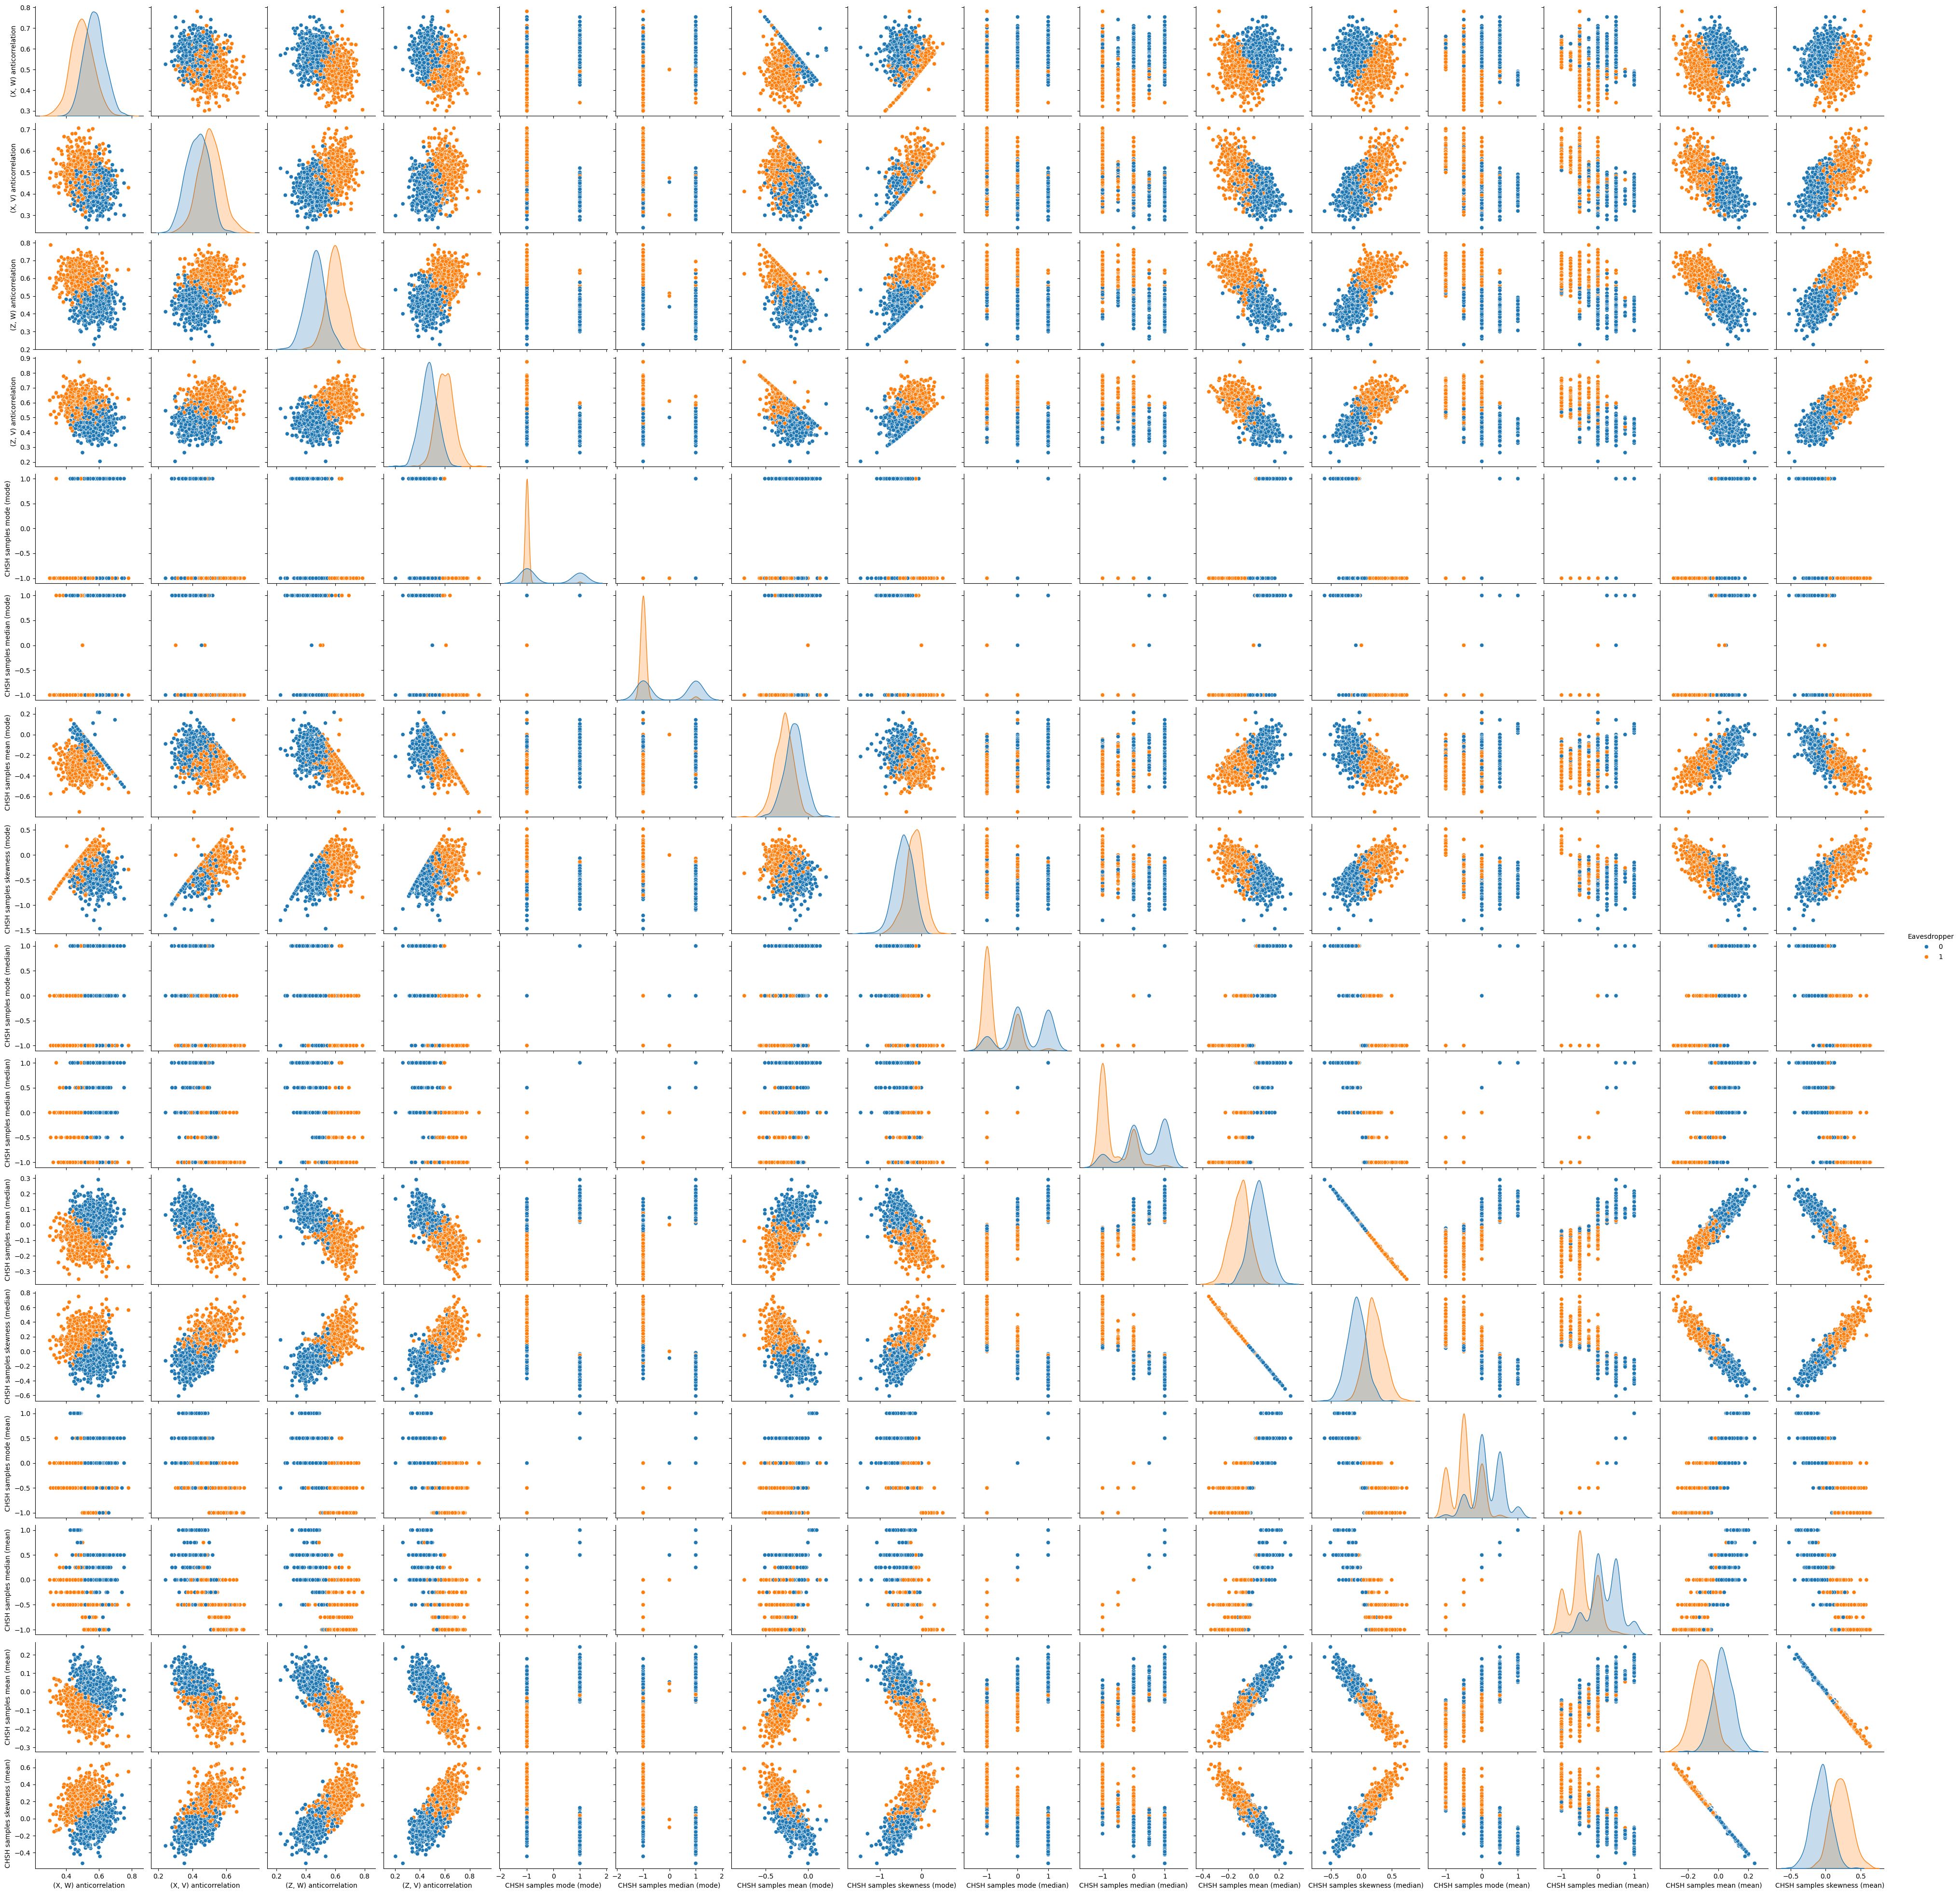

In [48]:
sns.pairplot(data = df, hue = "Eavesdropper", palette = "tab10")
plt.show()

## Osservazioni

### Osservazione su Charlie

Charlie non può essere una parte "semi-onesta" - cioè, segue alla lettera il protocollo come una parte fidata ma sfrutta i dati che può leggere ai propri fini personali.

Si immagini, per meglio capire, un servizio che distribuisce chiavi simmetriche: appena distribuisce la chiave ad Alice e Bob, può leggere i messaggi che si scambiano e da essi creare pubblicità mirate (non per scopi malevoli, o sarebbe una terza parte non fidata). Poiché Charlie si limita esclusivamente a distribuire singoletti e a distribuire una pre-shared key (che non viene utilizzata per scambiare messaggi segreti), non può essere una parte semi-onesta.

### Osservazione sulla sicurezza a posteriori dell'EE91

Una nota molto importante che rende l'EE91 non inutile: la privacy amplification, nel classico E91, si esegue solamente se passa il test di Bell e assicura che possibili scrutatori in possesso di informazioni ne abbiano di meno: nell'EE91, la privacy amplification (preceduta dalla correzione degli errori) deve avvenire a priori e ci assicura che in caso di falsi negativi, la chiave è tutelata. \
Pur avendo un recall superiore al 99%, se mai dovesse esserci un falso negativo...

- la chiave ottenuta da Eve sarà rumorosa;
- Alice e Bob avranno fatto Error Correction e Privacy Amplification; 
- gli attacchi sono molto rari, quindi è un trade-off accettabile.

Poiché diversi paper dimostrano come sia possibile ridurre drasticamente il QBER di un protocollo come l'E91 in canali fortemente rumorosi come una fibra ottica estesa, l'idea di fare intrusion detection PRIMA di fare error correction e privacy amplification torna utile essendo quest'ultime operazioni molto onerose.

Essendo lo scopo quello di pre-screening, dato che l'E91 diventerebbe "affidabile", l'idea è quella di riuscire di evitare error correction e privacy amplification, e riuscire a classificare in ambiente rumoroso: dunque la potenziale presenza di falsi negativi non è un problema perché il test di Bell tornerebbe a funzionare, essendo l'E91 operativo al di sotto del tasso di QBER dell'11%, e lo scopo è evitare a priori (con alta accuratezza) l'overhead di correzione e privacy.

Altre direzioni possono essere il filtraggio del rumore tra DNN, o l'uso del quantum machine learning.